In [16]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import mpl_scatter_density     # density scatter plots
import pandas as pd # Pandas
import uproot
import pickle
import logging

import os # read directories etc.
from scipy.signal import find_peaks, gaussian
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import pylandau

import time
from timeout_decorator import timeout

from LoadBatch import *
from SensorClasses import *

In [2]:
pd.set_option('display.max_columns', None)
# logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] - %(message)s')
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')
# plt.rcParams['text.usetex'] = True   ### LateX in matplotlib
# !ls ../Data_TestBeam/2023_May/

In [3]:
# plt.style.use(hep.atlas.style.ATLAS)

### Bins options, sensors and runs import

In [35]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
large_bins = (np.arange(0, 900,1),
              np.arange(0, 600,1))

bins = (np.arange(450, 700, 1),
        np.arange(100, 500, 1))

small_bins = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
# dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

print(dict_of_batches.keys())

### branches to be loaded (+ unnecessary columns)
# branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
# columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

# ### presentation path
# pres_path = '/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Presentations/8 December 23'

dict_keys([199, 100, 101, 201, 202, 203, 301, 401, 402, 403, 204, 407, 408, 409, 410, 411, 205, 206, 413, 414, 501, 502, 503, 504, 505, 601, 602, 603, 604, 605, 701, 702, 801, 802, 901, 902, 1001, 1002, 1101, 1102, 1201, 1202])


In [5]:
unique_names = []
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if (type(sensor.name) == str) and (sensor.name not in unique_names):
                unique_names.append(sensor.name)

# print(unique_names)
for name in unique_names:
    for batch_object in dict_of_batches.values():
        for S in ['S1','S2']:  
                for ch, sensor in batch_object.S[S].channels.items():
                    if (sensor.name == name):
                        print(f"Sensor: {sensor.name}, voltage: {sensor.voltage}, angle: {batch_object.angle}, fluence: {sensor.fluence}, in batch {batch_object.batch_number} "+"temp: %.1f°C"%batch_object.tempA+f" {S}, {ch})")
    print('-------------------------------------------')

Sensor: MCP, voltage: 2600, angle: 0.0, fluence: 0, in batch 199 temp: -31.0°C S1, Ch1)
Sensor: MCP, voltage: 2600, angle: 0.0, fluence: 0, in batch 199 temp: -31.0°C S2, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 100 temp: -32.8°C S1, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 100 temp: -32.8°C S2, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 101 temp: -33.3°C S1, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 101 temp: -33.3°C S2, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 201 temp: -31.3°C S1, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 201 temp: -31.3°C S2, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 202 temp: -32.2°C S1, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 202 temp: -32.2°C S2, Ch1)
Sensor: MCP, voltage: 2500, angle: 0.0, fluence: 0, in batch 203 temp: -32.3°C S1, Ch1)
Sensor: MCP, voltage: 2500, angl

I kinda want a 'reversed' dictionary:
for each sensor_name: have a list of batches

## Plot a single batch

In [17]:
### show all information about the batch
this_batch = 204
print(dict_of_batches[this_batch].__dict__,'\n')

### show all informations about each sensor
for S in ['S1','S2']:
    for ch, sensor in dict_of_batches[this_batch].S[S].channels.items():
        print(f"{S}, {ch}:", sensor.__dict__)

{'batch_number': 204, 'angle': 0.0, 'runs': [9672, 9673, 9674], 'tempA': -30.03333333333333, 'tempB': -30.5, 'S': {'S1': <SensorClasses.Oscilloscope object at 0x7f983429a500>, 'S2': <SensorClasses.Oscilloscope object at 0x7f983429a7a0>}} 

S1, Ch1: {'name': 'MCP', 'board': ' ', 'dut_position': 5.0, 'fluence': 0, 'transimpedance': 4700, 'voltage': 2500}
S1, Ch2: {'name': 'IMEv3-W12-C2-2-2', 'board': 'CERN-1', 'dut_position': 1.0, 'fluence': 0, 'transimpedance': 10700, 'voltage': -125}
S1, Ch3: {'name': 'IMEv3-W12-C2-2-2', 'board': 'CERN-1', 'dut_position': 1.0, 'fluence': 0, 'transimpedance': 10700, 'voltage': -125}
S1, Ch4: {'name': 'IMEv3-W12-C3-1-4', 'board': ' ', 'dut_position': 1, 'fluence': 0, 'transimpedance': 4700, 'voltage': -125}
S2, Ch1: {'name': 'MCP', 'board': ' ', 'dut_position': 5.0, 'fluence': 0, 'transimpedance': 4700, 'voltage': 2500}
S2, Ch2: {'name': 'CNM-R15973-W5-D138', 'board': ' ', 'dut_position': 4, 'fluence': 0, 'transimpedance': 4700, 'voltage': -135}
S2, Ch3:

False

[INFO] - 	 Loading batch 204 	 Oscilloscope S1


Batch:  204
S1


[INFO] - 	 in 'time_mask()': Fit parameters [ 5430.75513689 -5576.93643778    71.87639102    43.4650531 ]
[INFO] - 	 in 'time_mask()': Fit parameters [ 2942.44136127 -5796.63799823   104.32353378    44.06146764]


MCP: 2500 V, angle: 0.0° temperature:-30.03°C


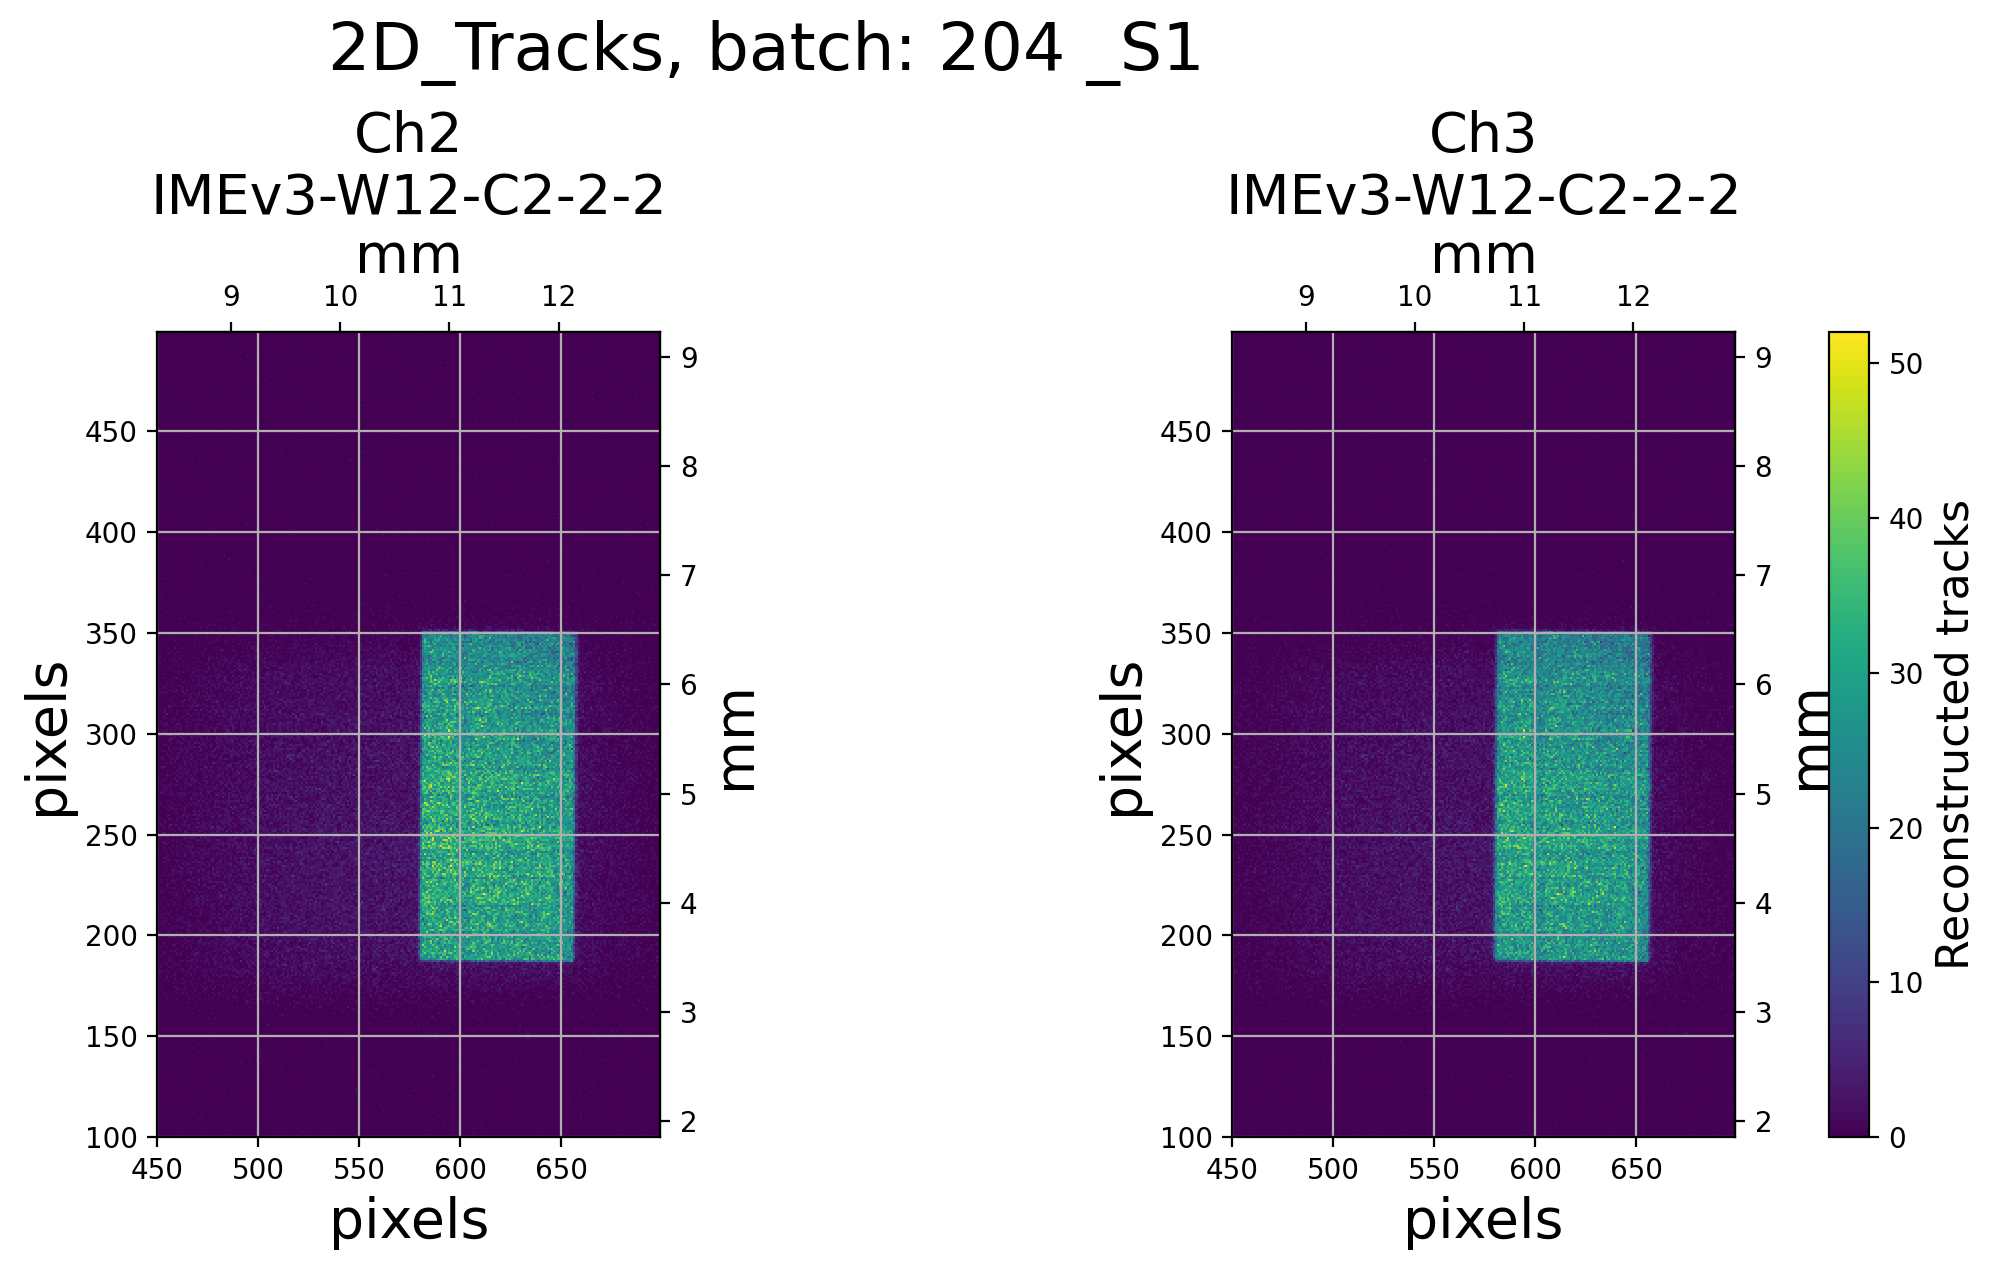

DUT_1
DUT_2


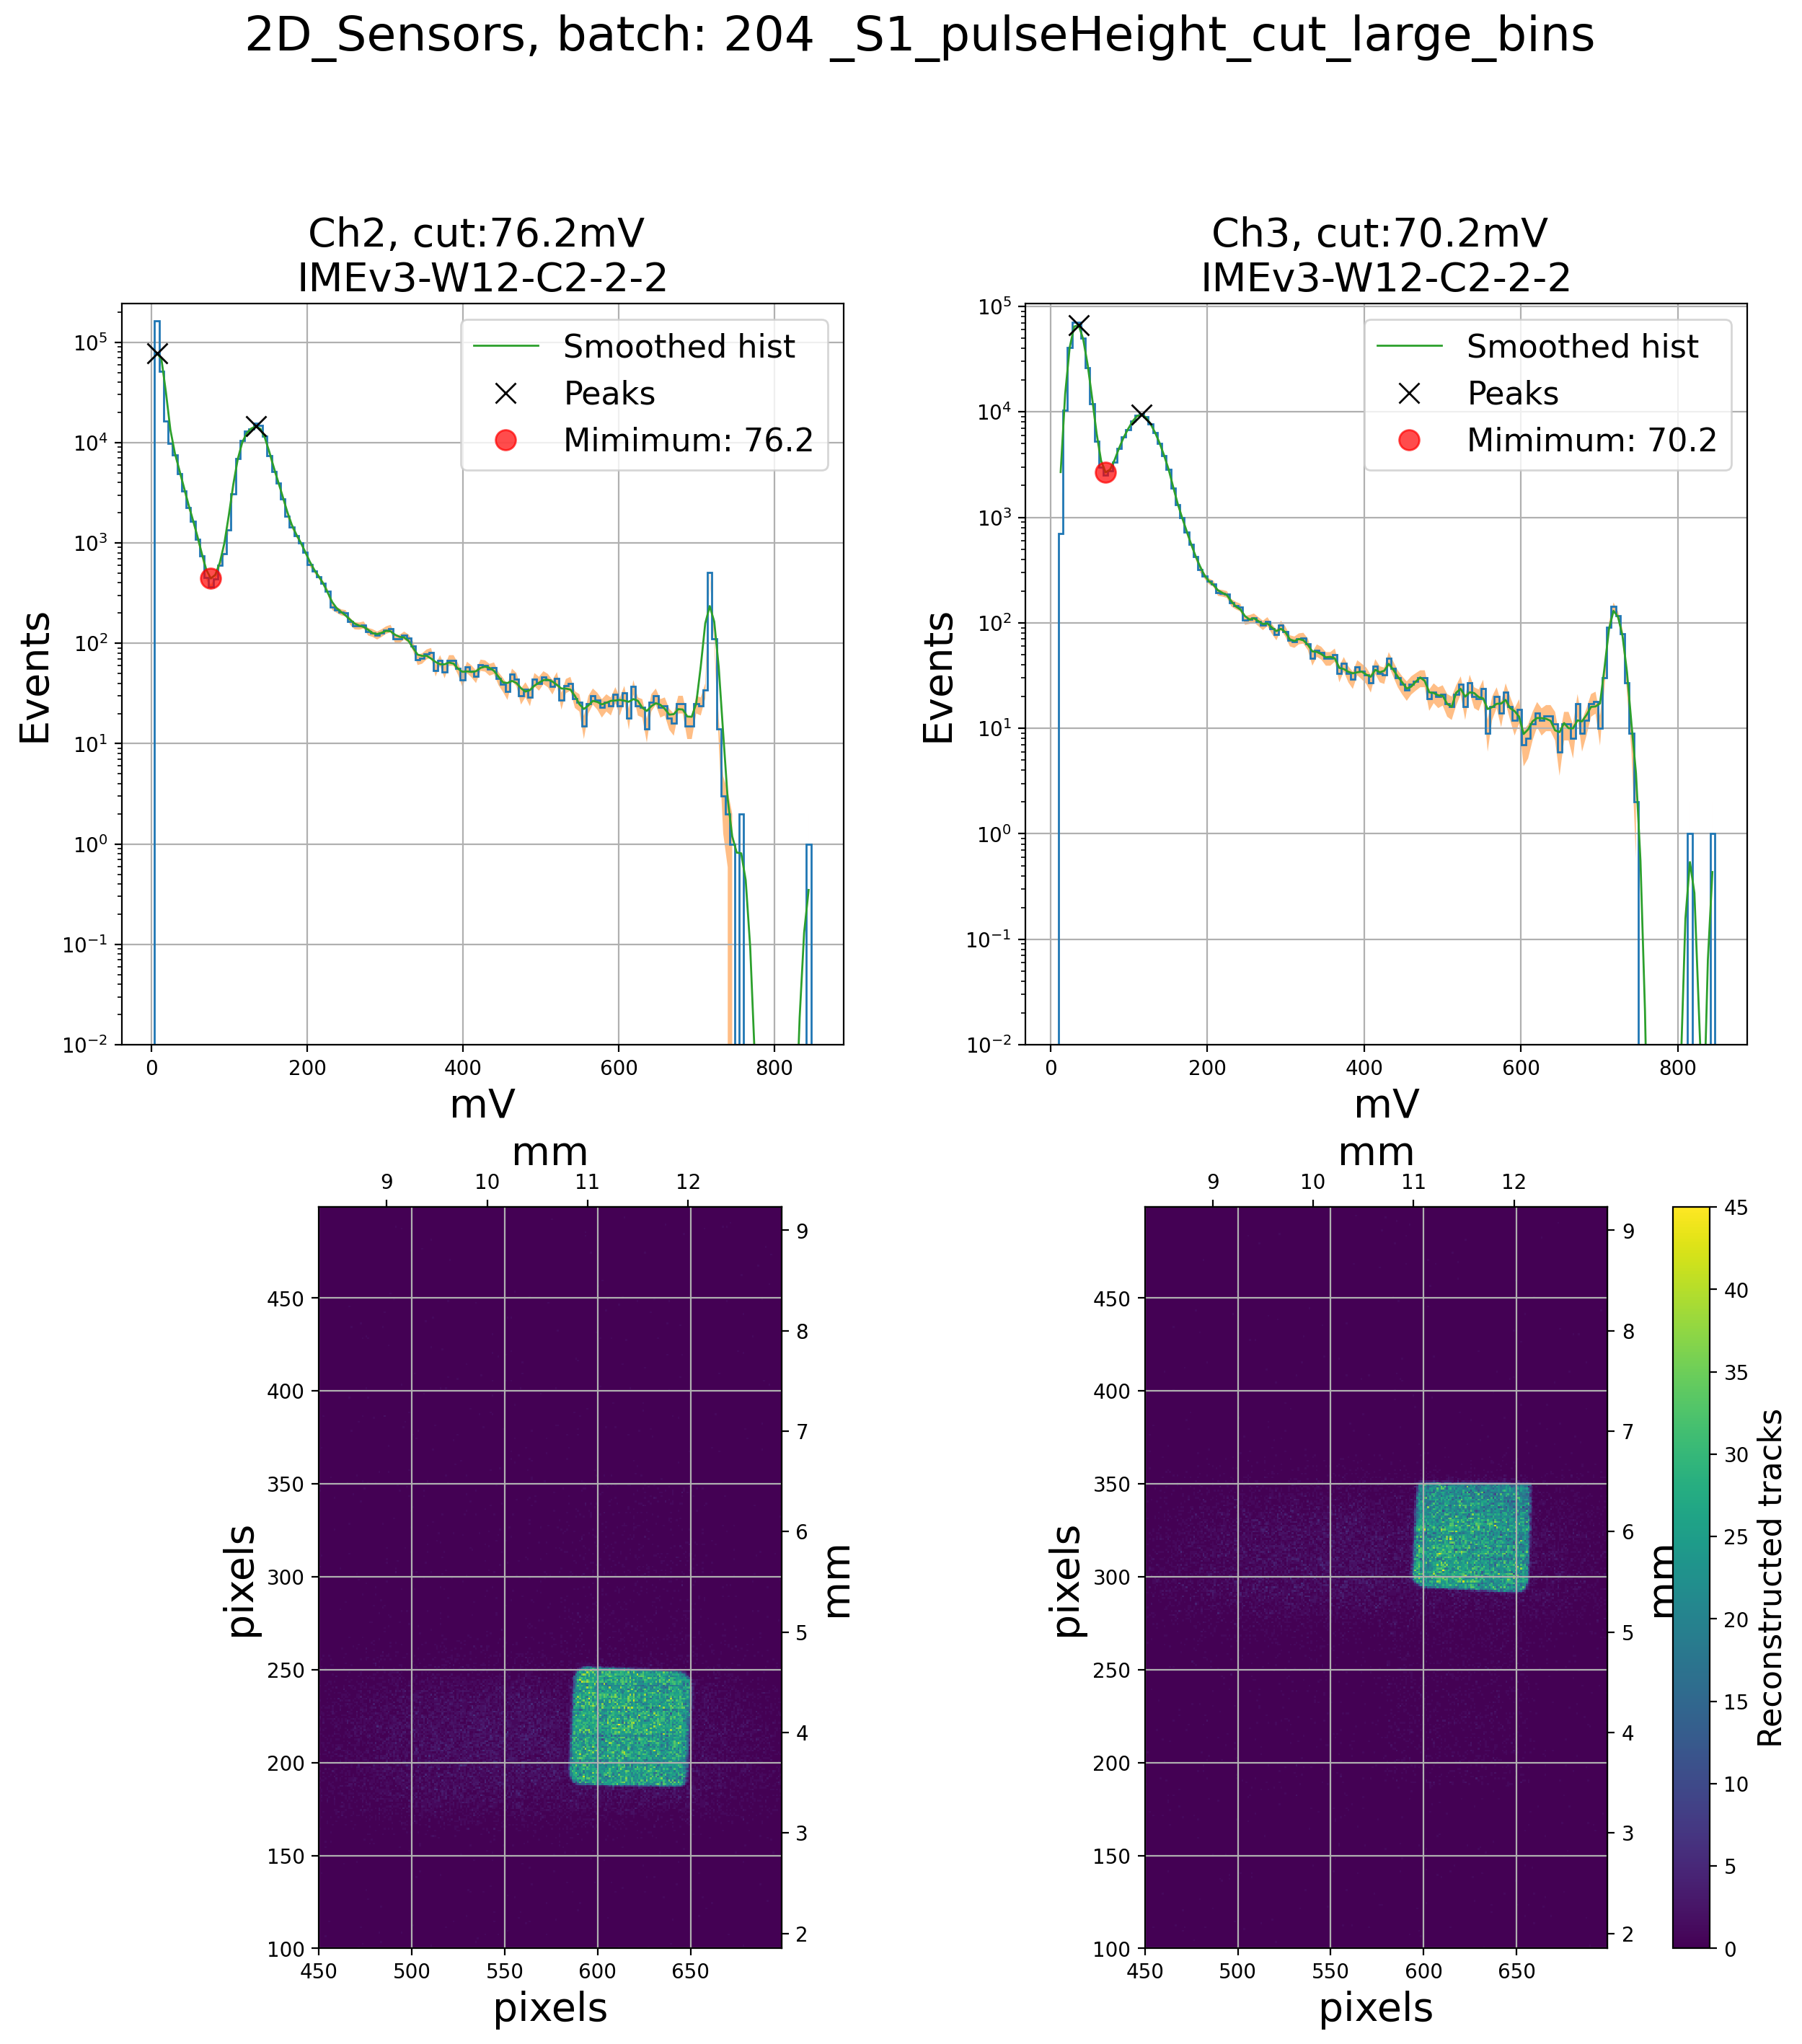

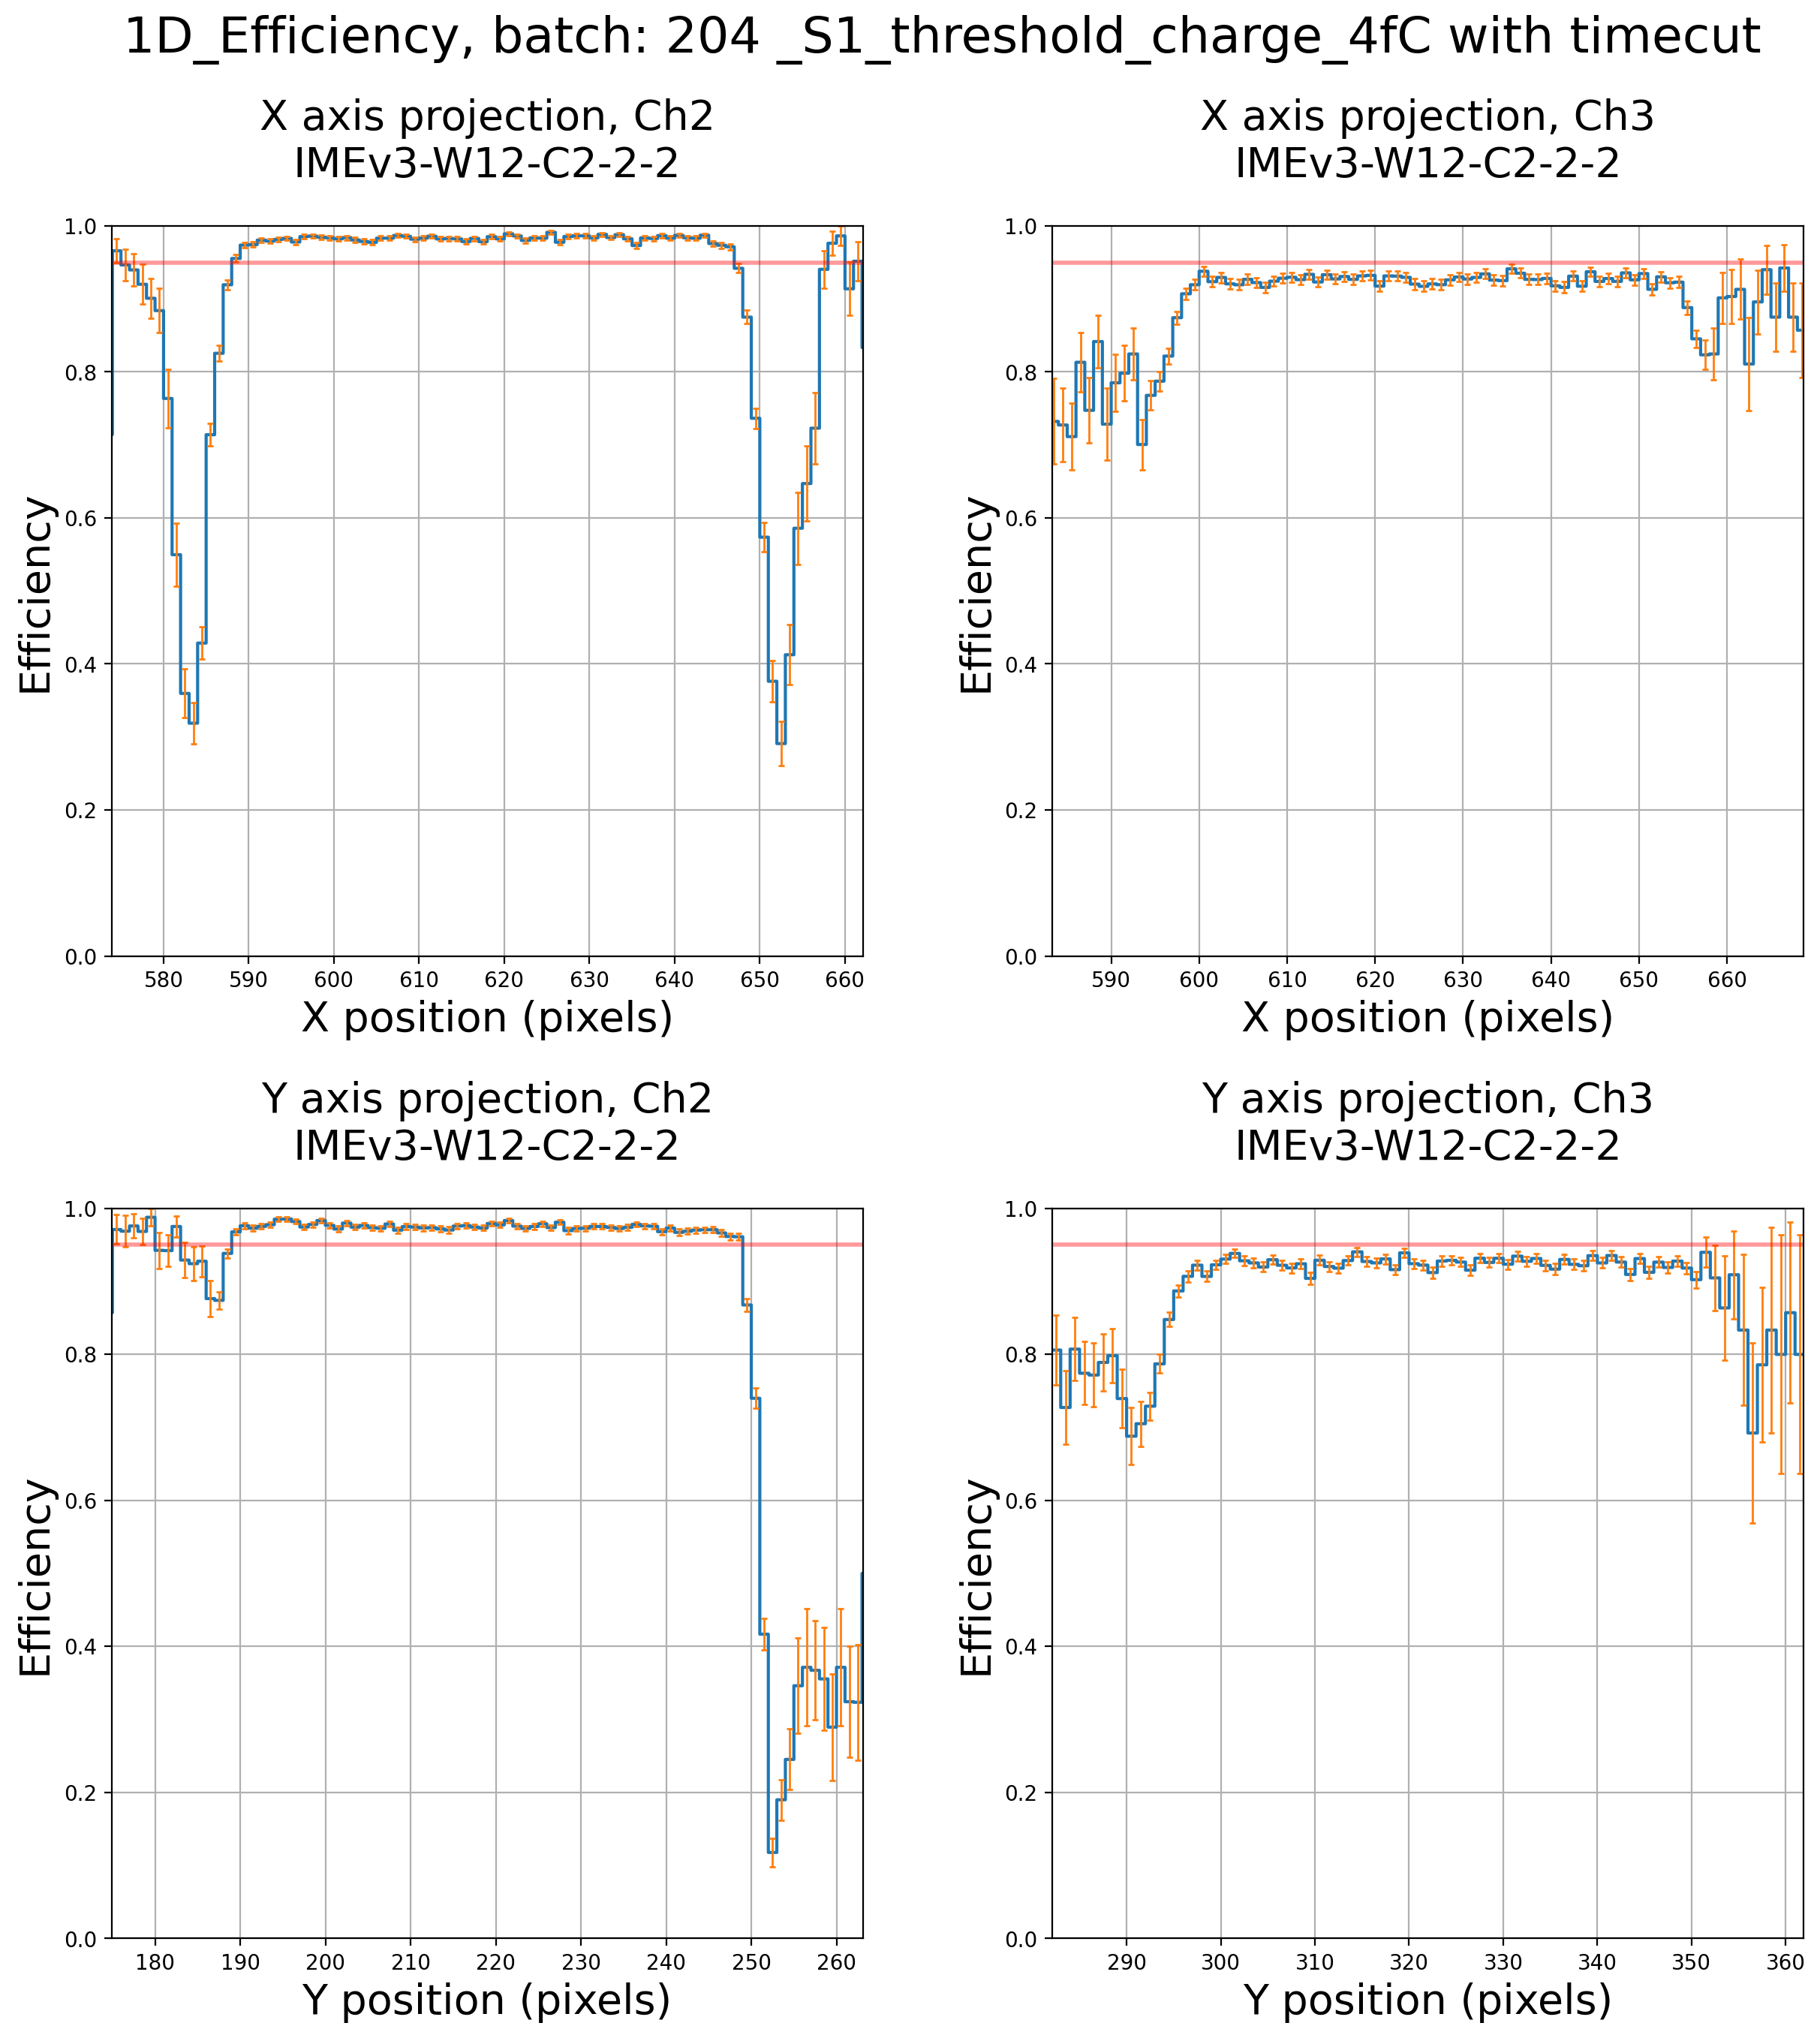

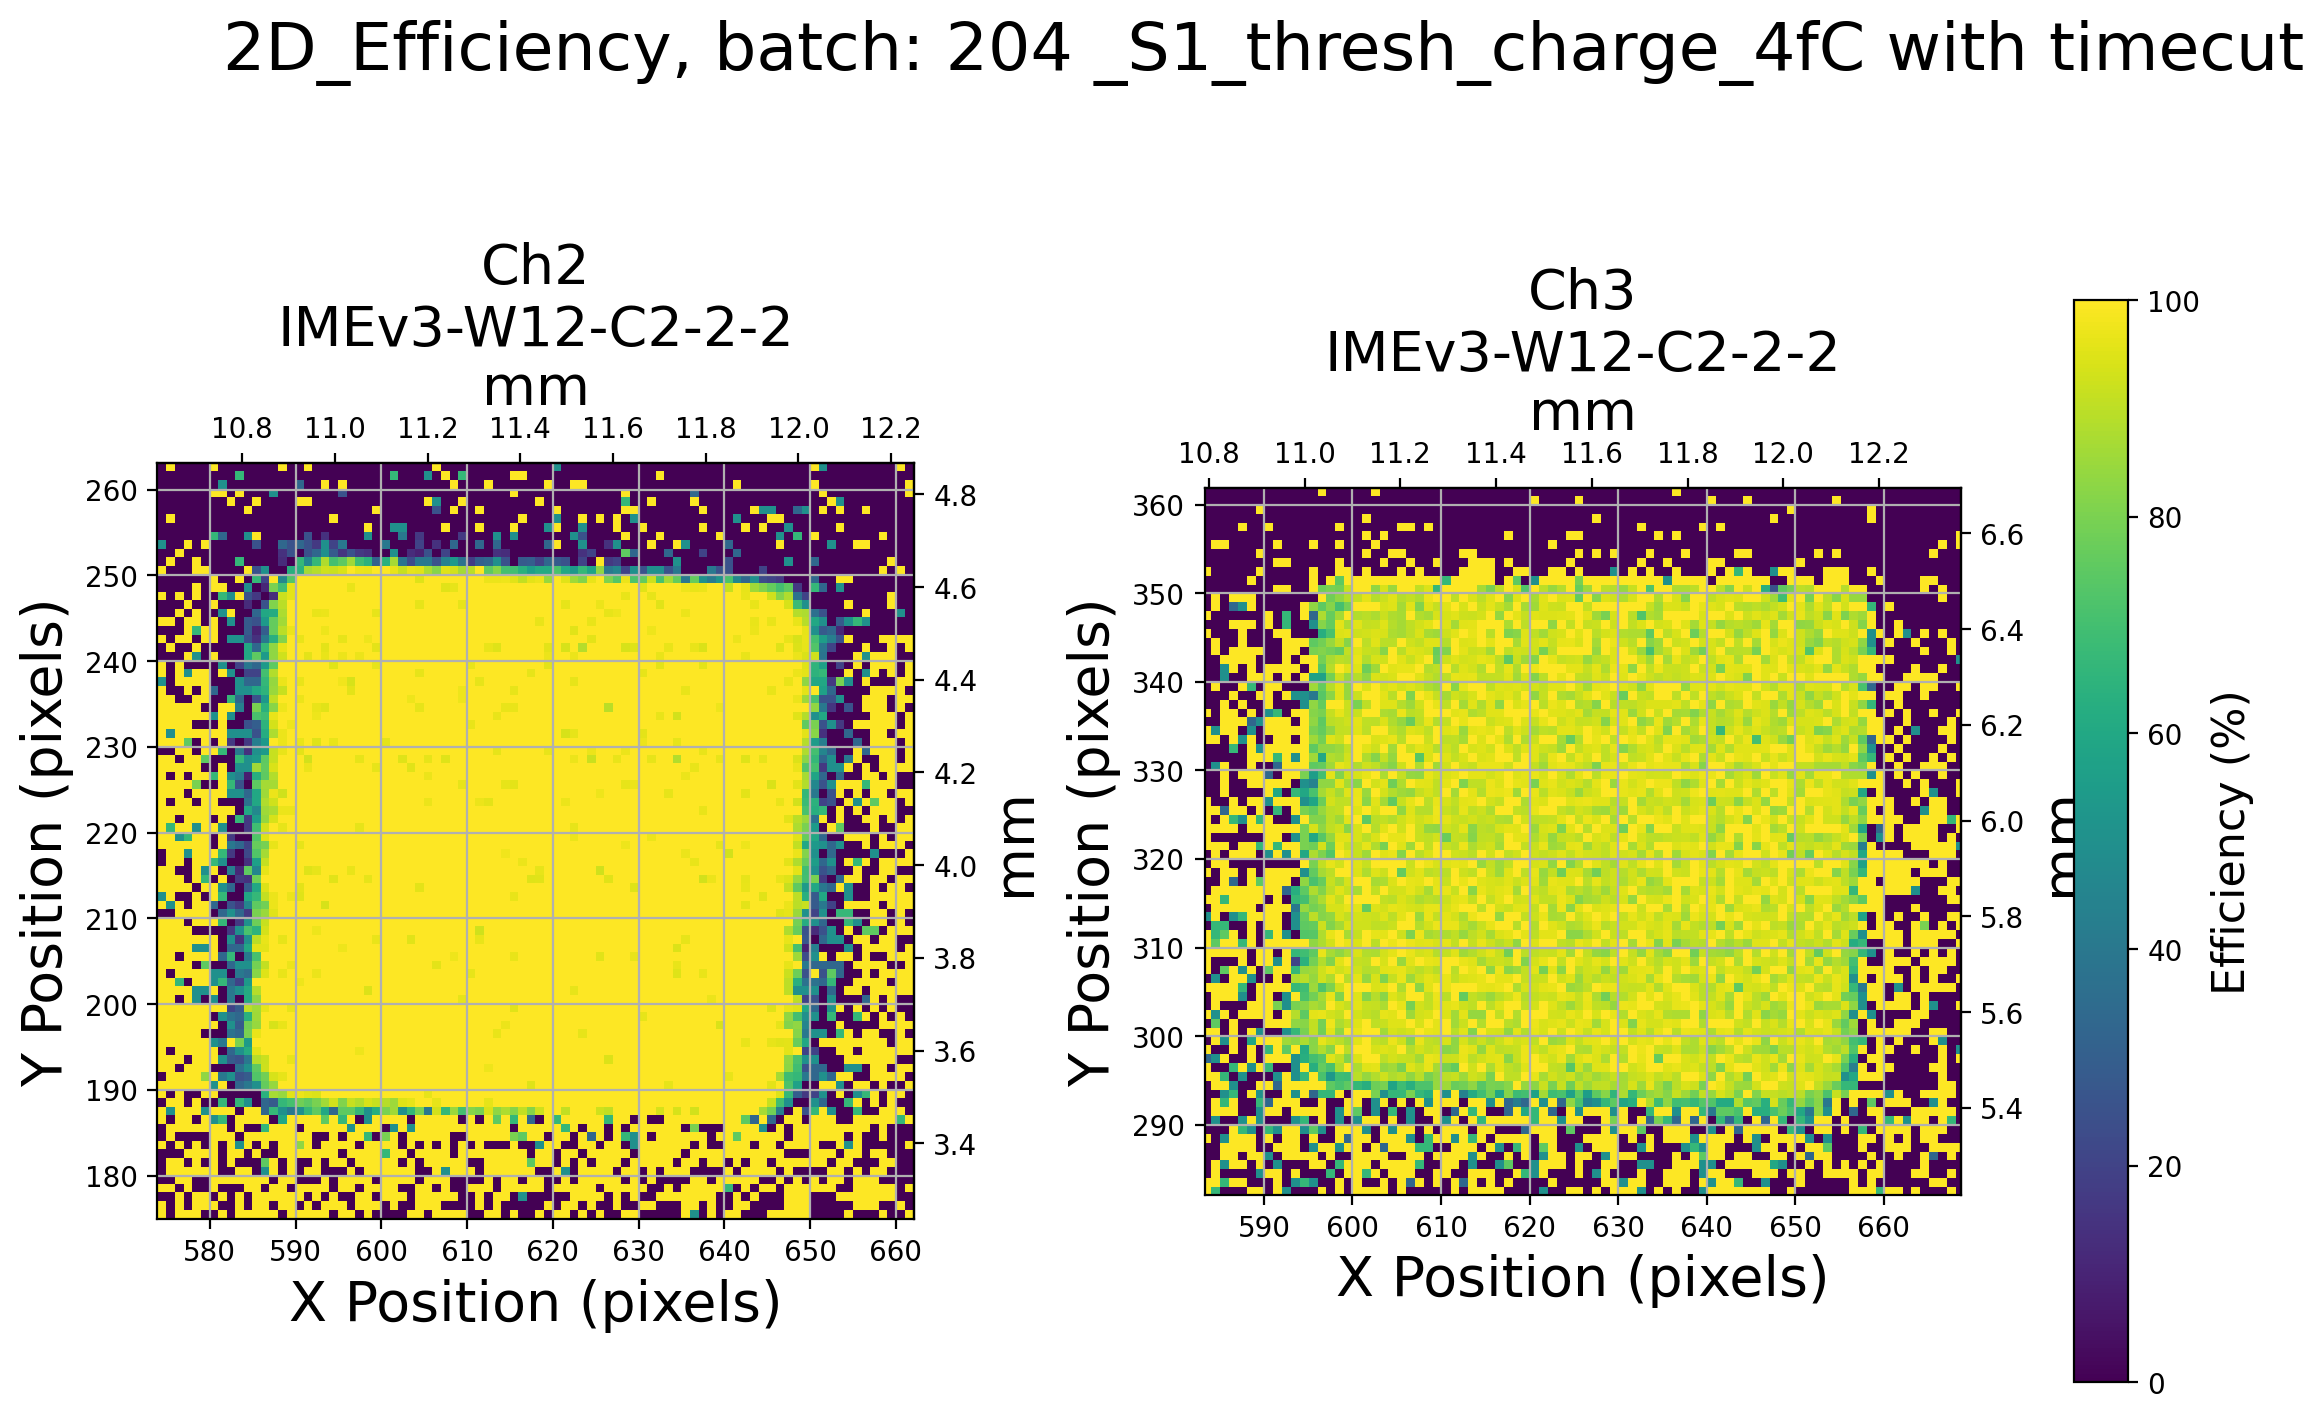

[INFO] - 	 Loading batch 204 	 Oscilloscope S2


S2


[INFO] - 	 in 'time_mask()': Fit parameters [ 4.95898395e+00 -1.29383843e+04  7.62410122e+01  6.05811073e+01]
[INFO] - 	 in 'time_mask()': Fit parameters [  73489.50878021   -2725.81202465 1489828.74148182  -73426.55106055]


MCP: 2500 V, angle: 0.0° temperature:-30.03°C


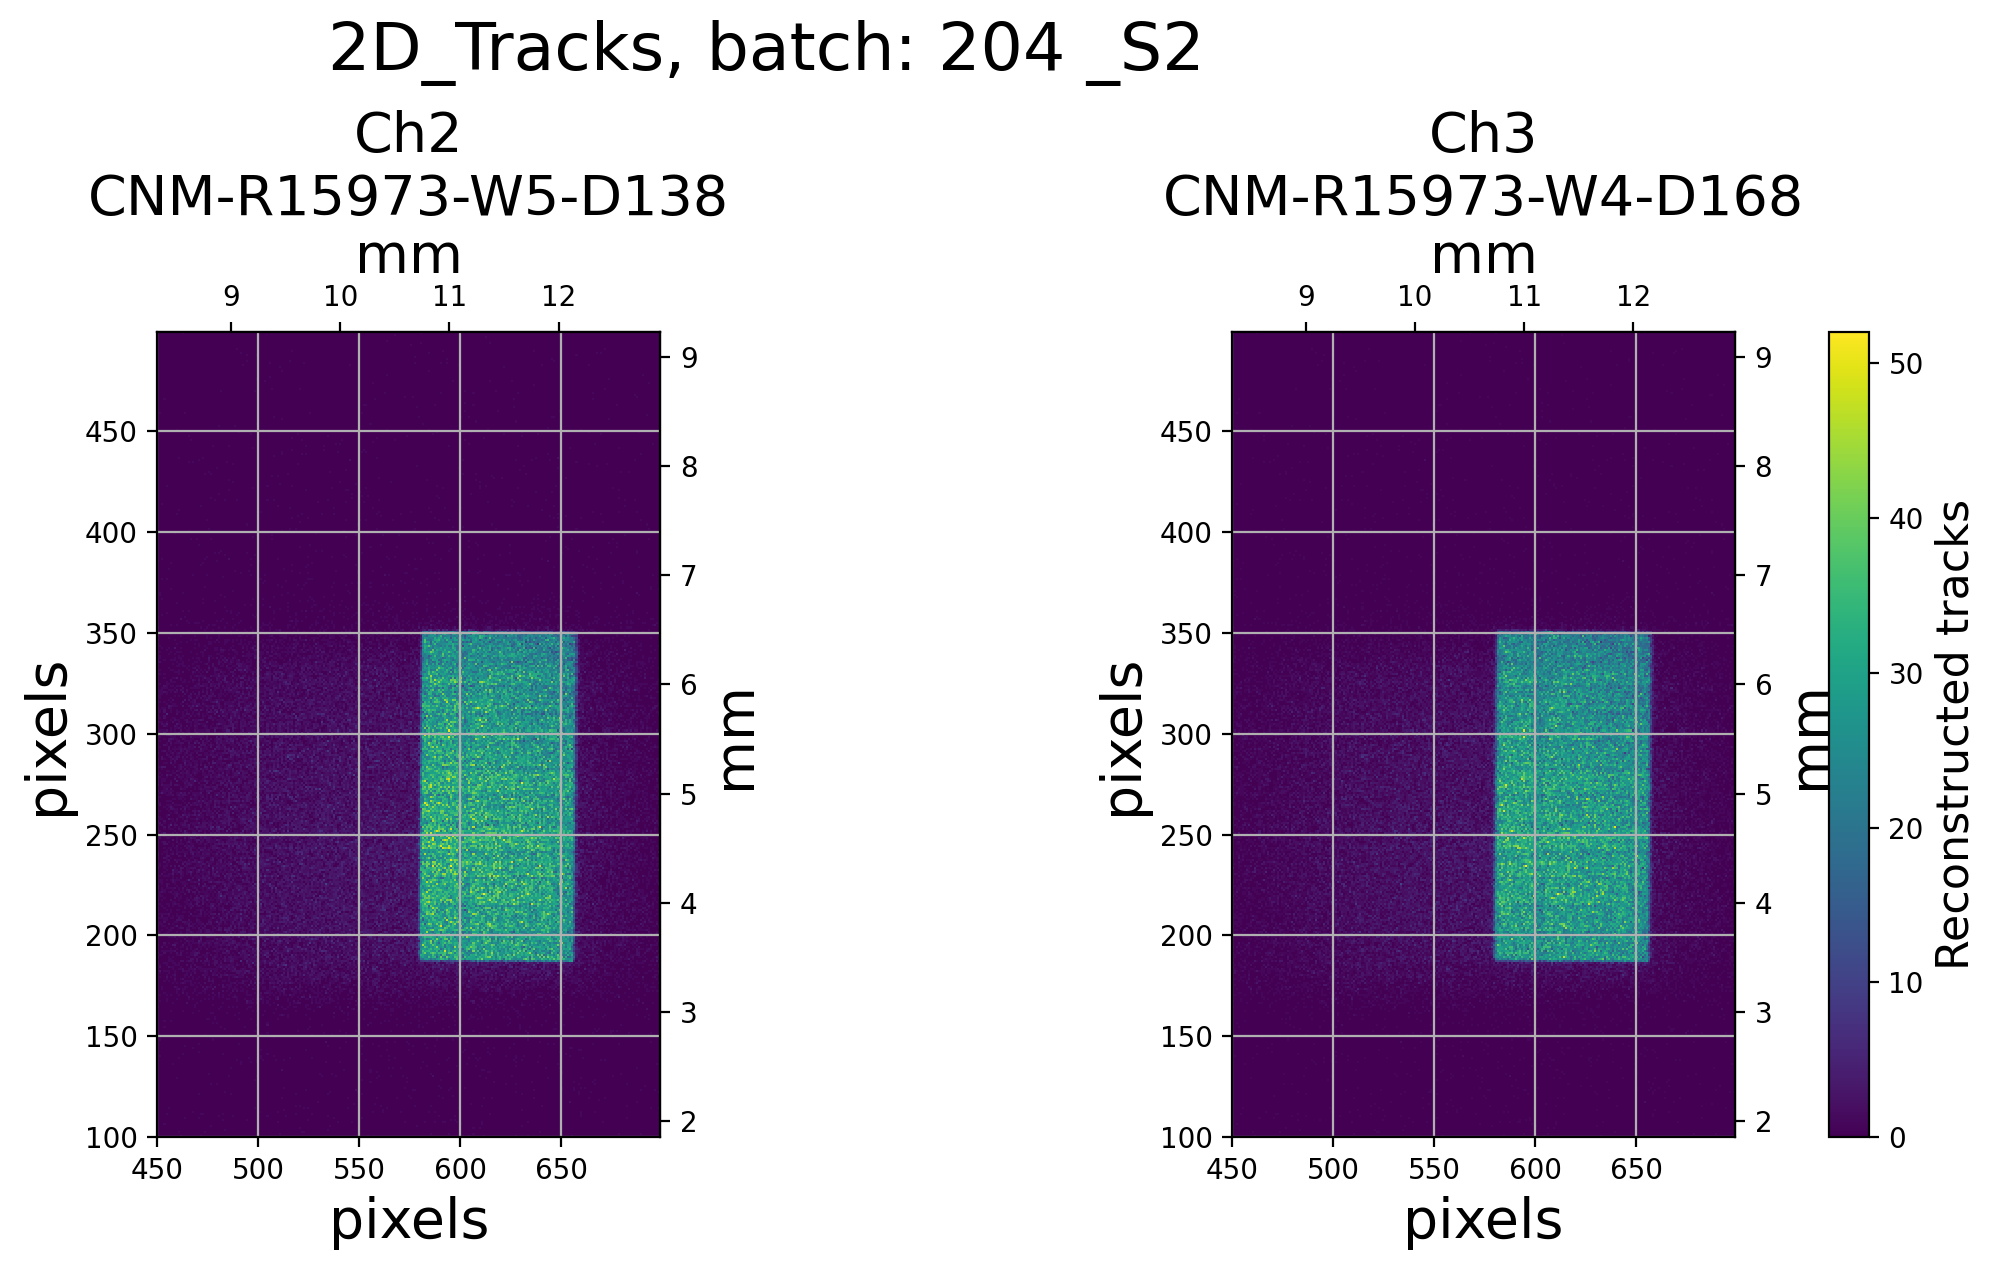

DUT_1


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 No MIN found after 20 iterations
[WARNING] - 	 in '2D_Sensors', No minimum found, no 2D plot


DUT_2


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying


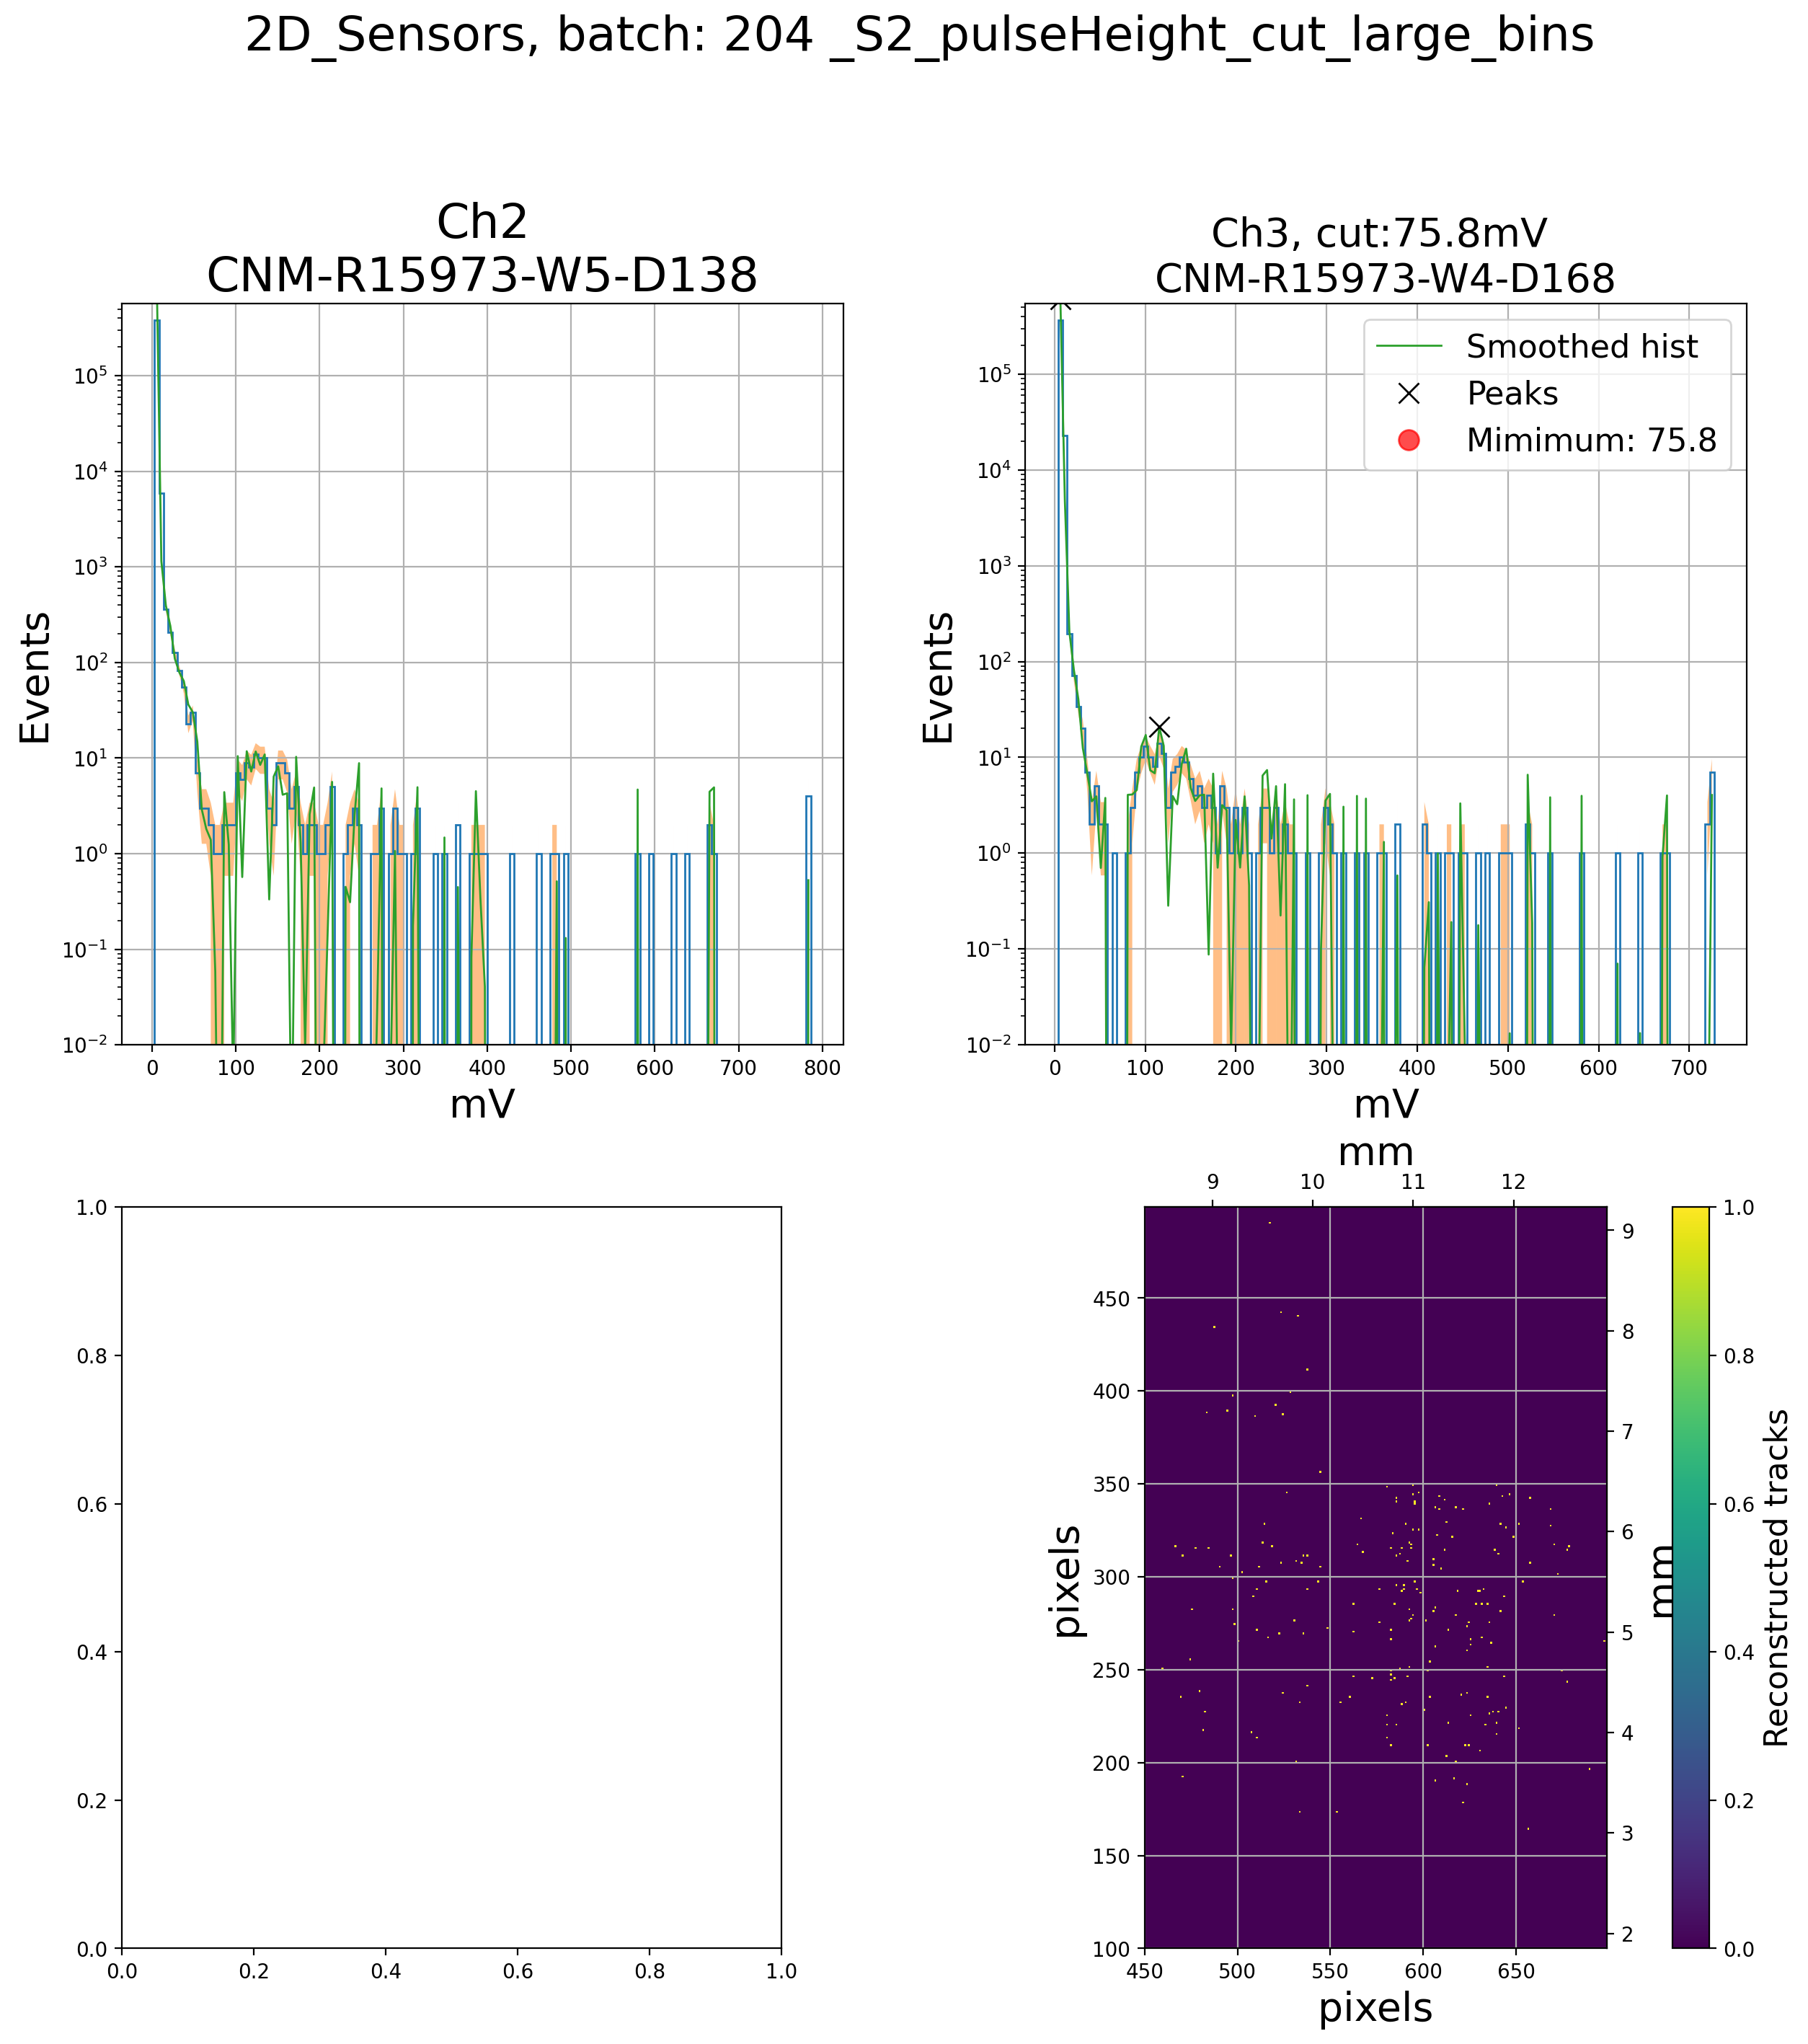

[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 No MIN found after 20 iterations
/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/LoadBatch.py:745: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  if XY=='X':     axes[coord_idx,i].set_xlim(edges['left_edge'],edges['right_edge'])
/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/LoadBatch.py:746: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  elif XY=='Y':   axes[coord_idx,i].set_xlim(edges['bottom_edge']

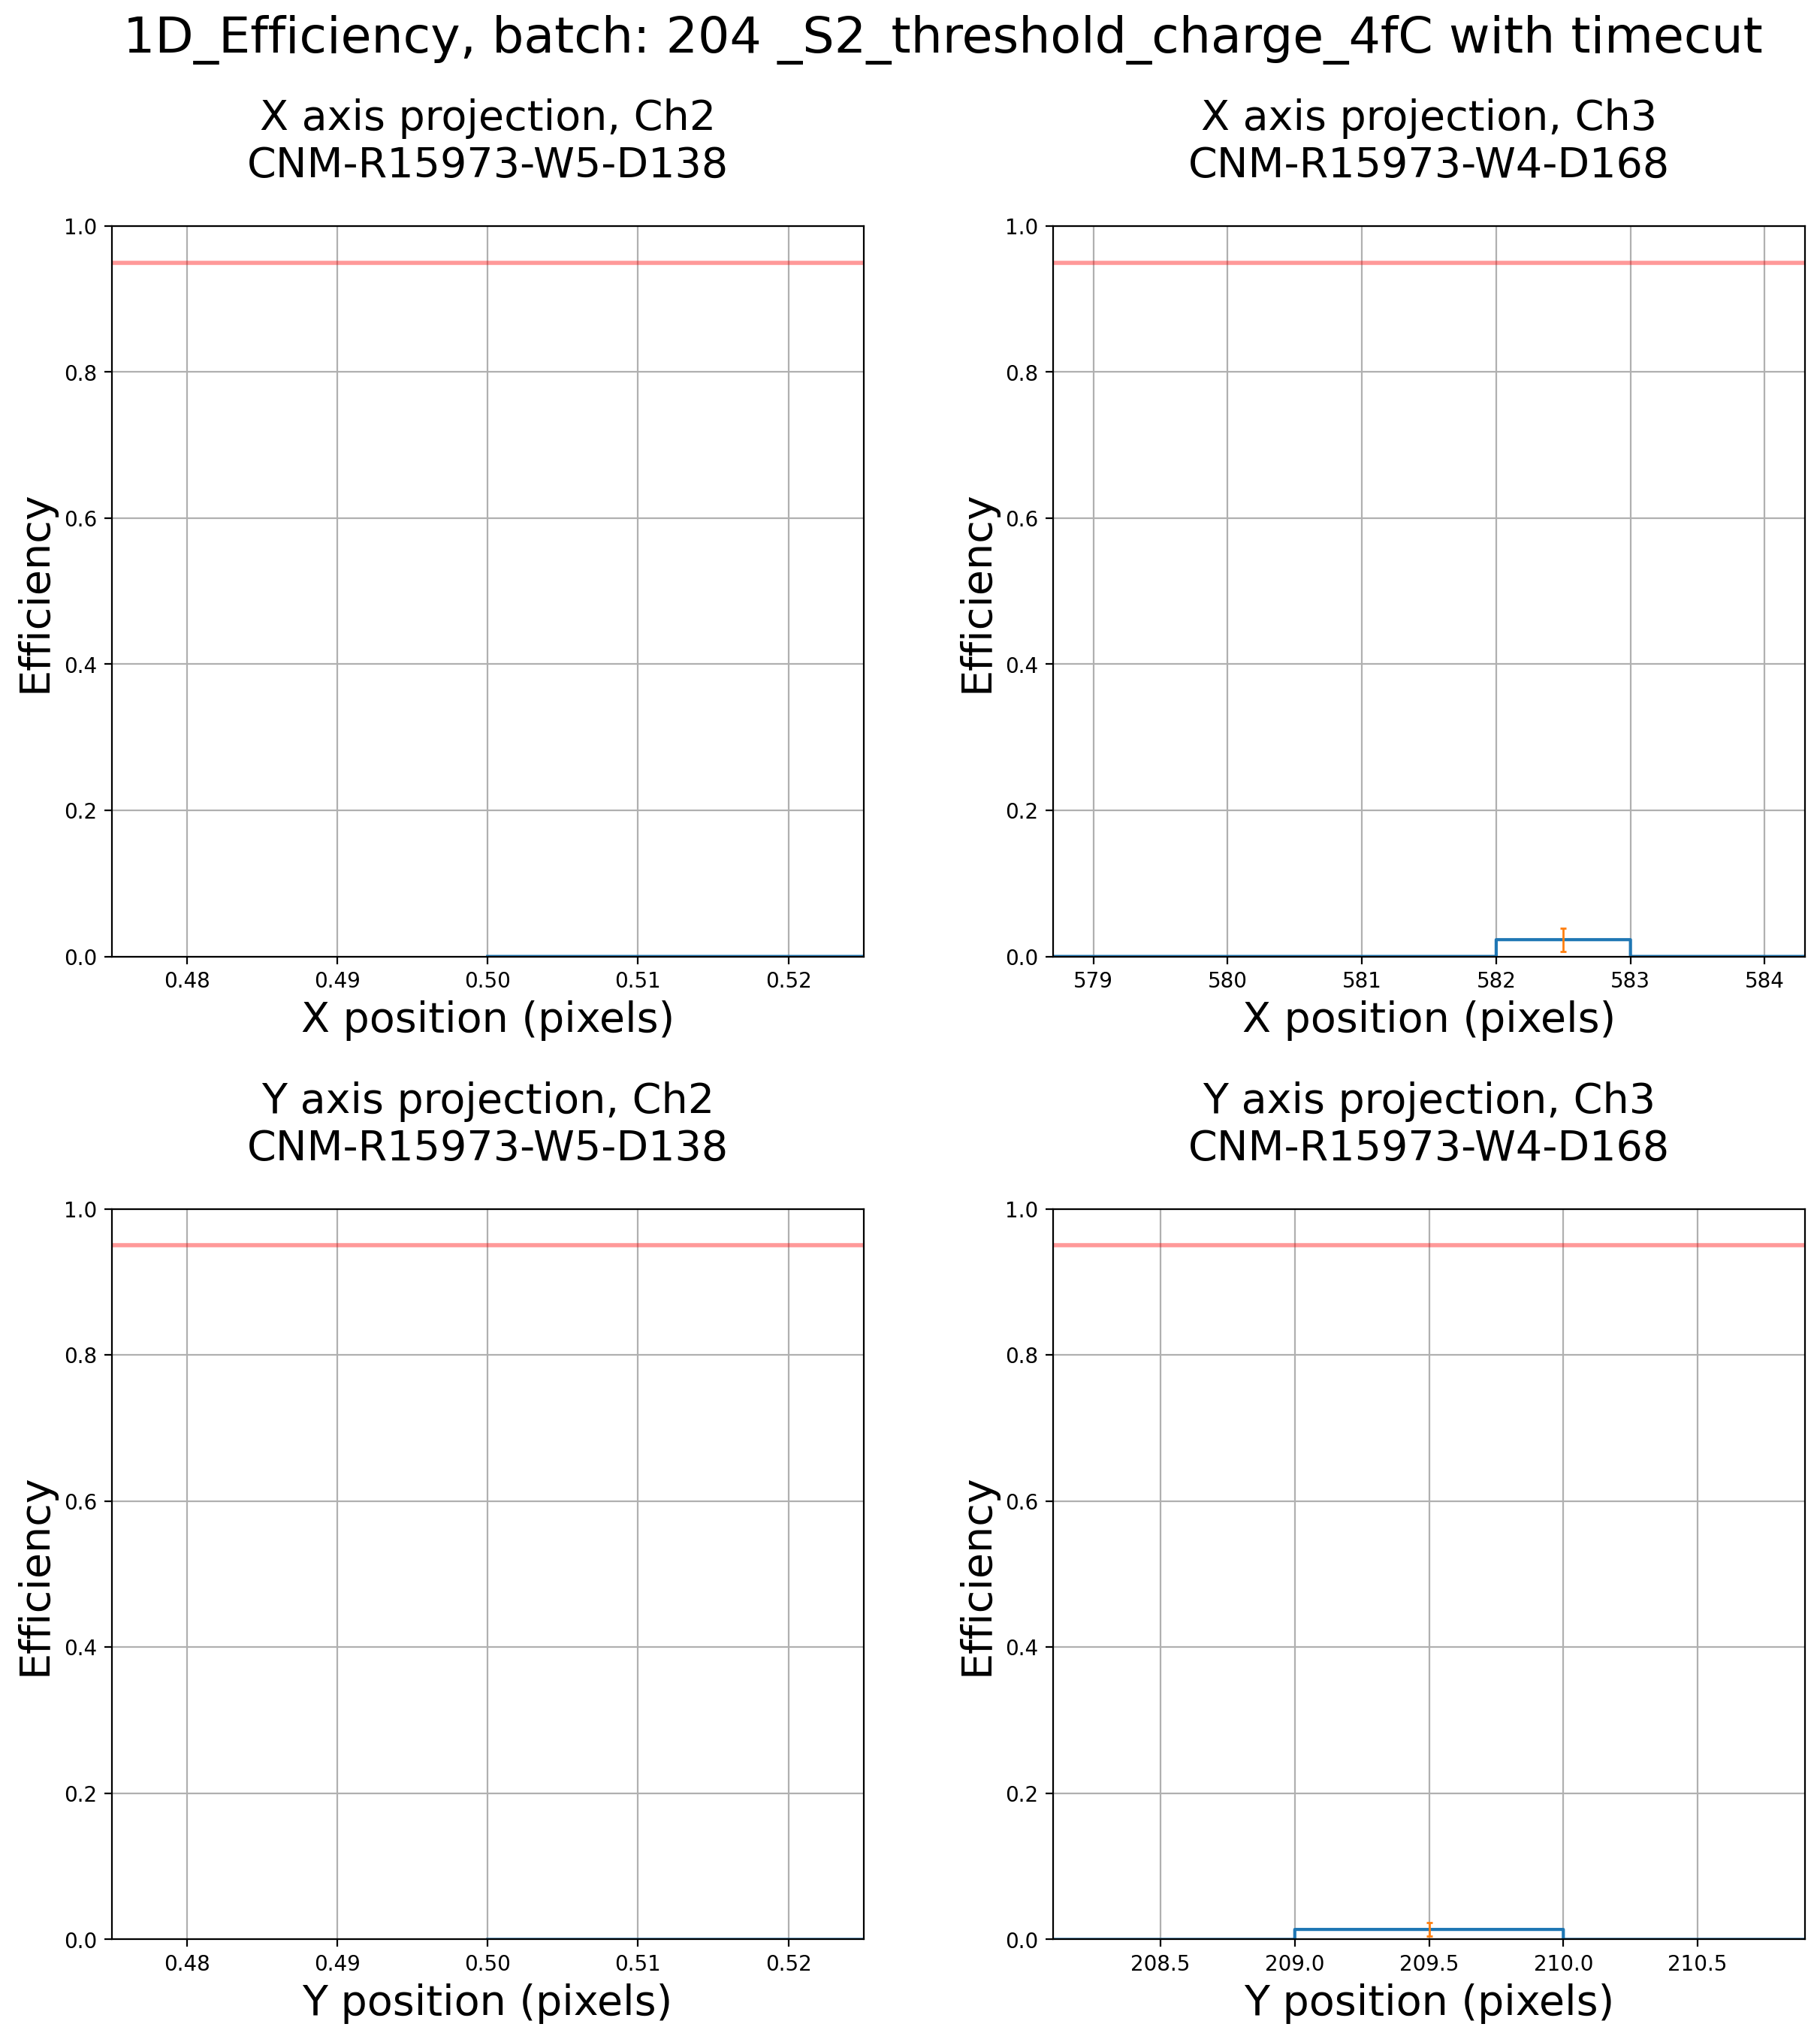

[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 No MIN found after 20 iterations
/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/LoadBatch.py:776: UserWarning: Attempting to set identical left == right == 450.5 results in singular transformations; automatically expanding.
  axes[i].set_xlim(edges['left_edge'],edges['right_edge'])
/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/LoadBatch.py:777: UserWarning: Attempting to set identical bottom == top == 100.5 results in singular transformations; automatically expanding.
  axes[i].set_ylim(edges['bottom_edge'],edges['top_edge'])
[INFO] - 	 Two peaks not fou

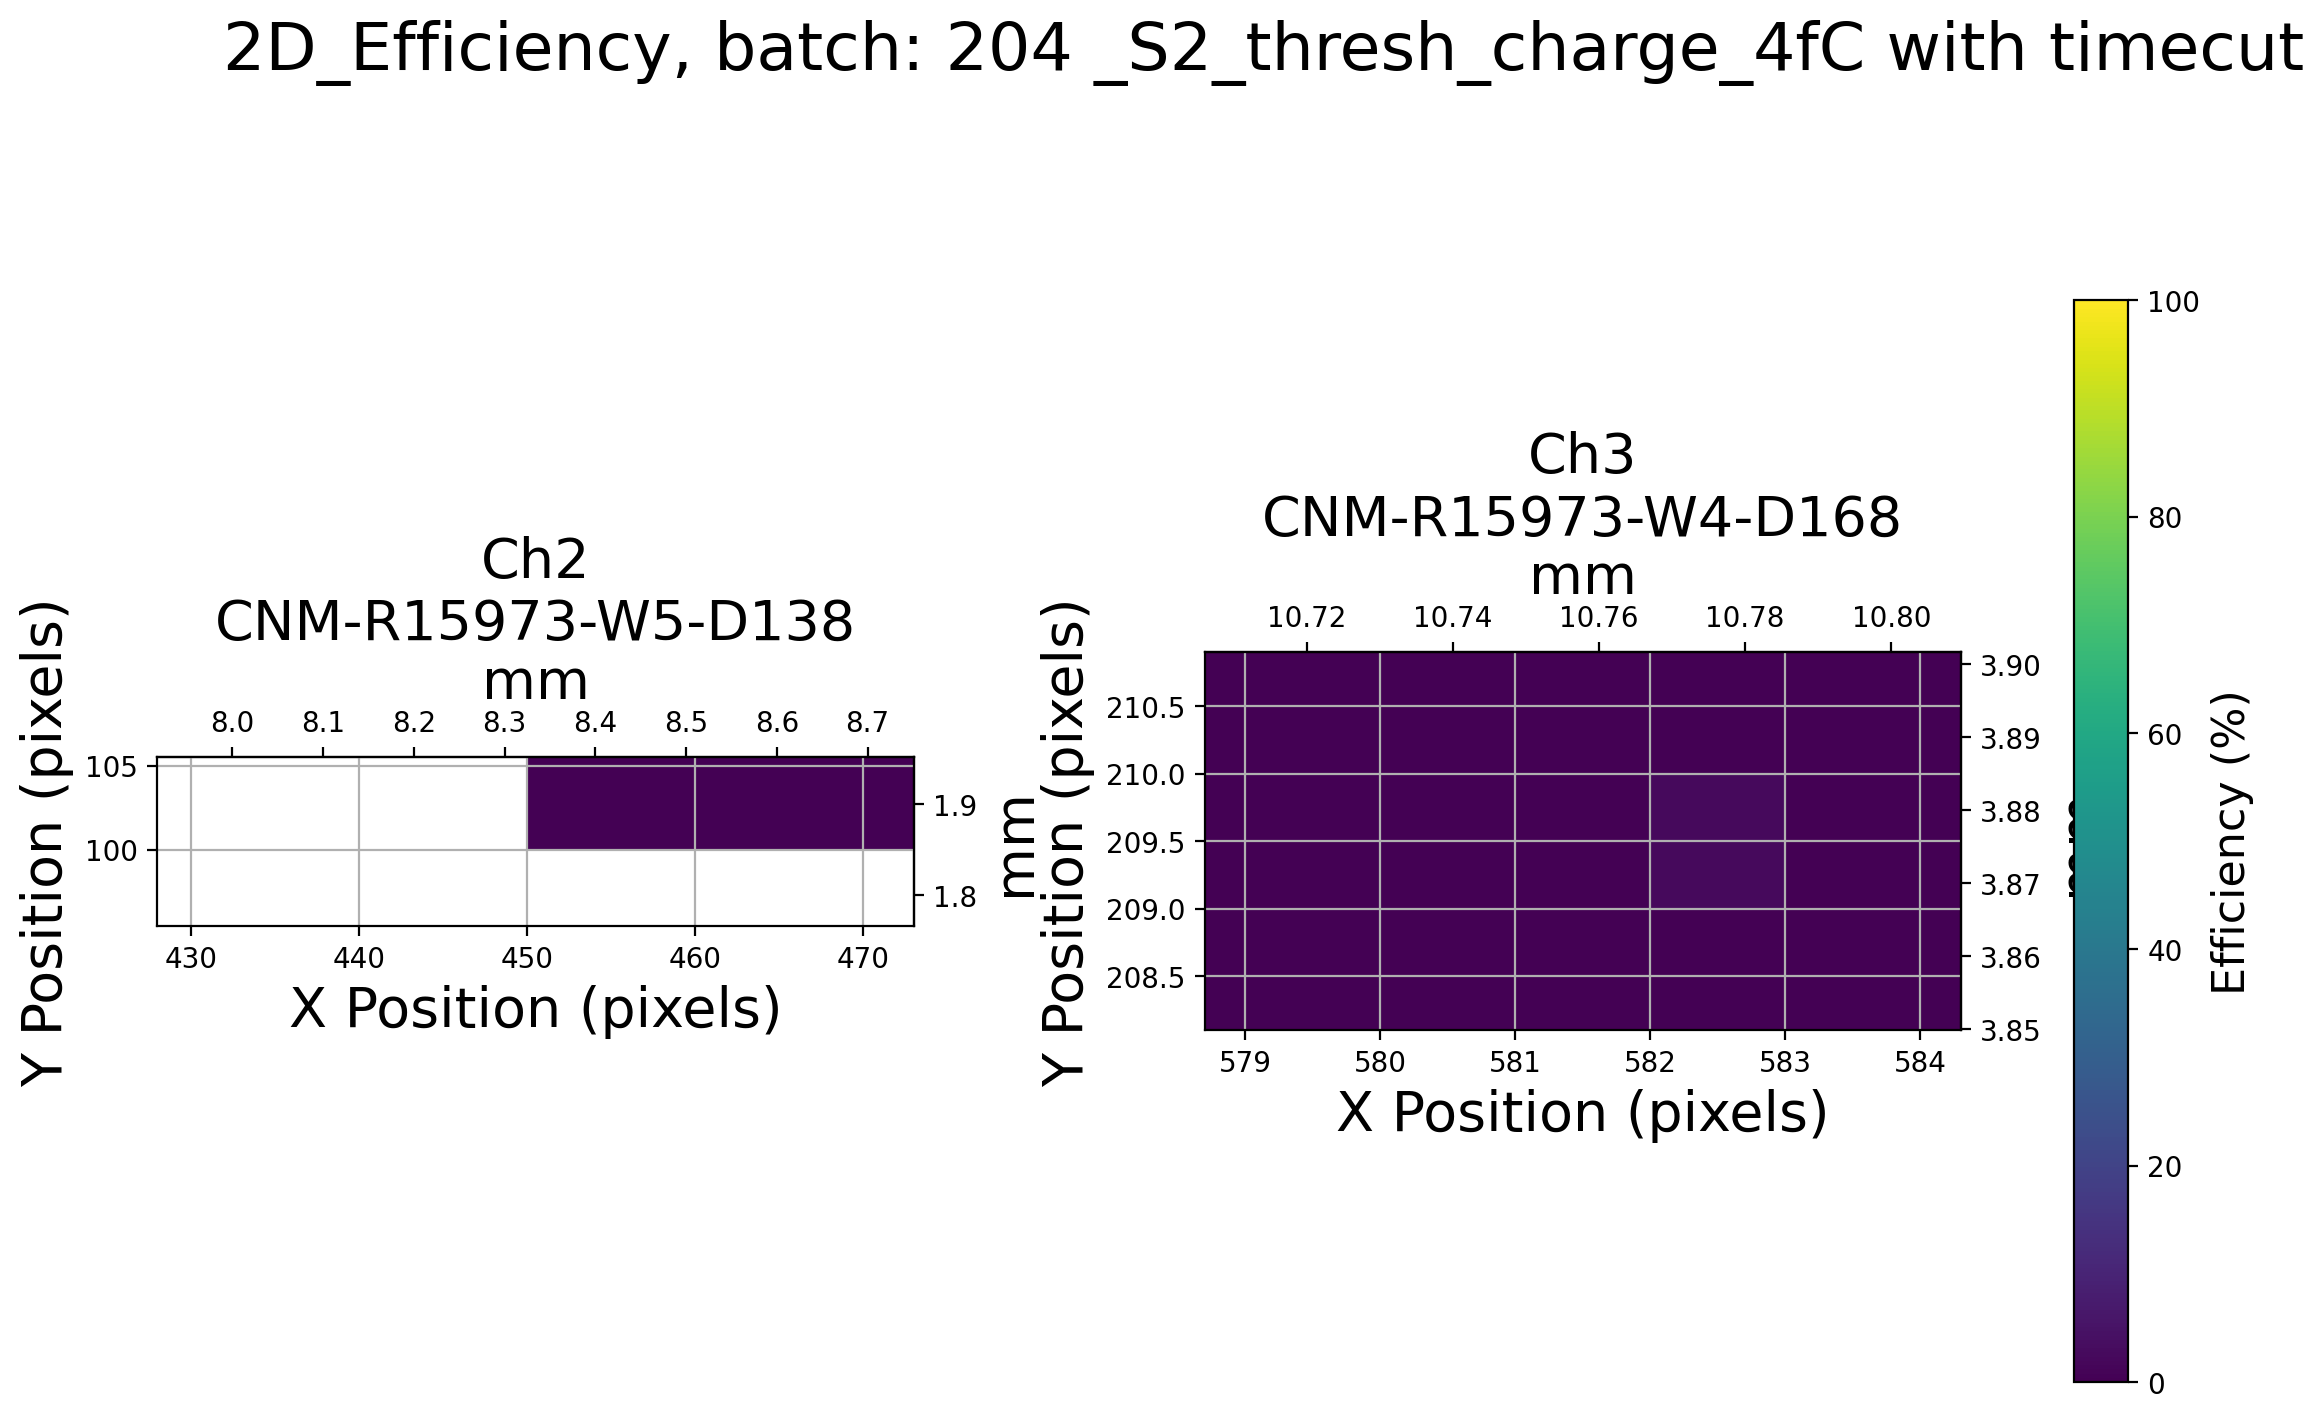

In [42]:
SAVE = False

threshold_charge = 4 #fC
DUTs = [1,2,3]

print("Batch: ", this_batch)

dir_path = f'/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/various plots/{this_batch}'
if not os.path.exists(dir_path):
    os.mkdir(dir_path)

df = {}  # dictionary containing the two dataframes of the two oscilloscopes
binning_method = 'rice'
for S in ["S1","S2"]: # the two scopes
    print(S)
    df[S] = load_batch(this_batch,S)
    print(f'MCP: {dict_of_batches[this_batch].S[S].channels["Ch1"].voltage} V, angle: {dict_of_batches[this_batch].angle}°', 'temperature:%.2f°C'%dict_of_batches[this_batch].tempA)
    
    time_cut = [time_mask(df[S], i, bins=5000, plot=False)[0] for i in DUTs]
    
    plot(df[S], "2D_Tracks", dict_of_batches[this_batch], S, bins=bins,
         n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}', fmt='jpg')
    
    plot(df[S], "2D_Sensors", dict_of_batches[this_batch], S, bins=bins, bins_find_min=binning_method,
         n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}_pulseHeight_cut_large_bins', savefig_path=dir_path, fmt='jpg')
    
    plot(df[S], "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='extended', mask=time_cut, zoom_to_sensor=True,
        bins=large_bins, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC with timecut', savefig_path=dir_path)
    
    plot(df[S], "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='extended', mask=time_cut, zoom_to_sensor=True,
        bins=bins, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC with timecut', savefig_path=dir_path)


In [ ]:
hist,_,_,fig,ax = plot_histogram(df['S2']['charge_3']/dict_of_batches[this_batch].S['S2'].get_sensor('Ch4').transimpedance)
ax.semilogy()
ax.set_xlim(-10,50)
# charge_fit(df['S2'], dut=3, mask=time_cut[2],
#            transimpedance=dict_of_batches[this_batch].S['S2'].get_sensor('Ch4').transimpedance)

## Calculate all minimums (for this batch)
often useful

In [43]:
mins = {}
for S in ["S1","S2"]:
    mins[S] = [find_min_btw_peaks(df[S][f"pulseHeight_{i}"], bins='rice', plot=False) for i in range(1,4)]
    mins[S].insert(0,None)     ### insert None as the 'peak' of the MCP

[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 No MIN found after 20 iterations
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 No MIN found after 20 iterations
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INF

# PulseHeight vs $\Delta$t plot
I should try:  
https://github.com/astrofrog/mpl-scatter-density

In [40]:
# ### now using the scatter density
# this_scope = 'S2'
# DUTs = [1,2,3]
# xlim = (-10e3,0)

# fig, axes = plt.subplots(figsize=(8*len(DUTs),8), ncols=len(DUTs), subplot_kw={'projection':'scatter_density'}, dpi=150, sharey=True )
# for i,dut in enumerate(DUTs):
#     info = time_mask(df[this_scope], dut, bins=5000, plot=False)[1]
#     left_base, right_base = info['left_base'], info['right_base']
    
#     pulse_cut = mins[this_scope][dut]
#     time_array = np.array(df[this_scope][f'timeCFD50_{dut}']-df[this_scope][f'timeCFD20_0'])
#     pulseheight_array = np.array(df[this_scope][f'pulseHeight_{dut}'])
# #     https://matplotlib.org/stable/gallery/color/colormap_reference.html
#     ###   cmaps:   'GnBu', 'Blues'
#     im = axes[i].scatter_density(time_array, pulseheight_array, cmap='Blues', norm=colors.LogNorm(vmin=1e-3, vmax=1e3, clip=True))
#     axes[i].set_xlim(xlim)
#     ylim = axes[i].get_ylim()
# cb = fig.colorbar(im, ax=axes)

### I NEED TO ADD THIS TO PLOT()


[INFO] - 	 in 'time_mask()': Fit parameters [ 2715.9065327  -5576.93730577    71.8611874     21.73273138]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1471.2141122  -5796.63365228   104.32974986    22.03020282]


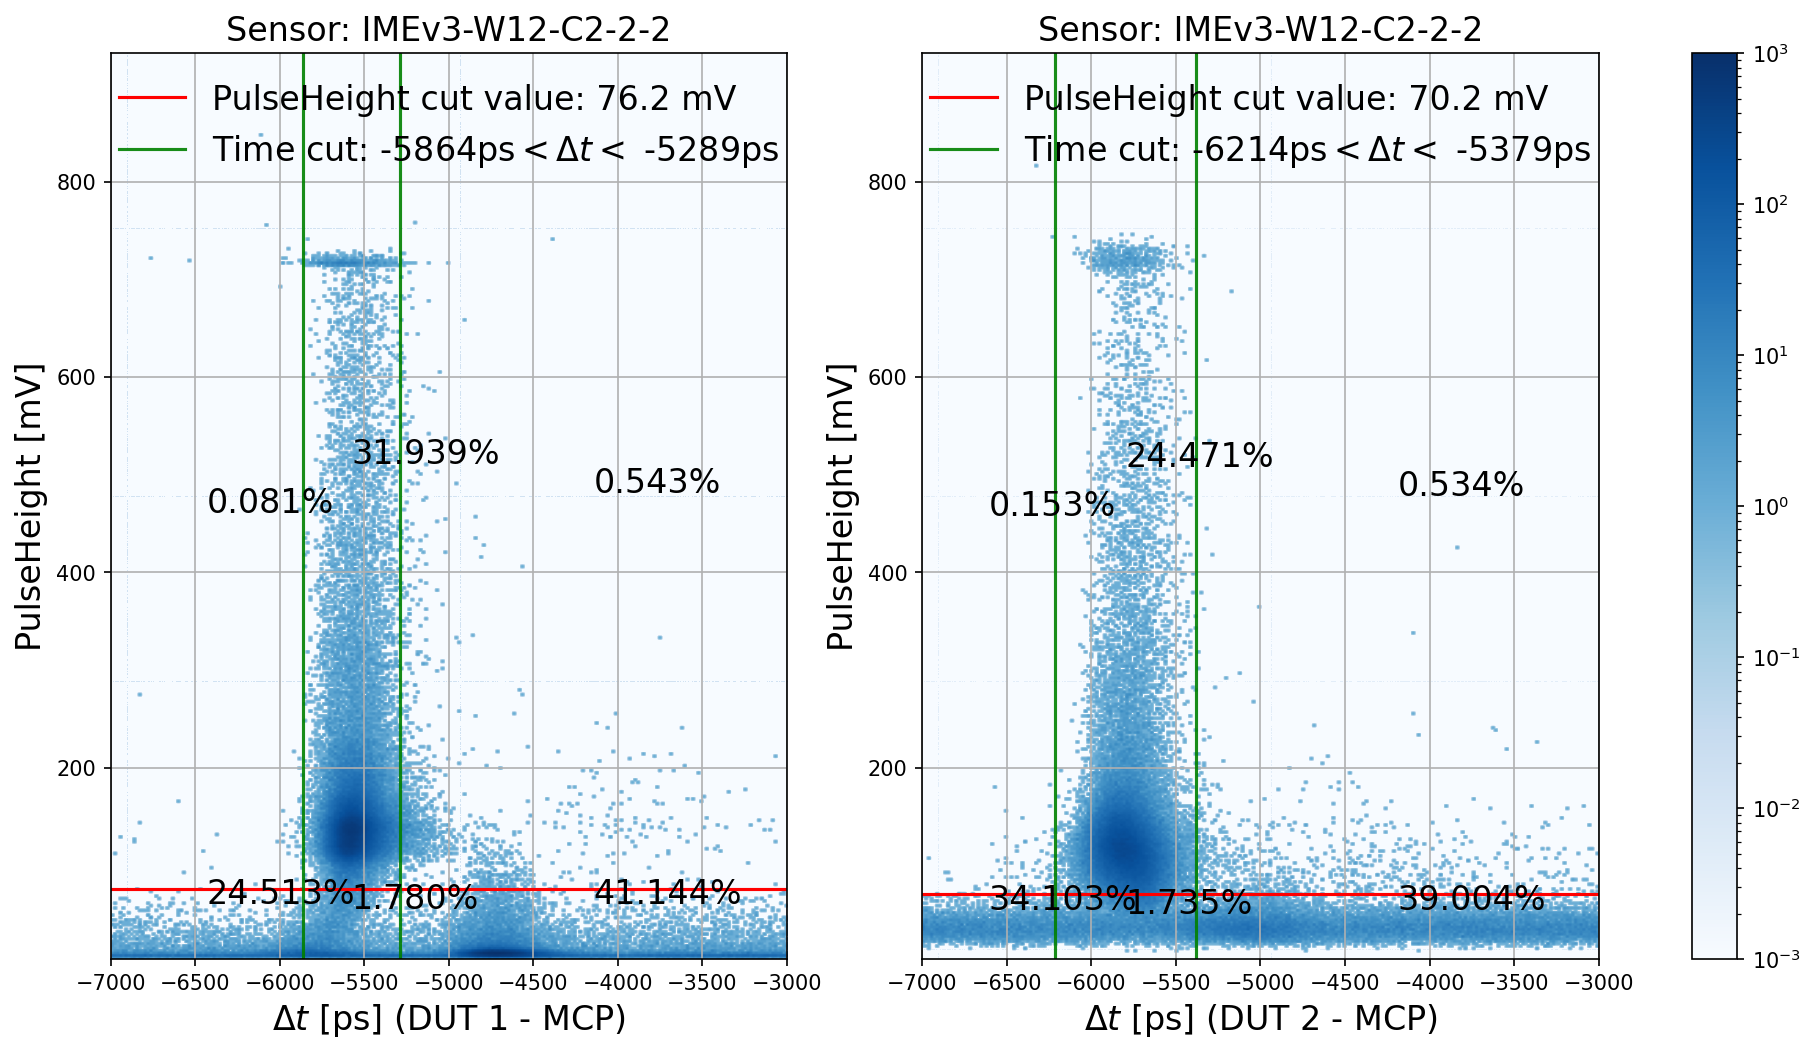

In [45]:
this_scope='S1'
# xlim = (-10e3,0)
xlim = (-7e3,-3e3)

fig, axes = plt.subplots(figsize=(8*len(DUTs),8), ncols=len(DUTs), dpi=150, subplot_kw={'projection':'scatter_density'})#, sharey=True )
for i,dut in enumerate(DUTs):

    info = time_mask(df[this_scope], dut, bins=10000, plot=False)[1]
    left_base, right_base = info['left_base'], info['right_base']
    
    pulse_cut = mins[this_scope][dut]
    time_array = np.array(df[this_scope][f'timeCFD50_{dut}']-df[this_scope][f'timeCFD20_0'])
    pulseheight_array = np.array(df[this_scope][f'pulseHeight_{dut}'])
#     axes[i].plot(time_array, pulseheight_array, '.', markersize=1.8, alpha=0.1)
    im = axes[i].scatter_density(time_array, pulseheight_array, cmap='Blues', norm=colors.LogNorm(vmin=1e-3, vmax=1e3, clip=True))
    
    axes[i].set_xlim(xlim)
    ylim = axes[i].get_ylim()
    axes[i].set_ylim(ylim[0],ylim[1]*1.1)  ### to leave space for the legend
    
    total = len(time_array)/100  ### so I get percentage directly
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array<left_base, pulseheight_array<pulse_cut)])/total)+"%", ((xlim[0]+left_base)/2, pulse_cut-15), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array>right_base, pulseheight_array<pulse_cut)])/total)+"%", ((right_base+xlim[1])/2, pulse_cut-15), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(np.logical_and(time_array>left_base, time_array<right_base), pulseheight_array<pulse_cut)])/total)+"%", ((right_base+left_base)/2, pulse_cut-20), fontsize=16)

    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array<left_base, pulseheight_array>pulse_cut)])/total)+"%", ((xlim[0]+left_base)/2, (pulse_cut+ylim[1])/2), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array>right_base, pulseheight_array>pulse_cut)])/total)+"%", ((right_base+xlim[1])/2, (pulse_cut+ylim[1])/2+20), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(np.logical_and(time_array>left_base, time_array<right_base), pulseheight_array>pulse_cut)])/total)+"%", ((right_base+left_base)/2, (pulse_cut+ylim[1])/2+50), fontsize=16)

    axes[i].axhline(pulse_cut,color='r', label="PulseHeight cut value: %.1f mV"%pulse_cut)
    axes[i].axvline(left_base, color='g', alpha=.9, label="Time cut: %.0fps$<\Delta t<$ %.0fps"%(left_base, right_base))
    axes[i].axvline(right_base, color='g', alpha=.9)
    axes[i].set_xlabel(f"$\Delta t$ [ps] (DUT {dut} - MCP)", fontsize=16)
    axes[i].set_ylabel(f"PulseHeight [mV]", fontsize=16)
    axes[i].grid('-')
    axes[i].legend(fontsize=16, loc='upper center', framealpha=0)
    axes[i].set_title(f"Sensor: {dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch{dut+1}').name}", fontsize=16)
    
for ax in axes:
    ax.sharey(axes[0])
    
cb = fig.colorbar(im, ax=axes)
# fig.savefig(f"../various plots/pulseHeight_vs_deltat_{this_batch}_{this_scope}_{DUTs}.png") ### svg is way too big

#### PLOT ALL BATCHES (might be slow, can be done in parts)
I don't think this is a good thing to do, I should just save all the results while I do them

In [ ]:
# threshold_charge = 4

# ### SAVE THE PLOTS FOR ALL BATCHES
# binning_method = 'rice'
# RUN_ALL_BATCHES = False  ### so I don't accidentally run this
# if RUN_ALL_BATCHES:
#     for S in ["S1","S2"]: ### the two scopes
#         if S=="S2": continue
#         for this_batch in np.sort(list(dict_of_runs[S].keys())):  ### I sort them so I can restart from the batch I want
#             if this_batch>=0:# and this_batch<=500:
#                 print("Batch: ", this_batch)
#                 dir_path = f"../Data_TestBeam/2023_May/{S}/"
#                 file_path = f"tree_May2023_{S}_{this_batch}.root"    
#                 try:
#                     df = root_to_df(os.path.join(dir_path, file_path), branches)
#                 except:
#                     print("something wrong reading the file")
#                     continue
#                 df = df.drop(columns=columns_to_remove)
# #                 plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins,
#         #              savefig=True, savefig_details=f'_{S}')
# #                 plot(df,"1D_Tracks", dict_of_batches[this_batch], S, bins=large_bins,
#     #                  savefig=True, savefig_details=f'_{S}')
#         #         bins = 1000
# #                 plot(df, "pulseHeight", dict_of_batches[this_batch], S, bins=bins,
#         #             savefig=True, savefig_details=f"_{S}_bins_{bins}")
# #                 plot(df, '2D_Sensors', dict_of_batches[this_batch], S,
# #                      bins=large_bins, bins_find_min=binning_method, savefig=False, savefig_details=f'_{S}_large_bins')#_{binning_method}')
# #                 plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='normal',
# #                     bins=large_bins, bins_find_min=binning_method, savefig=True, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC_large_bins')
# #                 plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut='normal',
# #                     bins=large_bins, bins_find_min=binning_method, savefig=True, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC_large_bins')
#             ### I think something is leaking memory!!!
#             plt.close('all') ### I think this worked. maybe not actually


## Plot a single run

DUT_1


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying


DUT_2


[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 Two PEAKS not found after 20 iterations
[INFO] - 	 : {info_peaks}
[WARNING] - 	 in '2D_Sensors', No minimum found, no 2D plot

DUT_3


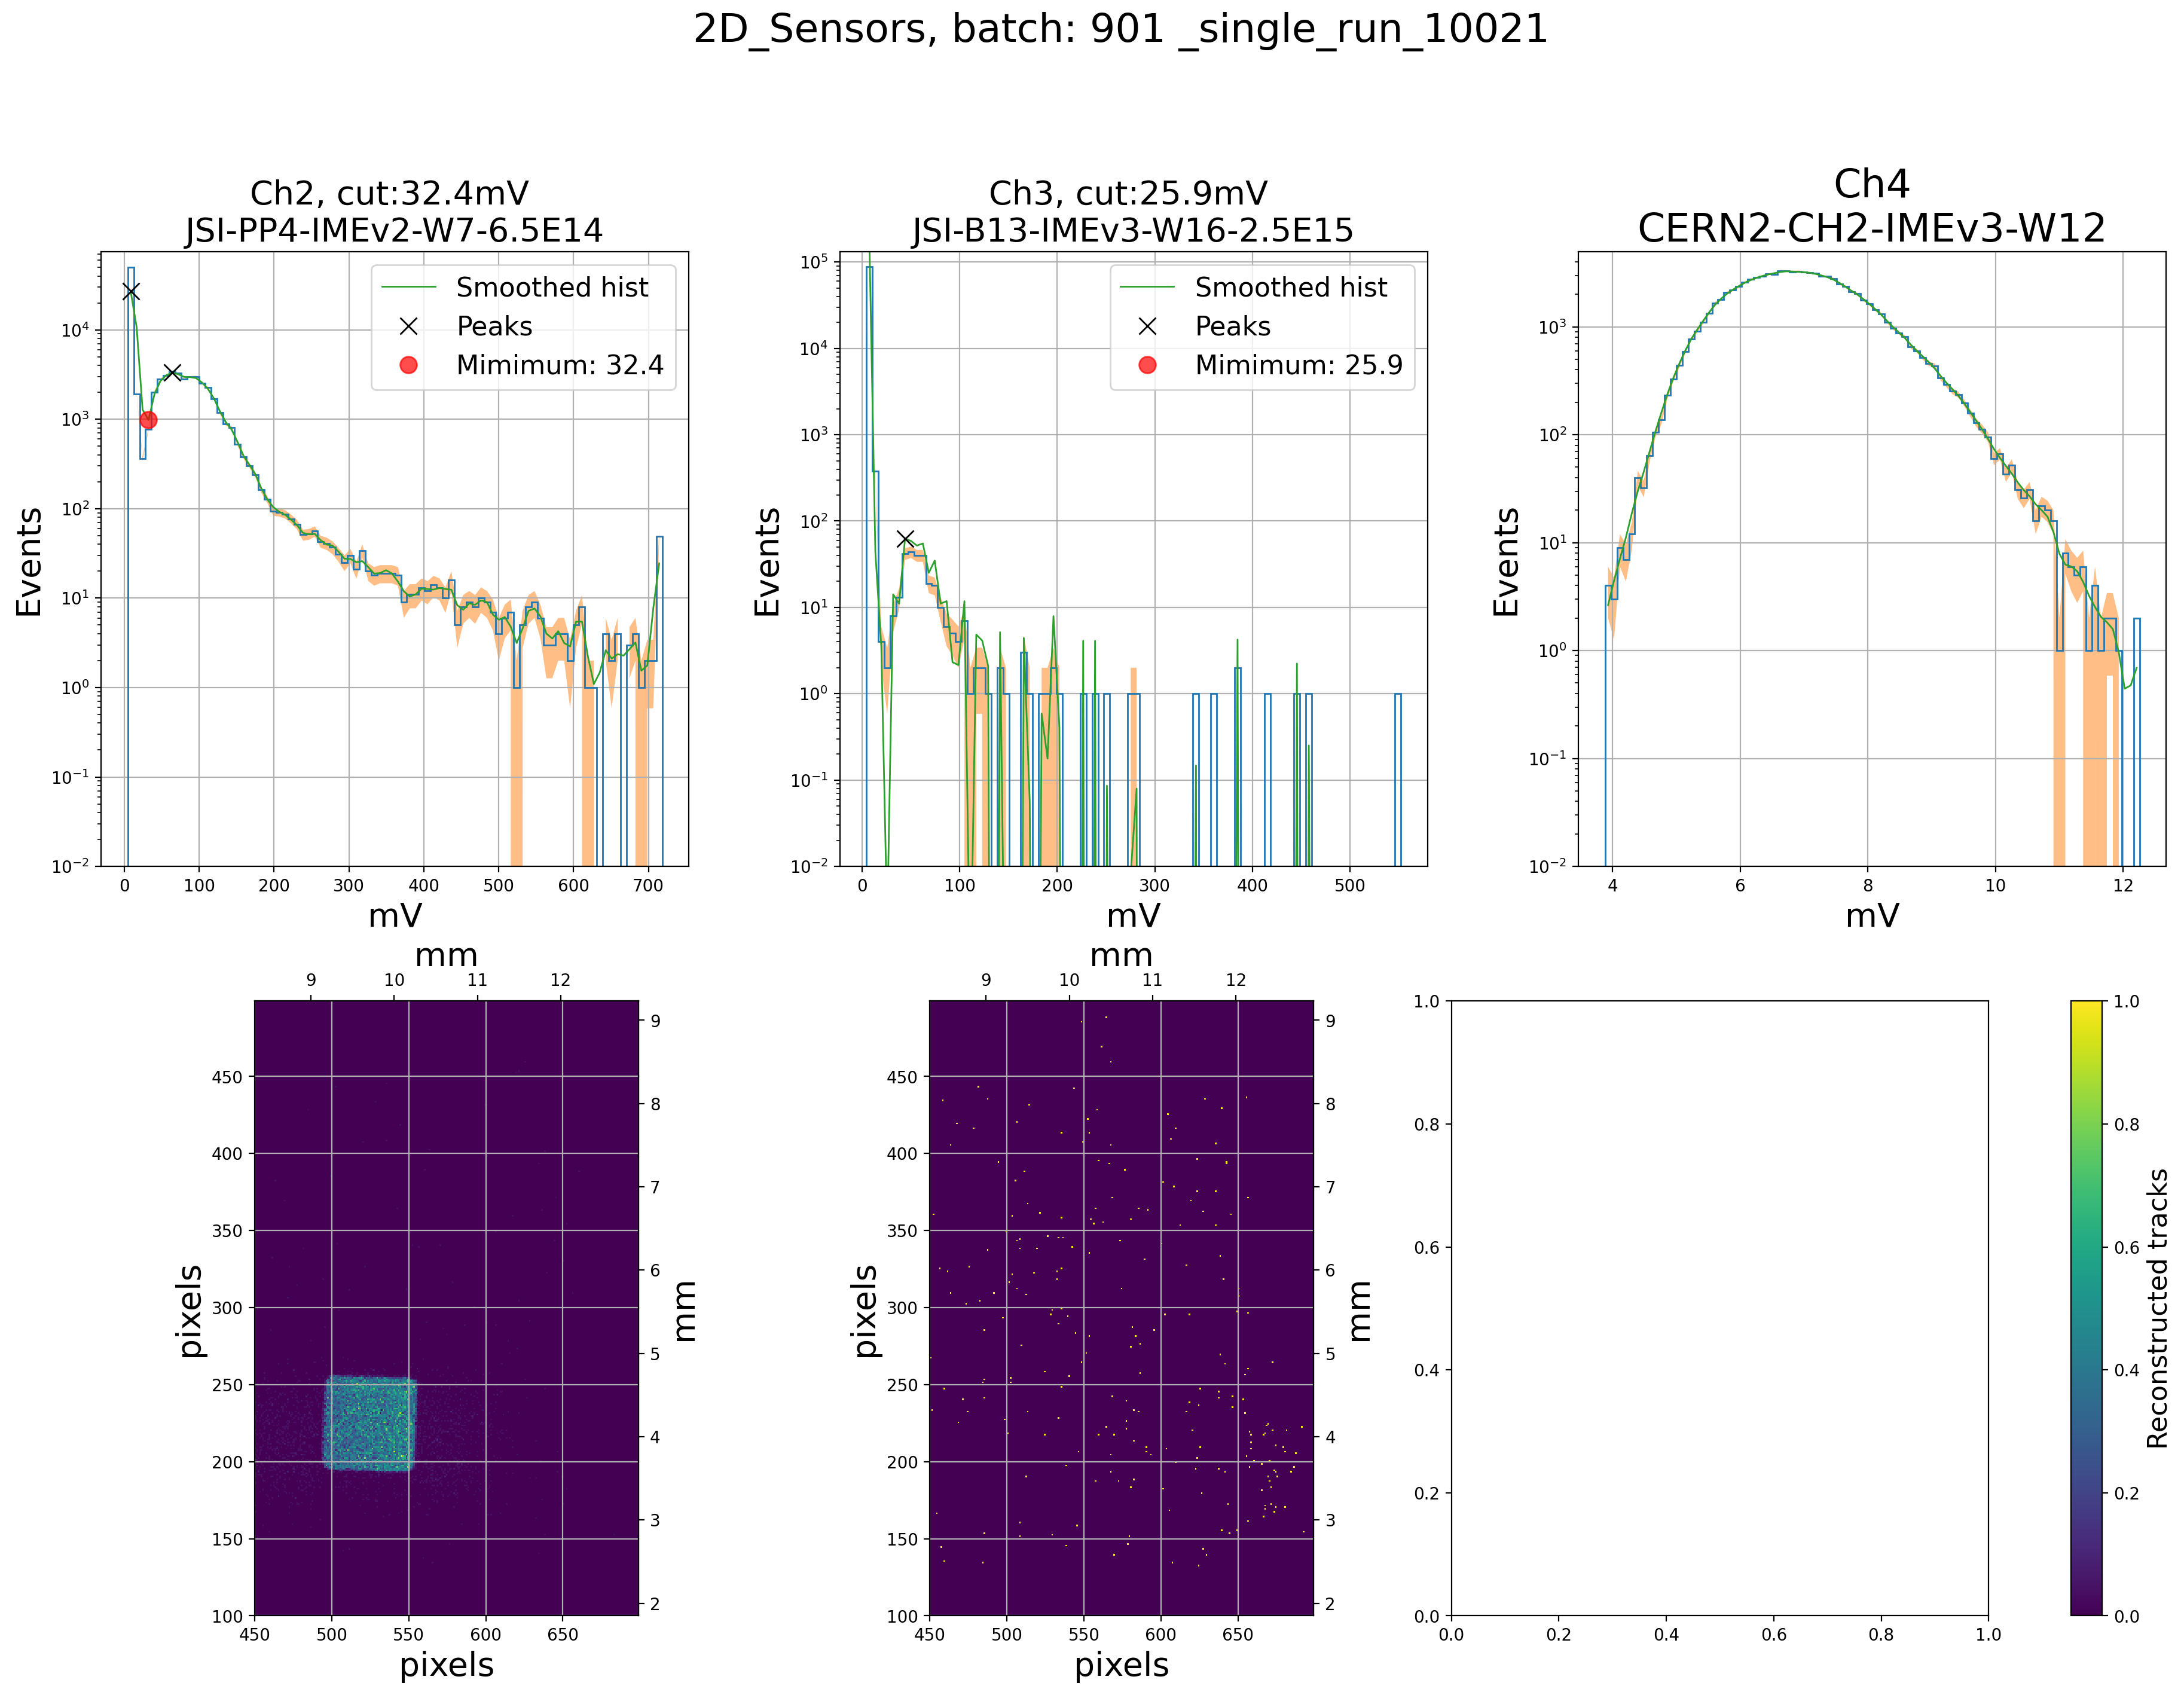

(<Figure size 3600x2400 with 7 Axes>,
 array([[<AxesSubplot:title={'center':'Ch2, cut:32.4mV \nJSI-PP4-IMEv2-W7-6.5E14'}, xlabel='mV', ylabel='Events'>,
         <AxesSubplot:title={'center':'Ch3, cut:25.9mV \nJSI-B13-IMEv3-W16-2.5E15'}, xlabel='mV', ylabel='Events'>,
         <AxesSubplot:title={'center':'Ch4\nCERN2-CH2-IMEv3-W12'}, xlabel='mV', ylabel='Events'>],
        [<AxesSubplot:xlabel='pixels', ylabel='pixels'>,
         <AxesSubplot:xlabel='pixels', ylabel='pixels'>, <AxesSubplot:>]],
       dtype=object))

In [15]:
### looking at single runs 
dir_path = f"../Data_TestBeam/2023_May/S1/"
run = 10021
# file_path = f"tree00{run}.root"
file_path = f"tree0{run}.root"
df_run = root_to_df(os.path.join(dir_path, file_path), branches)
df_run = df_run.drop(columns=columns_to_remove)
    
plot(df_run,"2D_Sensors", dict_of_batches[901], this_scope='S1', bins=bins,
    savefig=False, savefig_details=f"_single_run_{run}")
# plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins)

## Improved efficiency study

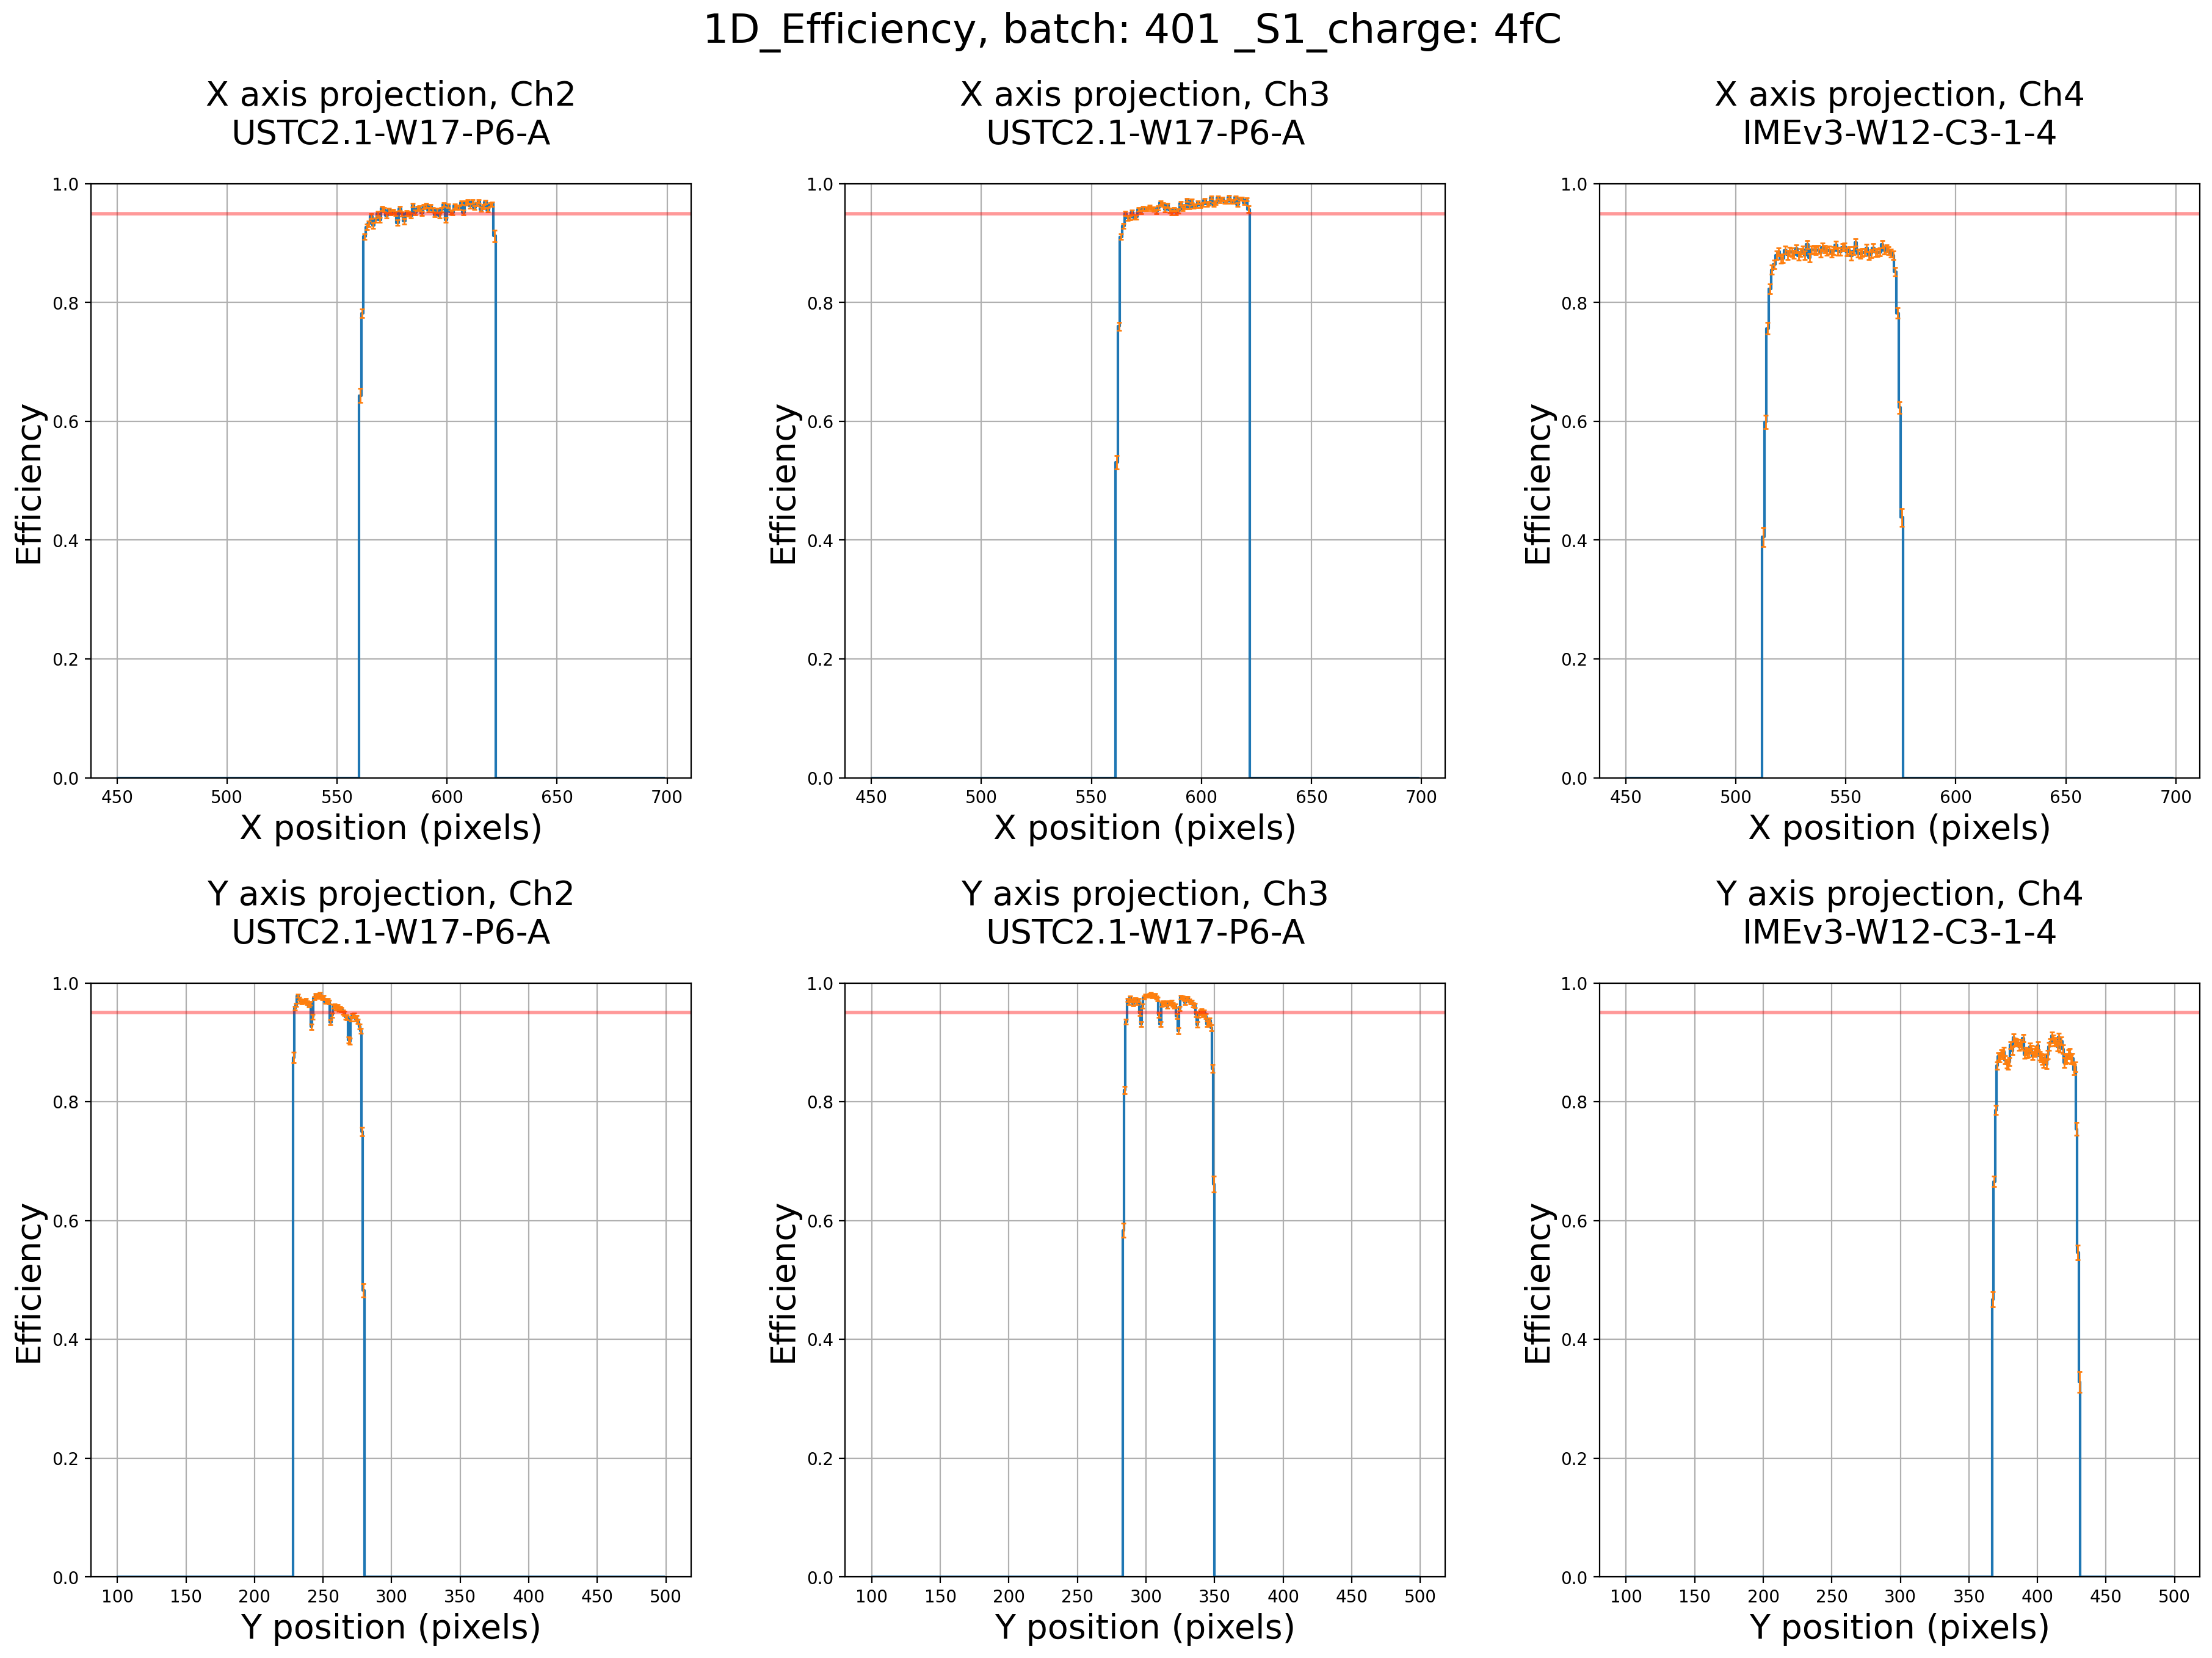

(<Figure size 3600x2400 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'X axis projection, Ch2\nUSTC2.1-W17-P6-A'}, xlabel='X position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'X axis projection, Ch3\nUSTC2.1-W17-P6-A'}, xlabel='X position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'X axis projection, Ch4\nIMEv3-W12-C3-1-4'}, xlabel='X position (pixels)', ylabel='Efficiency'>],
        [<AxesSubplot:title={'center':'Y axis projection, Ch2\nUSTC2.1-W17-P6-A'}, xlabel='Y position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'Y axis projection, Ch3\nUSTC2.1-W17-P6-A'}, xlabel='Y position (pixels)', ylabel='Efficiency'>,
         <AxesSubplot:title={'center':'Y axis projection, Ch4\nIMEv3-W12-C3-1-4'}, xlabel='Y position (pixels)', ylabel='Efficiency'>]],
       dtype=object))

In [20]:
this_scope = "S1"
threshold_charge = 4
plot(df[this_scope], "1D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, geometry_cut='normal', n_DUT=[1,2,3],
                 threshold_charge=threshold_charge,
                 savefig=False, savefig_details=f'_{this_scope}_charge: {threshold_charge}fC')

# fig.savefig("../various plots/1D_Efficiency_410_S1_charge: 2fC.svg")

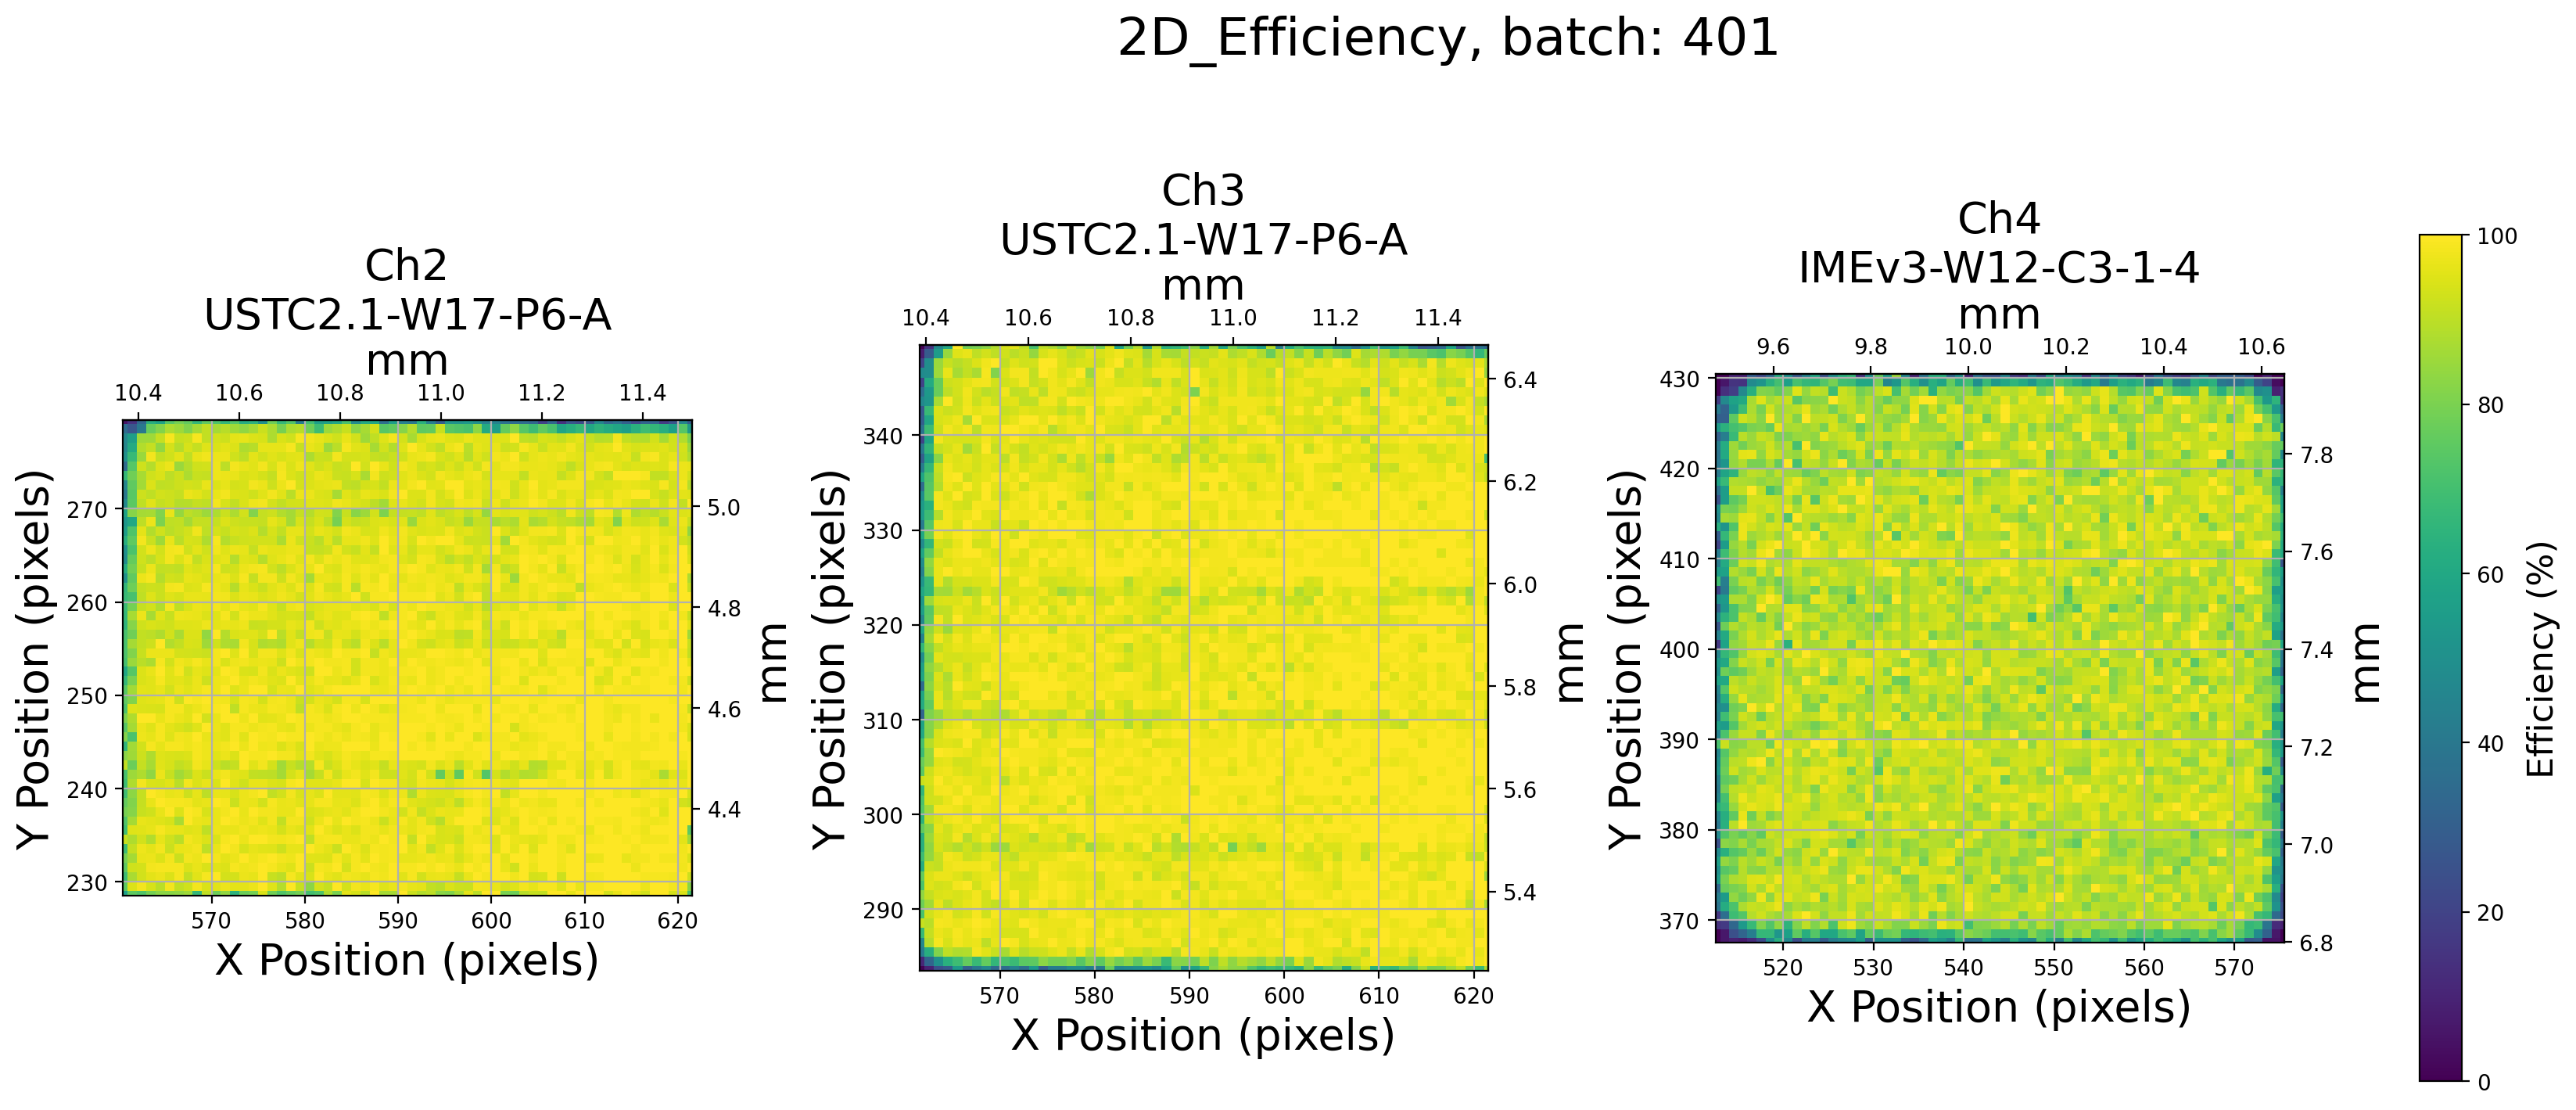

In [23]:
fig, axes = plot(df[this_scope], "2D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, geometry_cut='normal', zoom_to_sensor=True,
                 n_DUT=[1,2,3], threshold_charge=threshold_charge, savefig=False)

In [ ]:
# print(sensors_list[this_batch][this_scope]['Ch2'])
# print(dict_of_batches[this_batch].S[this_scope].channels['Ch2'].name)

In [ ]:
# fig, ax = plot(df[this_scope], "2D_Tracks",batch=this_batch, bins=large_bins)
# fig.suptitle("2D_Tracks, batch: 410", y=0.95)
# # fig

## Efficiency Study

In [ ]:
### bin per bin efficiency
threshold_charge = 4 #fC
# transimpedance = dict_of_batches[this_batch].S[this_scope].channels[]

fig,axes = plot(df[this_scope], "2D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, geometry_cut=False,
                threshold_charge=threshold_charge, savefig=False, savefig_details=" (no cut)")
# fig

### plotting where the noise is
aka where pulseHeight<mins.
This shows how 'good' cutting the PulseHeight is, so where the events that have pulseHeight<mins lie

In [ ]:
# this_scope = "S2"
mask = [df[this_scope][f"pulseHeight_{i}"]<mins[this_scope][i] for i in range(1,4)]

fig,axes = plot(df[this_scope], "2D_Tracks", dict_of_batches[this_batch], this_scope, bins=bins, mask=mask)

## Total efficiency with pulseHeight cut

In [ ]:
# this_scope = "S1"
# dut = 1
# transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
# threshold_range = np.arange(0.5, 20, 0.5)

# ### full surface and pulseHeight cut
# efficiency_range = []
# error_range = []
# geometry = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut)[0]
# pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
# for charge in threshold_range:
#     ### efficiency with error
#     efficiency_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,pulseHeight)]/transimpedance[dut-1], charge)[0])
#     error_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,pulseHeight)]/transimpedance[dut-1], charge)[1]) 

# fig, ax = plt.subplots(figsize=(10,6), dpi=150)
# ax.errorbar(threshold_range, efficiency_range, yerr=error_range, marker='.', markersize=3, linewidth=0,
#             elinewidth=1, ecolor='k', capsize=1.5,
#         label=f"Ch{dut+1}, Total tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")

# ax.set_title(f"Total efficiency depending on threshold charge \n \
# on full surface of Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}, batch {this_batch} \n \
# (with pulseHeight cut)")
# ax.set_xlabel("Threshold charge (fC)")
# ax.set_ylabel("Total efficiency")
# ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
# ax.grid('--')
# ax.legend()
# # fig.savefig(f"..\various plots\Total_efficiency_change_{this_batch}_{this_scope}_DUT{dut}_pulseheight_cut.svg")


## Efficiency in the central part 
Calculate the efficiency in the central $0.5x0.5$ $mm^2$

[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 No MIN found after 20 iterations


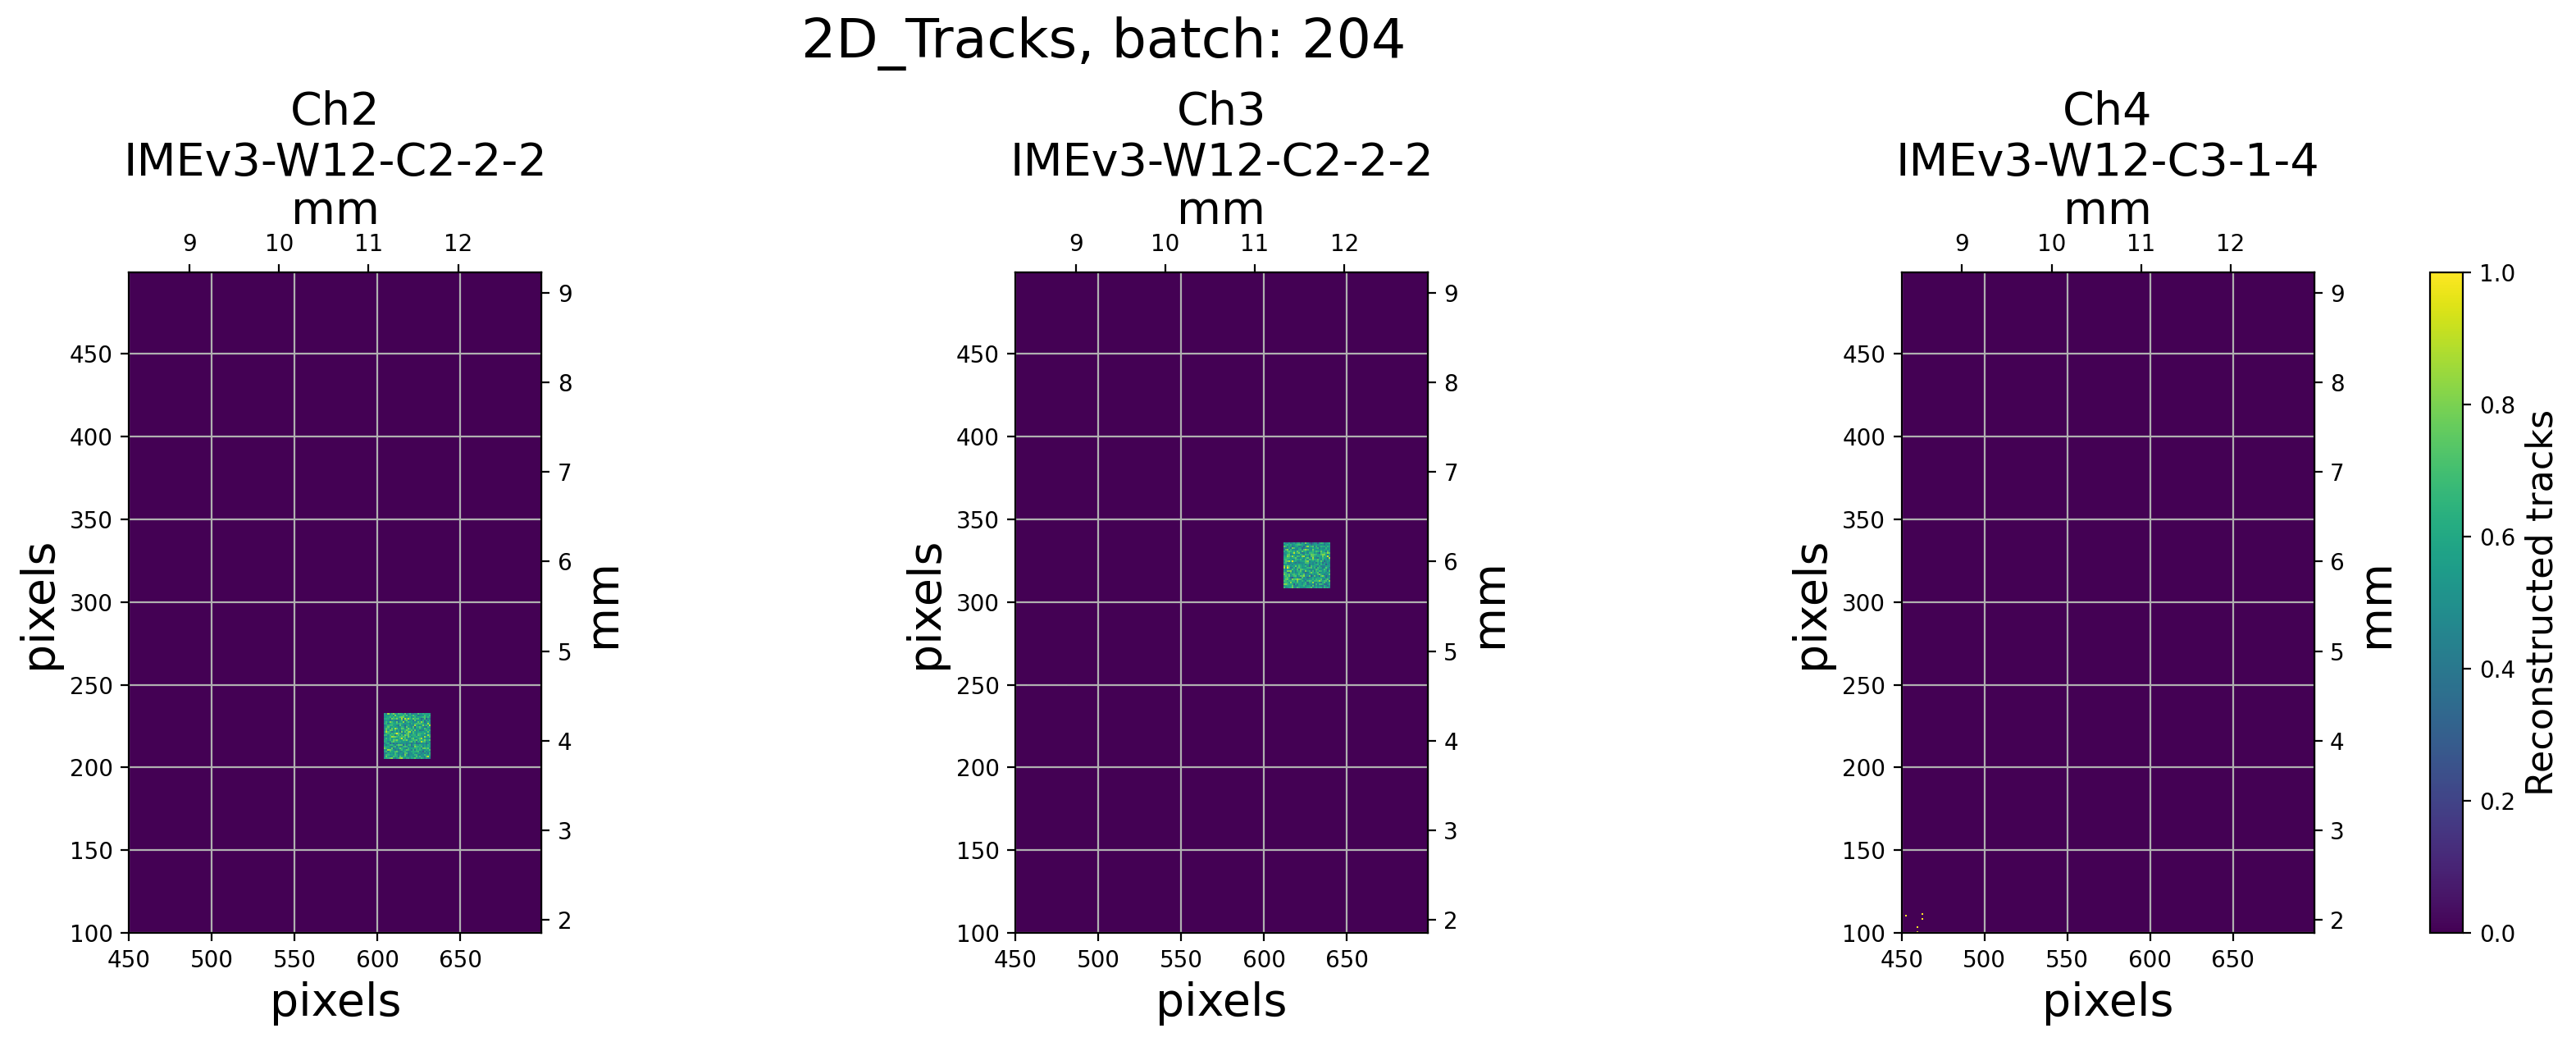

In [47]:
mask = [geometry_mask(df[this_scope], DUT_number=i, bins=bins, bins_find_min='rice', only_select='center')[0] for i in DUTs]

fig,axes = plot(df[this_scope], "2D_Tracks", dict_of_batches[this_batch], this_scope, bins=bins, mask=mask)

[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 No MIN found after 20 iterations


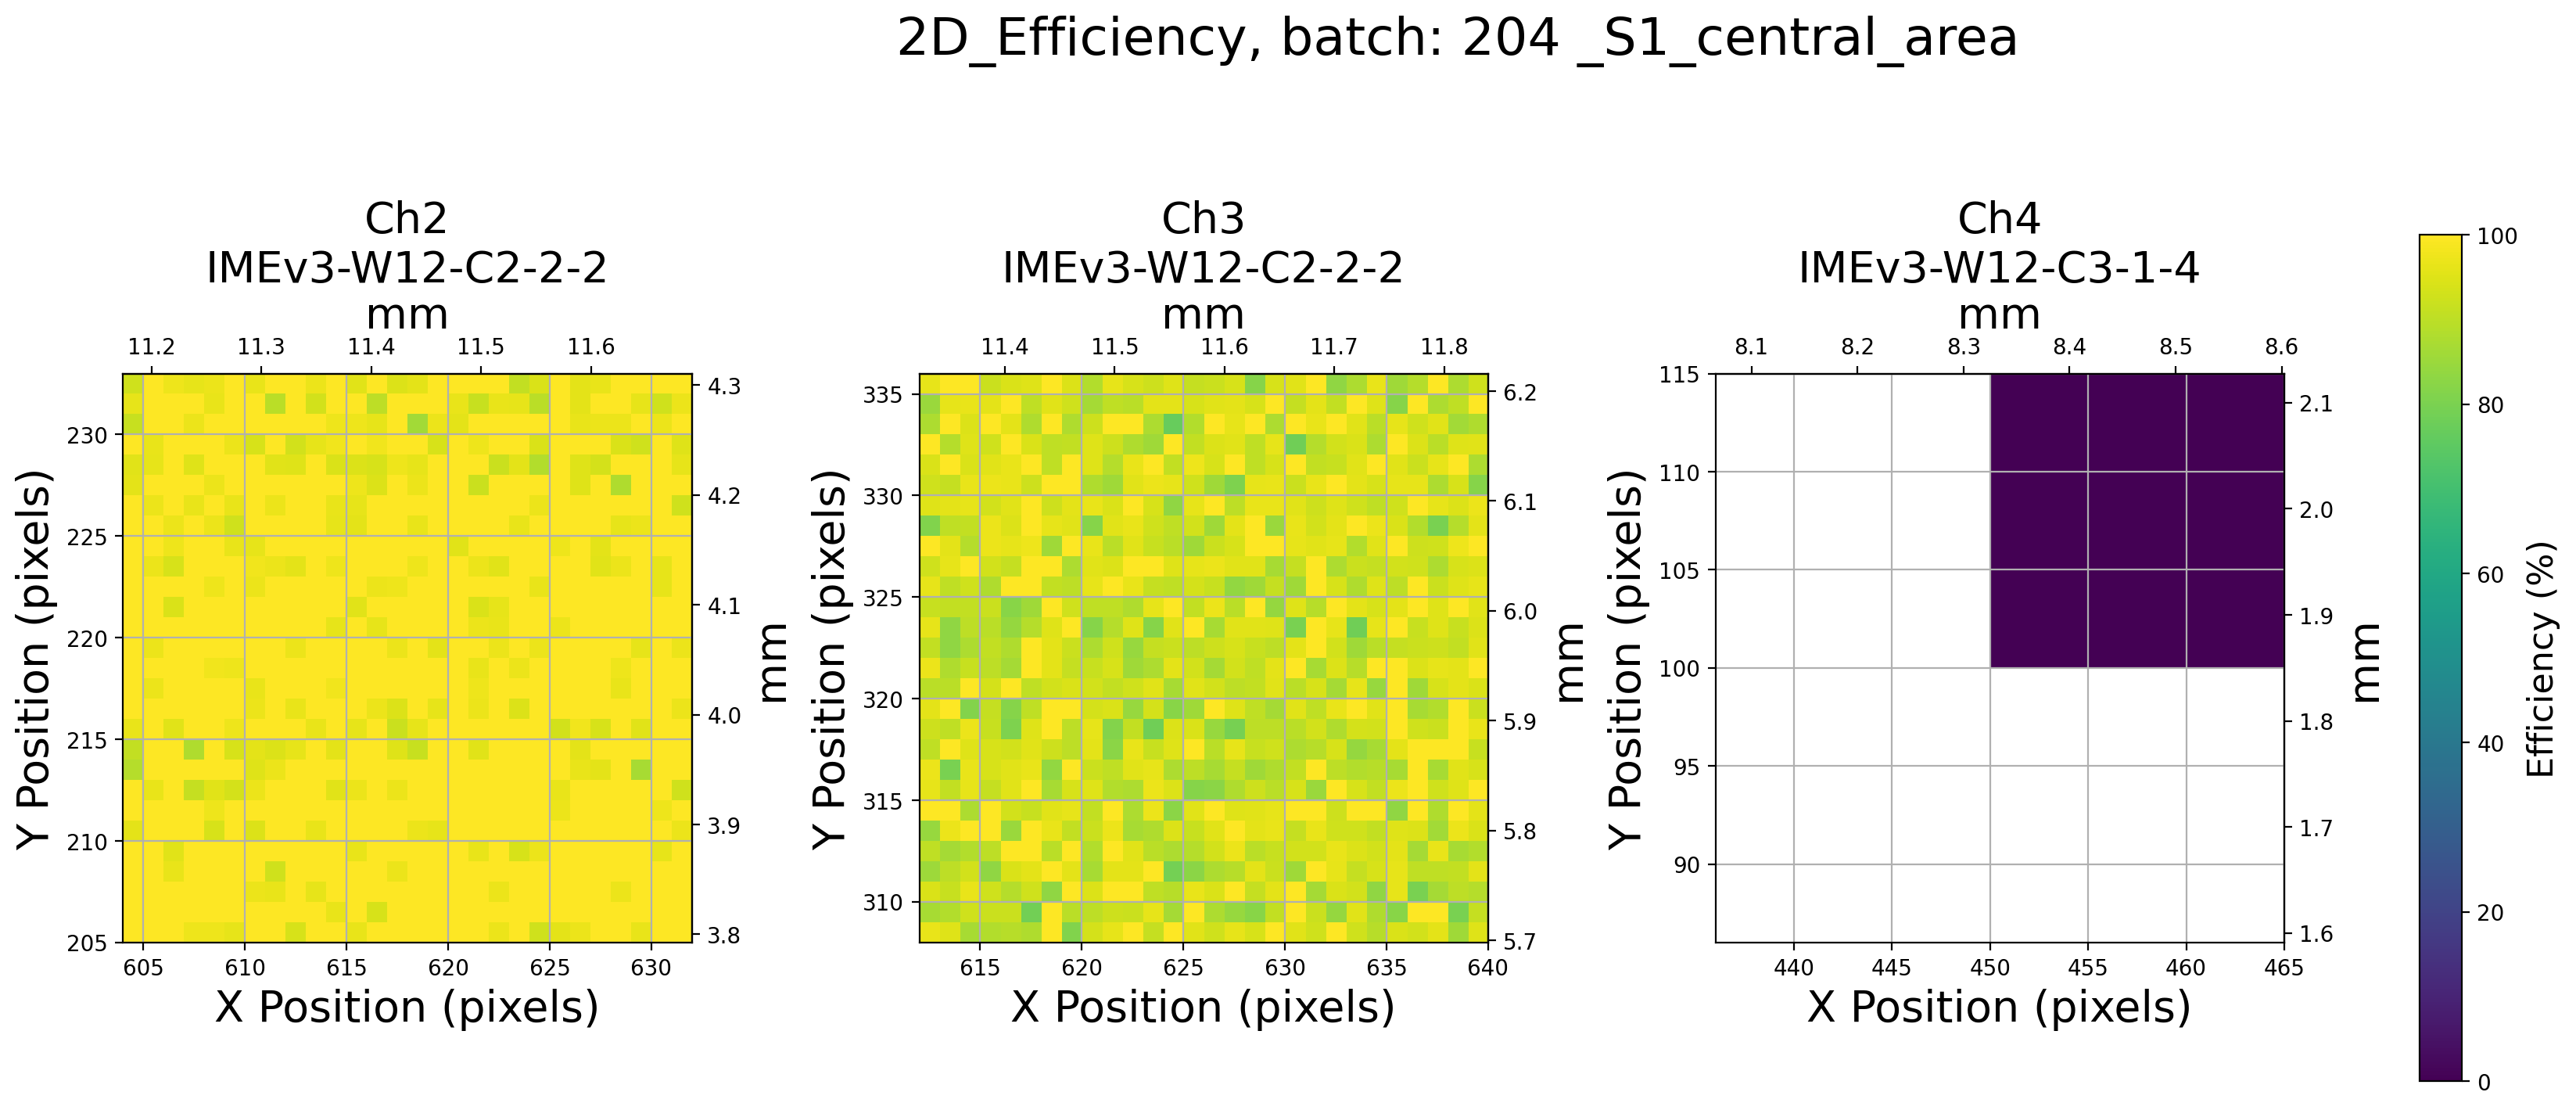

In [48]:
fig, axes = plot(df[this_scope],"2D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, threshold_charge=threshold_charge,
                geometry_cut='center', zoom_to_sensor=True, savefig=False, savefig_details=f"_{this_scope}_central_area")

## Ratio plots

In [ ]:
### THIS IS PLOTTING THE RATIO OF DATA THAT IS LEFT WHEN APPLYIN A PULSEHEIGHT CUT
# this_scope = "S2"

colormap = ['k','b','g','r']

fig, axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2, dpi=300)
fig.tight_layout(w_pad=4, h_pad=4)
ax2 = axes[1].twinx() 
ax2.grid('-', axis='y', color='r')

for dut in range(1,4):
    pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
    hist, my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=10000, label=f"$\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[0]), color=colormap[dut]) ### MCP - CERN1
    axes[0].plot([],[],' ',label=f"Ch{dut+1}: {dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch{dut+1}').name}")
    hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut])/1000, bins=my_bins, label=f"$\Delta$t Ch{dut+1}-Ch1 \n w\ pulseHeigh cut", fig_ax=(fig,axes[1]), linewidth=2, color=colormap[dut])  ### MCP - CERN3
#     time_peak,_ = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10)
    ratio = np.divide(hist_pulse_cut, hist, where = hist!=0)
#     axes[0].stairs(ratio*100, my_bins, alpha=0.5, label='Filtered Ratio', color=colormap[dut])
    ax2.stairs(ratio*100, my_bins, alpha=0.3, label=f"Ratio of events \n (Ch{dut+1}-Ch1)", color=colormap[dut], fill=True)


axes[0].set_title(f"Time difference", fontsize=16)
axes[0].set_xlabel("Time (ns)", fontsize=14)
axes[0].set_ylabel("Events", fontsize=14)
axes[0].set_xlim(-8,-2)
# axes[0].semilogy()

axes[1].set_title("w/ pulseHeight cut (and zoomed)", fontsize=16)
axes[1].set_xlabel("Time (ns)", fontsize=14)
axes[1].set_ylabel("Events", fontsize=14)
axes[1].set_xlim(-6.5,-5)

ax2.set_ylabel("Events(pulse_cut) \ Events (%)", fontsize=14)
ax2.set_ylim(0,100)
ax2.tick_params

axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)
ax2.legend(fontsize=16, loc='right')
fig.suptitle(f"Time difference with ratio plot when pulseHeight cut is applied \
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1.15, fontsize=20)
# fig.savefig(f"../various plots/time_difference{this_batch}_{this_scope}_all_DUTs_with_ratio_plot.svg",bbox_inches='tight')

### New ratio plot
 I apply a pulseHeight cut and then I use __find_peaks__ to find the peaks

In [ ]:
# ### THIS IS PLOTTING THE RATIO OF DATA THAT IS LEFT WHEN APPLYIN A PULSEHEIGHT CUT

# # this_scope = "S2"

# colormap = ['k','b','g','r']
# spec = {'height_ratios':[4,4,1], 'hspace':0.2}   # gridspec keywords arguments
# fig, axes = plt.subplots(figsize=(12,15),nrows=3, ncols=1, gridspec_kw=spec, sharex=True, dpi=300)

# # all_time_cut1 = [None]

# for dut in range(1,4):
#     hist, my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"]),
#                                          bins=10000, fig_ax=(fig,axes[1]), color=colormap[dut], linewidth=0) #,label=f"$\Delta$t Ch{dut+1}-Ch1",) ### MCP - CERN1
#     axes[0].plot([],[],' ',label=f"Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}")
#     if mins[this_scope][dut]:
#         pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
#         hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut]),
#                                                 poisson_err=True, error_band=True, bins=my_bins, color=colormap[dut],
#                                                 fig_ax=(fig,axes[0]), label=f"$\Delta$t Ch{dut+1}-Ch1 \n w/ pulseHeigh cut")  ### MCP - CERN3
#         peaks, info_peaks = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10)
#     else:
#         print(f"DUT: {dut} Try without pulseheight cut")
#         peaks, info_peaks = find_peaks(hist, prominence=np.max(hist)/10)
        
#     left_cut = (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])>my_bins[info_peaks['left_bases'][0]]
#     right_cut = (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])<my_bins[info_peaks['right_bases'][0]]
# #     all_time_cut1.insert(dut, np.logical_and(left_cut, right_cut))
#     time_cut = np.logical_and(left_cut, right_cut)
#     hist_time_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[time_cut]-df[this_scope]["timeCFD50_0"].loc[time_cut]),
#                                            poisson_err=True, error_band=True, bins=my_bins, linewidth=1, color=colormap[dut],
#                                            fig_ax=(fig,axes[1]), label=f"$\Delta$t Ch{dut+1}-Ch1 \n w/ time cut")  ### MCP - CERN3
#     ratio = np.divide(hist_pulse_cut, hist_time_cut, where = hist_time_cut!=0)
#     axes[2].stairs(ratio, my_bins, label=f"Ratio of events \n (Ch{dut+1}-Ch1)", color=colormap[dut])#, fill=True)

    
# axes[0].set_title(f"Time difference", fontsize=16)
# axes[0].set_ylabel("Events", fontsize=14)
# # axes[0].set_xlim(-7,-5)
# axes[0].set_xlim(-7e3,-4e3)
# # axes[0].semilogy()

# axes[2].set_ylabel("Ratio of events", fontsize=14)
# axes[2].set_xlabel("Time (ps)", fontsize=14)

# axes[2].set_title("Events(pulse_cut) / Events(time_cut) in each bin", fontsize=16)

# axes[0].legend(fontsize=16)
# axes[1].legend(fontsize=16)
# axes[2].grid('-')

# fig.suptitle(f"Time difference with ratio plot when pulseHeight cut is applied \
# \n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=20)
# # fig.savefig(f"../various plots/time_difference_pulseheight_cut_time_cut_{this_batch}_{this_scope}_all_DUTs_with_ratio_plot.svg",bbox_inches='tight')

### Try to define the time cut without other info. And fitting the gaussian + background
i.e. when pulseHeight cut (and so geometry cut) are not available

In [14]:
all_time_cut = [time_mask(df[this_scope], bins=5000, DUT_number=i, plot=False)[0] for i in [1,2,3]]

[INFO] - 	 in 'time_mask()': Fit parameters [ 7630.63420735 -5336.84615374    72.43655085   177.16915628]
[INFO] - 	 in 'time_mask()': Fit parameters [13594.05603248 -5633.88529127    67.39934041   160.32762252]
[INFO] - 	 in 'time_mask()': Fit parameters [10009.6248394  -5480.26353965    69.96479503   171.62203658]


In [ ]:
# ### THIS IS PLOTTING THE RATIO OF DATA THAT IS LEFT WHEN APPLYIN A PULSEHEIGHT CUT
# # this_scope = "S2"

# colormap = ['k','b','g','r']
# spec = {'height_ratios':[4,4,1], 'hspace':0.2}   # gridspec keywords arguments

# fig, axes = plt.subplots(figsize=(12,15),nrows=3, ncols=1, gridspec_kw=spec, sharex=True, dpi=300)

# for dut in [1,2]:
#     hist, my_bins,_,_,_ = plot_histogram(df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"],
#                                          bins=10000, color=colormap[dut], linewidth=1,
#                                          fig_ax=(fig,axes[0]))
    
#     axes[0].plot([],[],' ',label=f"Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}")
#     initial_param = (np.max(hist),-5e3,100,100)
#     bins_centers = (my_bins[:-1]+my_bins[1:])/2
#     param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)
#     print(f"Fit parameters: {param}")
#     axes[0].plot(bins_centers, my_gauss(bins_centers,*param), color='k')
#     number_of_sigmas = 5
#     left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
#     axes[0].axvline(left_base, color=colormap[dut])
#     axes[0].axvline(right_base, color=colormap[dut])
#     left_cut = (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"])>left_base
#     right_cut = (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"])<right_base
#     time_cut = np.logical_and(left_cut, right_cut)
#     hist_time_cut,_,_,_,_ = plot_histogram(df[this_scope][f"timeCFD50_{dut}"].loc[time_cut]-df[this_scope]["timeCFD20_0"].loc[time_cut],
#                                            poisson_err=True, error_band=True, bins=my_bins, linewidth=1, color=colormap[dut],
#                                            fig_ax=(fig,axes[1]), label=f"$\Delta$t Ch{dut+1}-Ch1 \n w/ time cut")  ### MCP - CERN3

#     ratio = np.divide(hist_time_cut, hist, where = hist_time_cut!=0)
#     axes[2].stairs(ratio, my_bins, label=f"Ratio of events \n (Ch{dut+1}-Ch1)", color=colormap[dut])#, fill=True)

    
# axes[0].set_title(f"Time difference", fontsize=16)
# axes[0].set_ylabel("Events", fontsize=14)
# axes[0].set_xlim(-6e3,-5e3)
# axes[1].set_xlim(-6e3,-5e3)

# axes[2].set_ylabel("Ratio of events", fontsize=14)
# axes[2].set_xlabel("Time (ns)", fontsize=14)
# axes[2].set_title("Events(time_cut) / Events(no_cut)", fontsize=16)

# axes[0].legend(fontsize=16)
# axes[1].legend(fontsize=16)
# axes[2].grid('-')

# fig.suptitle(f"Time difference with ratio plot when pulseHeight cut is applied \
# \n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=20)

In [16]:
# def my_gauss(x, A, mu, sigma, background):
#     """Custom normal distribution function + uniform background"""
#     return A * np.exp(-0.5*(x-mu)**2/sigma**2) + background

Fit parameters: [ 8339.67156208 -5486.0050166    -80.30473563   169.45099024]
Fit parameters: [ 9448.03291687 -5518.75313278   -78.43360912   168.85239405]
Fit parameters: [ 5870.01887588 -5678.39746392   -80.66143862   181.31029908]


Text(0.5, 1, 'Time difference \n Batch: 401, Oscilloscope: S1')

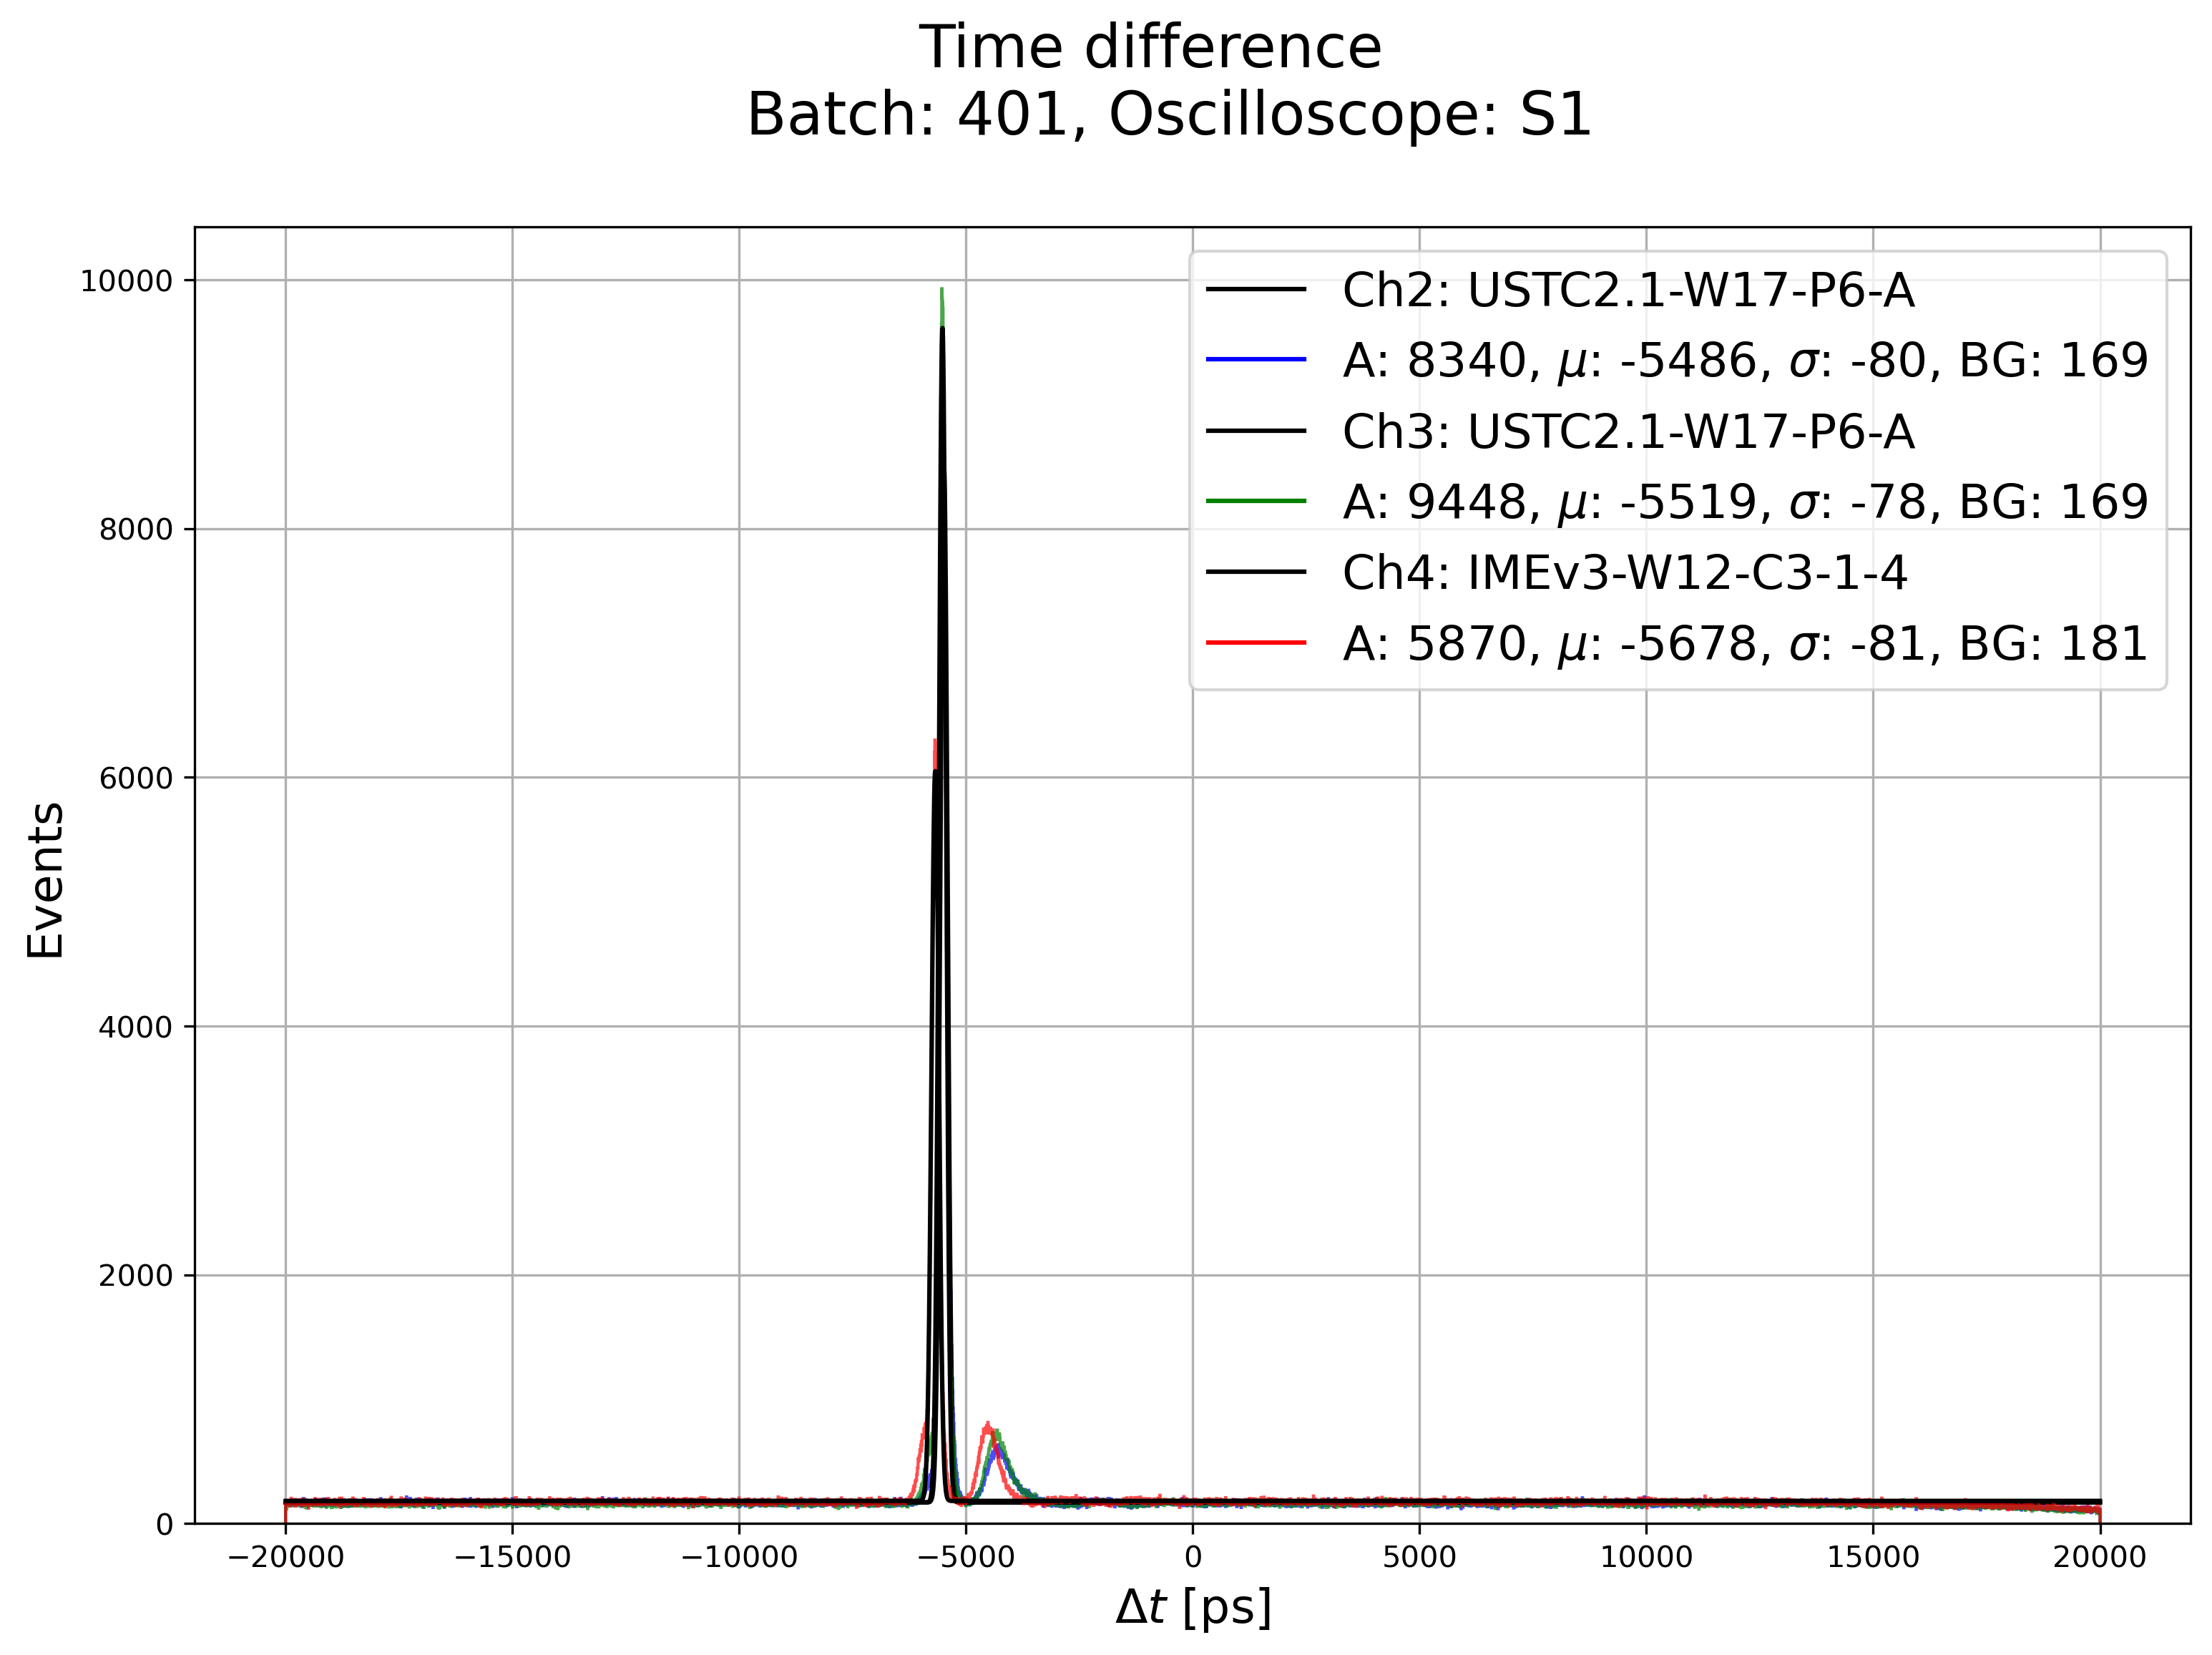

In [25]:
### SAME THING BUT ONLY FIRST PLOT
### now I fit between -15ns < delta t < 15ns
colormap = ['k','b','g','r']

fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, sharex=True, dpi=300)

for dut in [1,2,3]:
    window_fit = np.logical_and((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"])>-2e4,
                               (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"])<2e4)
    
    hist, my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[window_fit]-df[this_scope]["timeCFD20_0"].loc[window_fit]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))
    
#     hist, my_bins,_,_,_ = plot_histogram(df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"],
#                                          bins=10000, color=colormap[dut], linewidth=1, alpha=0.7,
#                                          fig_ax=(fig,axes))
    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],-100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)
    print(f"Fit parameters: {param}")
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color='k',
              label=f"Ch{dut+1}: {dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch{dut+1}').name}")
    number_of_sigmas = 4
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
#     axes.axvline(left_base, color=colormap[dut])
#     axes.axvline(right_base, color=colormap[dut])

    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.0f, BG: %.0f" %(param[0],param[1], param[2], param[3])) # only two decimals
    
axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_ylabel("Events", fontsize=16)
# axes.set_xlim(-10e3,-2e3)

axes.legend(fontsize=16)

fig.suptitle(f"Time difference \
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=20)
# fig.savefig(f"../various plots/time_difference_{this_batch}_{this_scope}_small_range_with_fit.svg")

Text(0.5, 1, 'Time difference \n Batch: 401, Oscilloscope: S1')

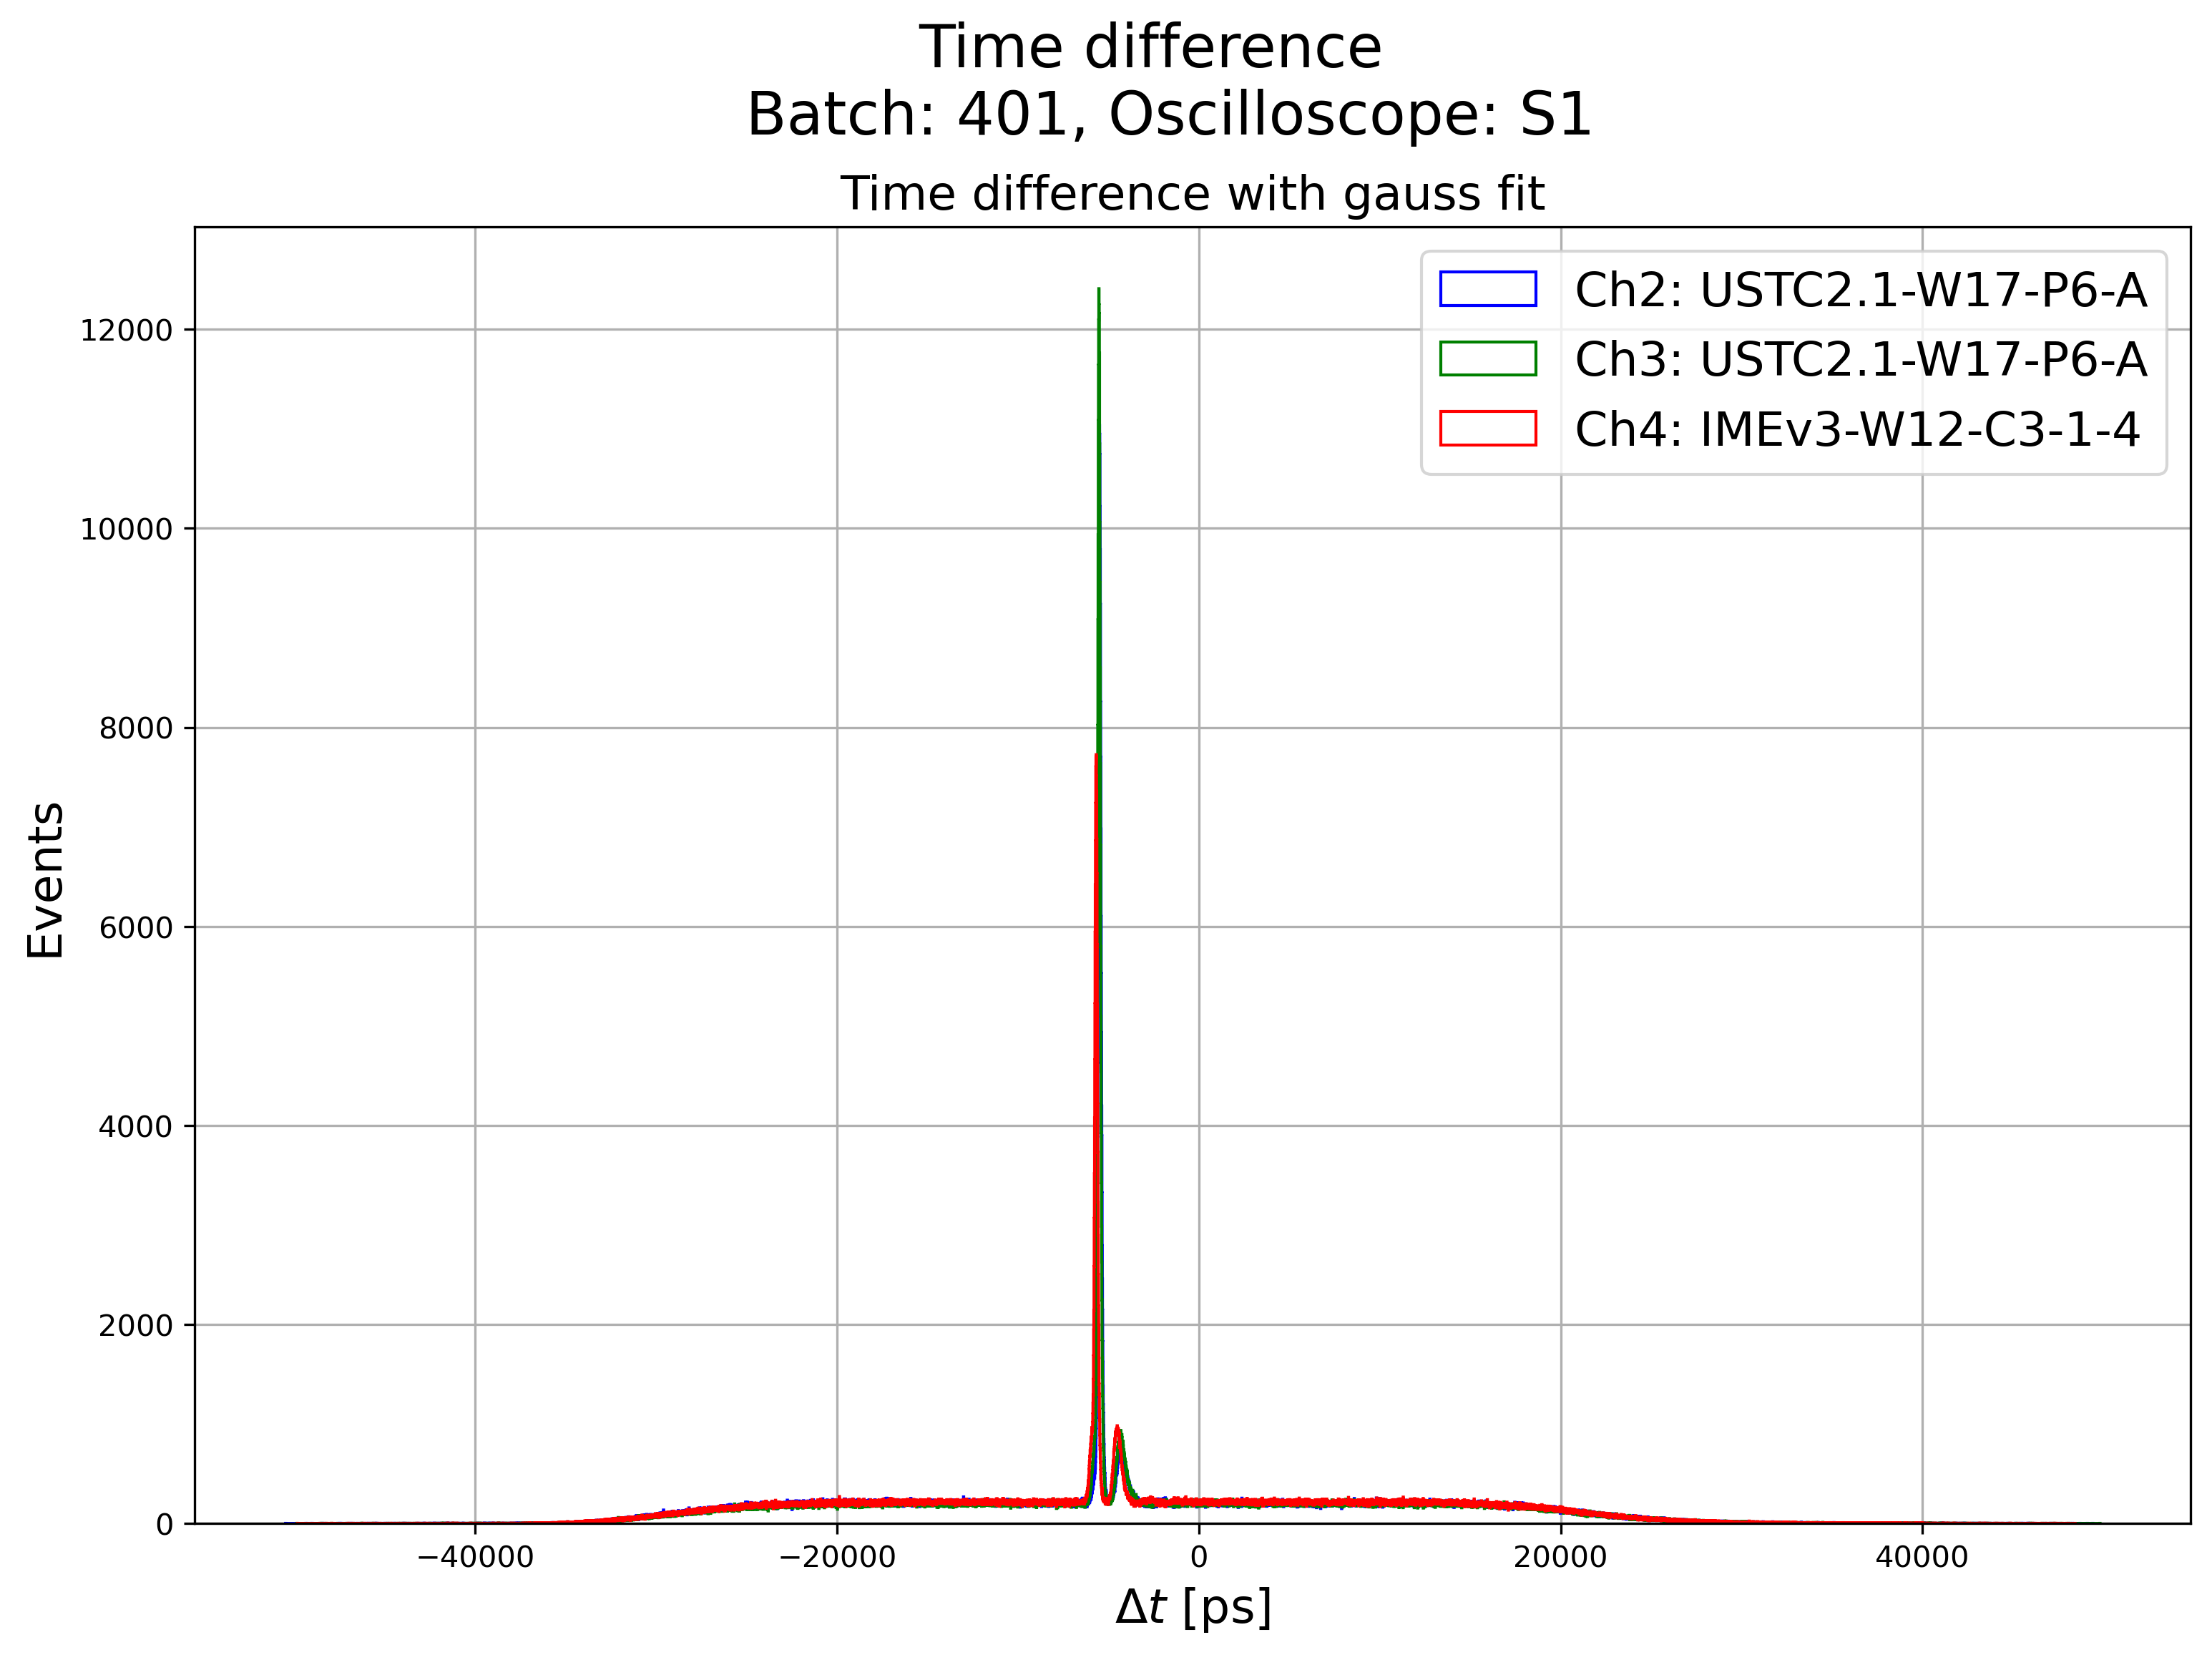

In [26]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, sharex=True, dpi=300)

for dut in [1,2,3]:
    hist, my_bins,_,_,_ = plot_histogram(df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD20_0"],
                                         bins=10000, color=colormap[dut], linewidth=1, label=f"Ch{dut+1}: {dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch{dut+1}').name}",
                                         fig_ax=(fig,axes))
    
    
axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_title(f"Time difference with gauss fit", fontsize=16)
axes.set_ylabel("Events", fontsize=16)
# axes.set_xlim(-10e3,-2e3)

axes.legend(fontsize=16)

fig.suptitle(f"Time difference \
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=20)

[INFO] - 	 in 'time_mask()': Fit parameters [ 2936.31168931 -5678.39054545    80.62052566    90.65609437]


Text(0.5, 1, 'Charge plot with two different cuts, with ratio\n Batch: 401, Oscilloscope: S1')

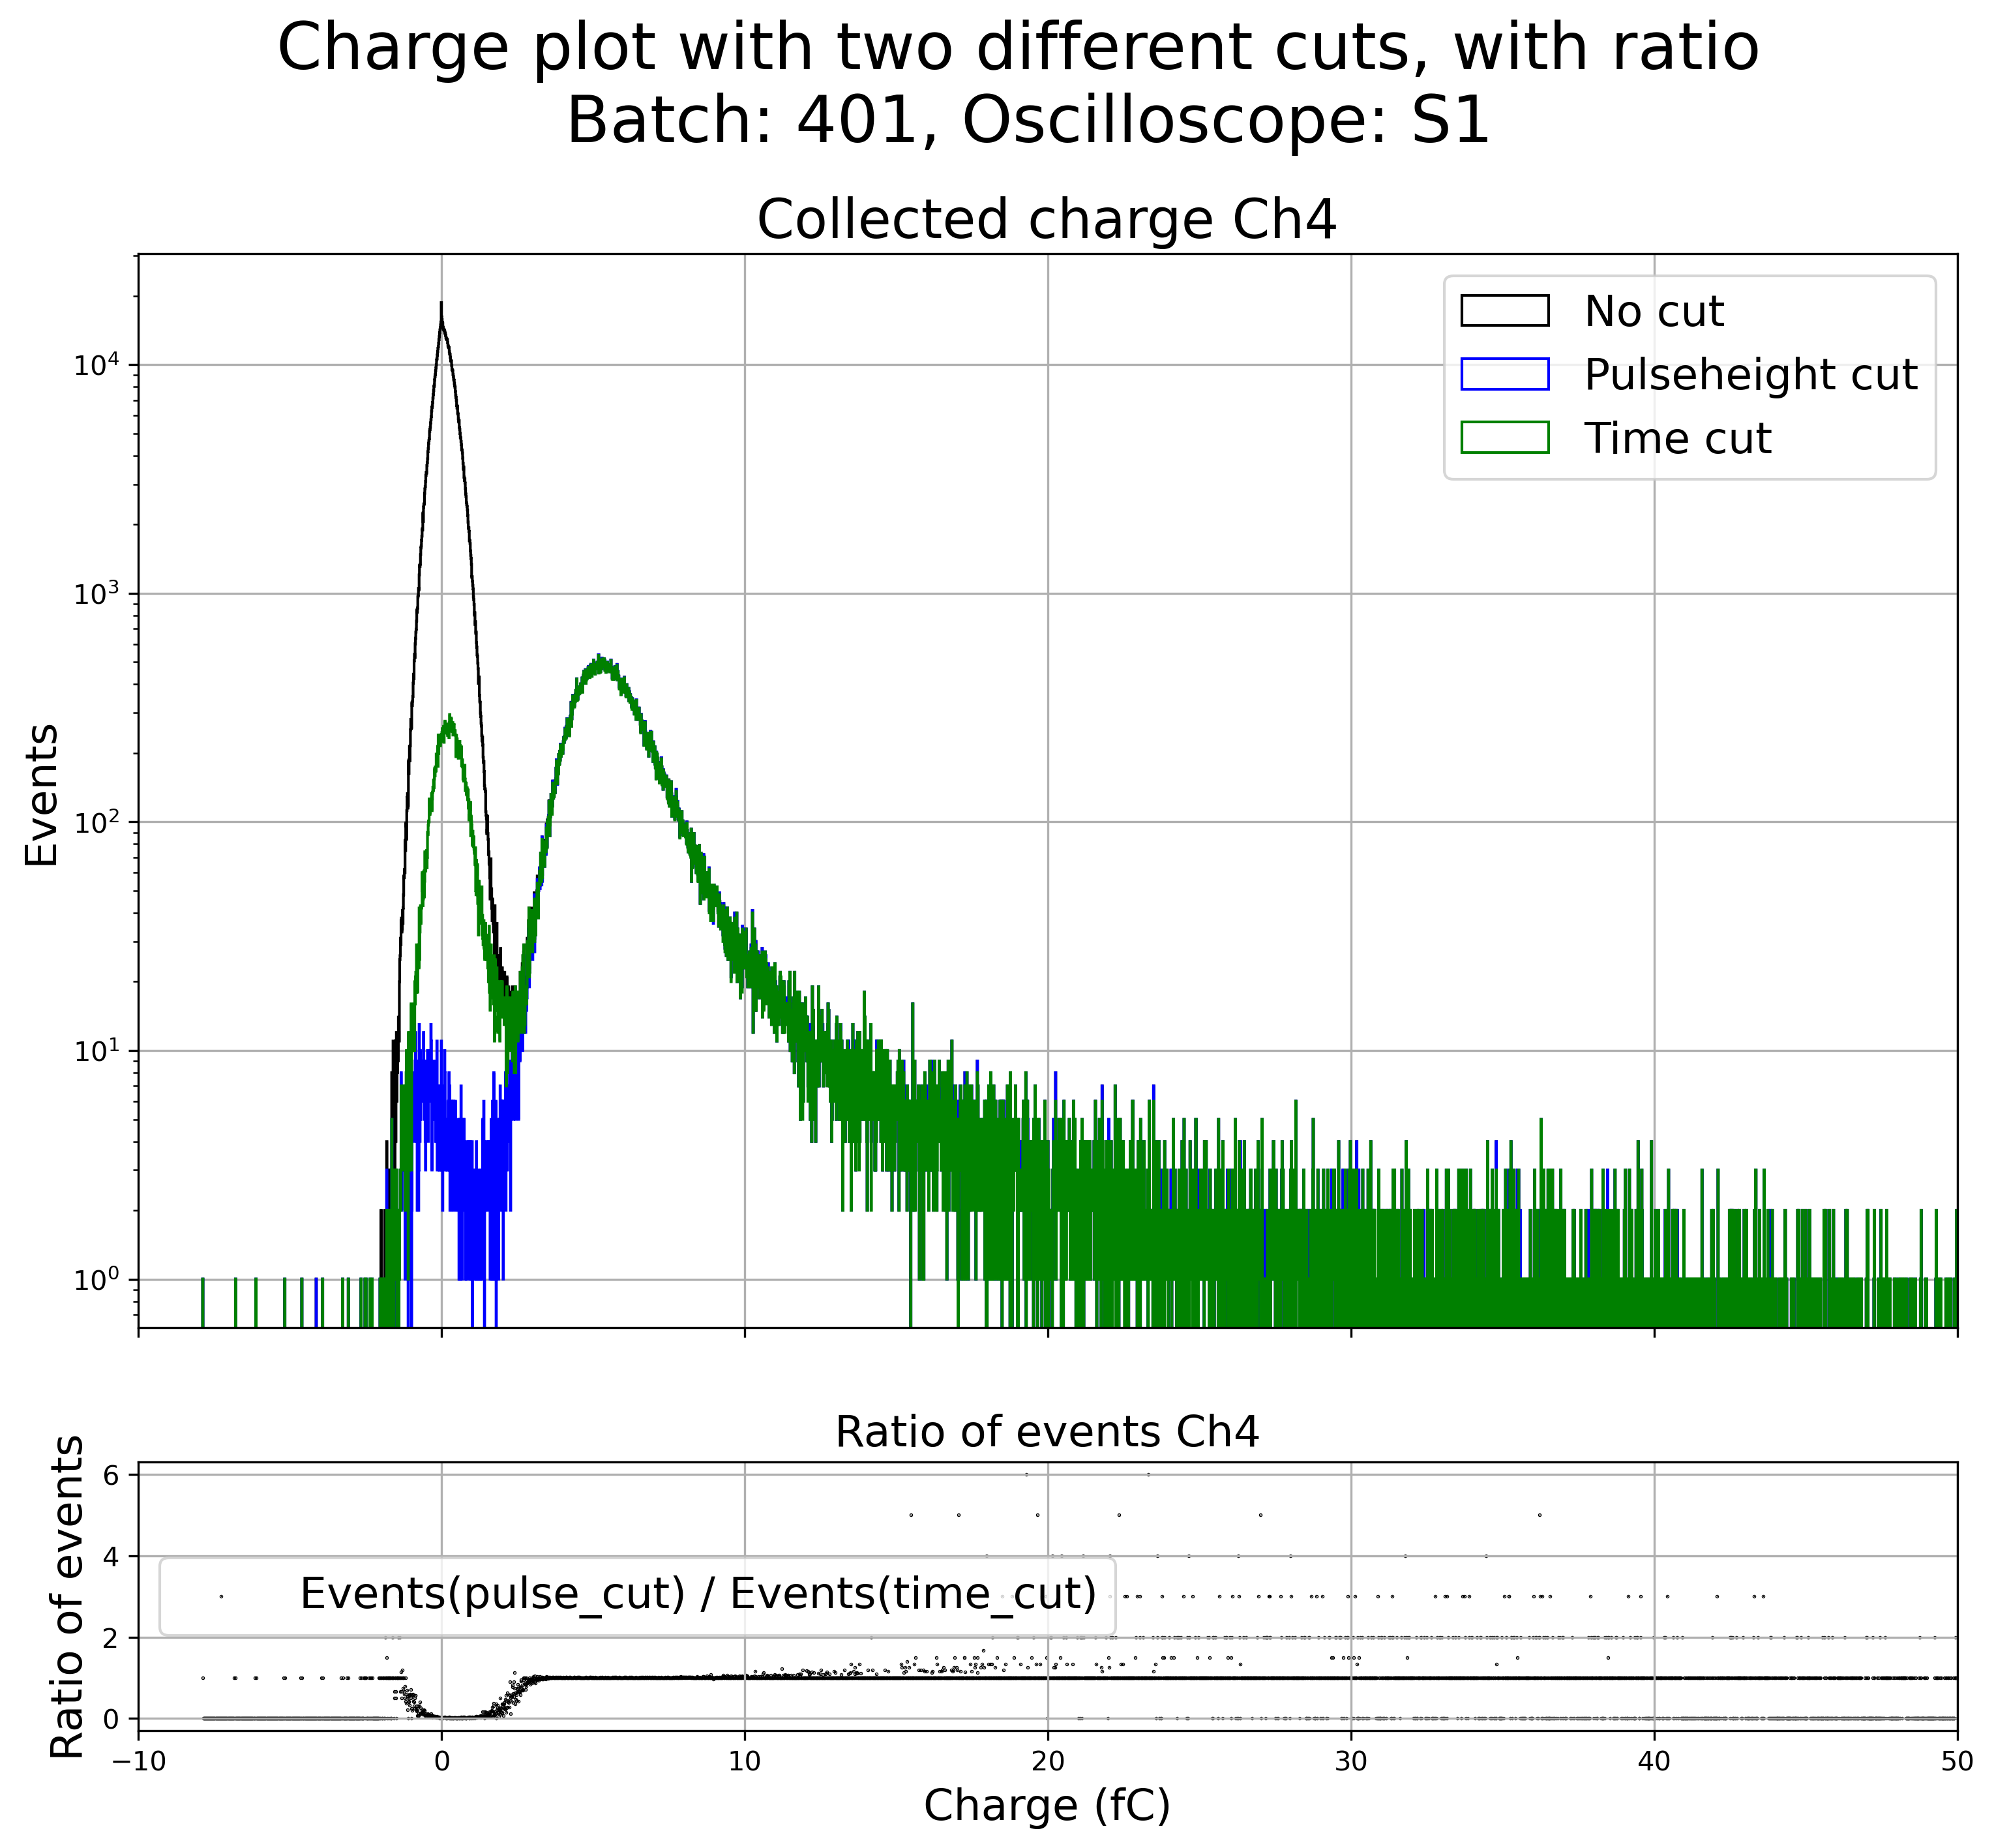

In [27]:
### THIS TIME I'M PLOTTING THE CHARGE INSTEAD OF TIME
# this_scope = "S2"
# transimpedance = get_transimpedance(this_batch,this_scope)
transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in (1,2,3)]

# colormap = ['k','b','g','r']
spec = {'height_ratios':[4,1], 'hspace':0.2}   # gridspec keywords arguments

fig, axes = plt.subplots(figsize=(12,10),nrows=2, ncols=1, gridspec_kw=spec, sharex=True, dpi=300)

# for dut in [1,2]:
dut = 3
hist, bins_charge,_,_,_ = plot_histogram(df[this_scope][f"charge_{dut}"]/transimpedance[dut-1],
                                       bins='auto', linewidth=1, alpha=1, color='k',
                                       fig_ax=(fig,axes[0]), label=f"No cut")  ### MCP - CERN3

pulseheight_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
hist_pulse_cut,_,_,_,_ = plot_histogram(df[this_scope][f"charge_{dut}"].loc[pulseheight_cut]/transimpedance[dut-1],
                                        bins=bins_charge, alpha=1, color=colormap[1],
                                        fig_ax=(fig,axes[0]), label=f"Pulseheight cut")

time_cut = time_mask(df[this_scope], DUT_number=dut, bins=10000, plot=False)[0]
hist_time_cut,_,_,_,_ = plot_histogram(df[this_scope][f"charge_{dut}"].loc[time_cut]/transimpedance[dut-1],
                                       bins=bins_charge, alpha=1, color=colormap[2],
                                   fig_ax=(fig,axes[0]), label=f"Time cut")

ratio = np.divide(hist_pulse_cut, hist_time_cut, where = hist_time_cut!=0)
axes[1].scatter((bins_charge[1:]+bins_charge[:-1])/2, ratio, .1, label=f"Events(pulse_cut) / Events(time_cut)",
                color='k', )#, fill=True)

# ratio1 = np.divide(hist_pulse_cut, hist, where = hist!=0)
# axes[1].scatter((bins_charge[1:]+bins_charge[:-1])/2, ratio1, .1, label=f"Events(pulse_cut) / Events(total)",
#                 color=colormap[1], )#, fill=True)

# ratio2 = np.divide(hist_time_cut, hist, where = hist!=0)
# axes[1].scatter((bins_charge[1:]+bins_charge[:-1])/2, ratio2, .1, label=f"Events(time_cut) / Events(total)",
#                 color=colormap[2], )#, fill=True)

    
axes[0].set_title(f"Collected charge Ch{dut+1}", fontsize=20)
axes[0].set_ylabel("Events", fontsize=16)
axes[0].set_xlim(-10, 50)
axes[0].semilogy()

# axes[1].semilogy()
# axes[1].set_xlim(-6e3,-5e3)
# axes[1].semilogy()
axes[1].grid('-')
axes[1].set_ylabel("Ratio of events", fontsize=16)
axes[1].set_xlabel("Charge (fC)", fontsize=16)
axes[1].set_title(f"Ratio of events Ch{dut+1}", fontsize=16)

axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)

fig.suptitle(f"Charge plot with two different cuts, with ratio\
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=24)
# fig.savefig(f"../various plots/charge_plot_with_two_different_cuts_ratio_plot_batch_{this_batch}_{this_scope}_ch{dut+1}.svg")

In [ ]:
this_scope

In [ ]:
fig,axes = plot(df[this_scope], "2D_Tracks", dict_of_batches[this_batch], this_scope, bins=bins,
                mask=all_time_cut, n_DUT=[1,2,3], savefig=True, savefig_details="time_cut",fmt='jpg')

In [ ]:
fig, axes = plot(df[this_scope],"2D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, mask=all_time_cut, n_DUT=[1,2],
                threshold_charge=threshold_charge )

# fig

### Efficiency with time_cut

In [ ]:
# this_scope = "S2"
# transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in (1,2,3)]

dut = 2

efficiency_range = []
error_range = []
threshold_range = np.arange(-5, 20, 0.5)
geometry,edges = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut)
# pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]

for charge in threshold_range:
    ### efficiency with error
    eff, err = efficiency_error(
        df[this_scope][f"charge_{dut}"].loc[all_time_cut[dut-1]]/transimpedance[dut-1], charge)
    efficiency_range.append(eff)
    error_range.append(err) 

fig, ax = plt.subplots(figsize=(10,6), dpi=150)
ax.errorbar(threshold_range, efficiency_range, yerr=error_range, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
        label=f"Total tracks: {df[this_scope][f'charge_{dut}'].loc[all_time_cut[dut-1]].size}")
ax.set_title(f"Total efficiency depending on threshold charge \n \
on full surface of {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}, batch {this_batch} \n \
(with time cut)")
ax.set_xlabel("Threshold charge (fC)")
ax.set_ylabel("Total efficiency")
ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
ax.grid('--')
ax.legend()

# fig.savefig(f"../various plots/Total_efficiency_change_{this_batch}_{this_scope}_DUT{dut}_with_time_cut.svg" ,bbox_inches='tight')

## Now combine all efficiencies

In [ ]:
print(mins[this_scope][dut])

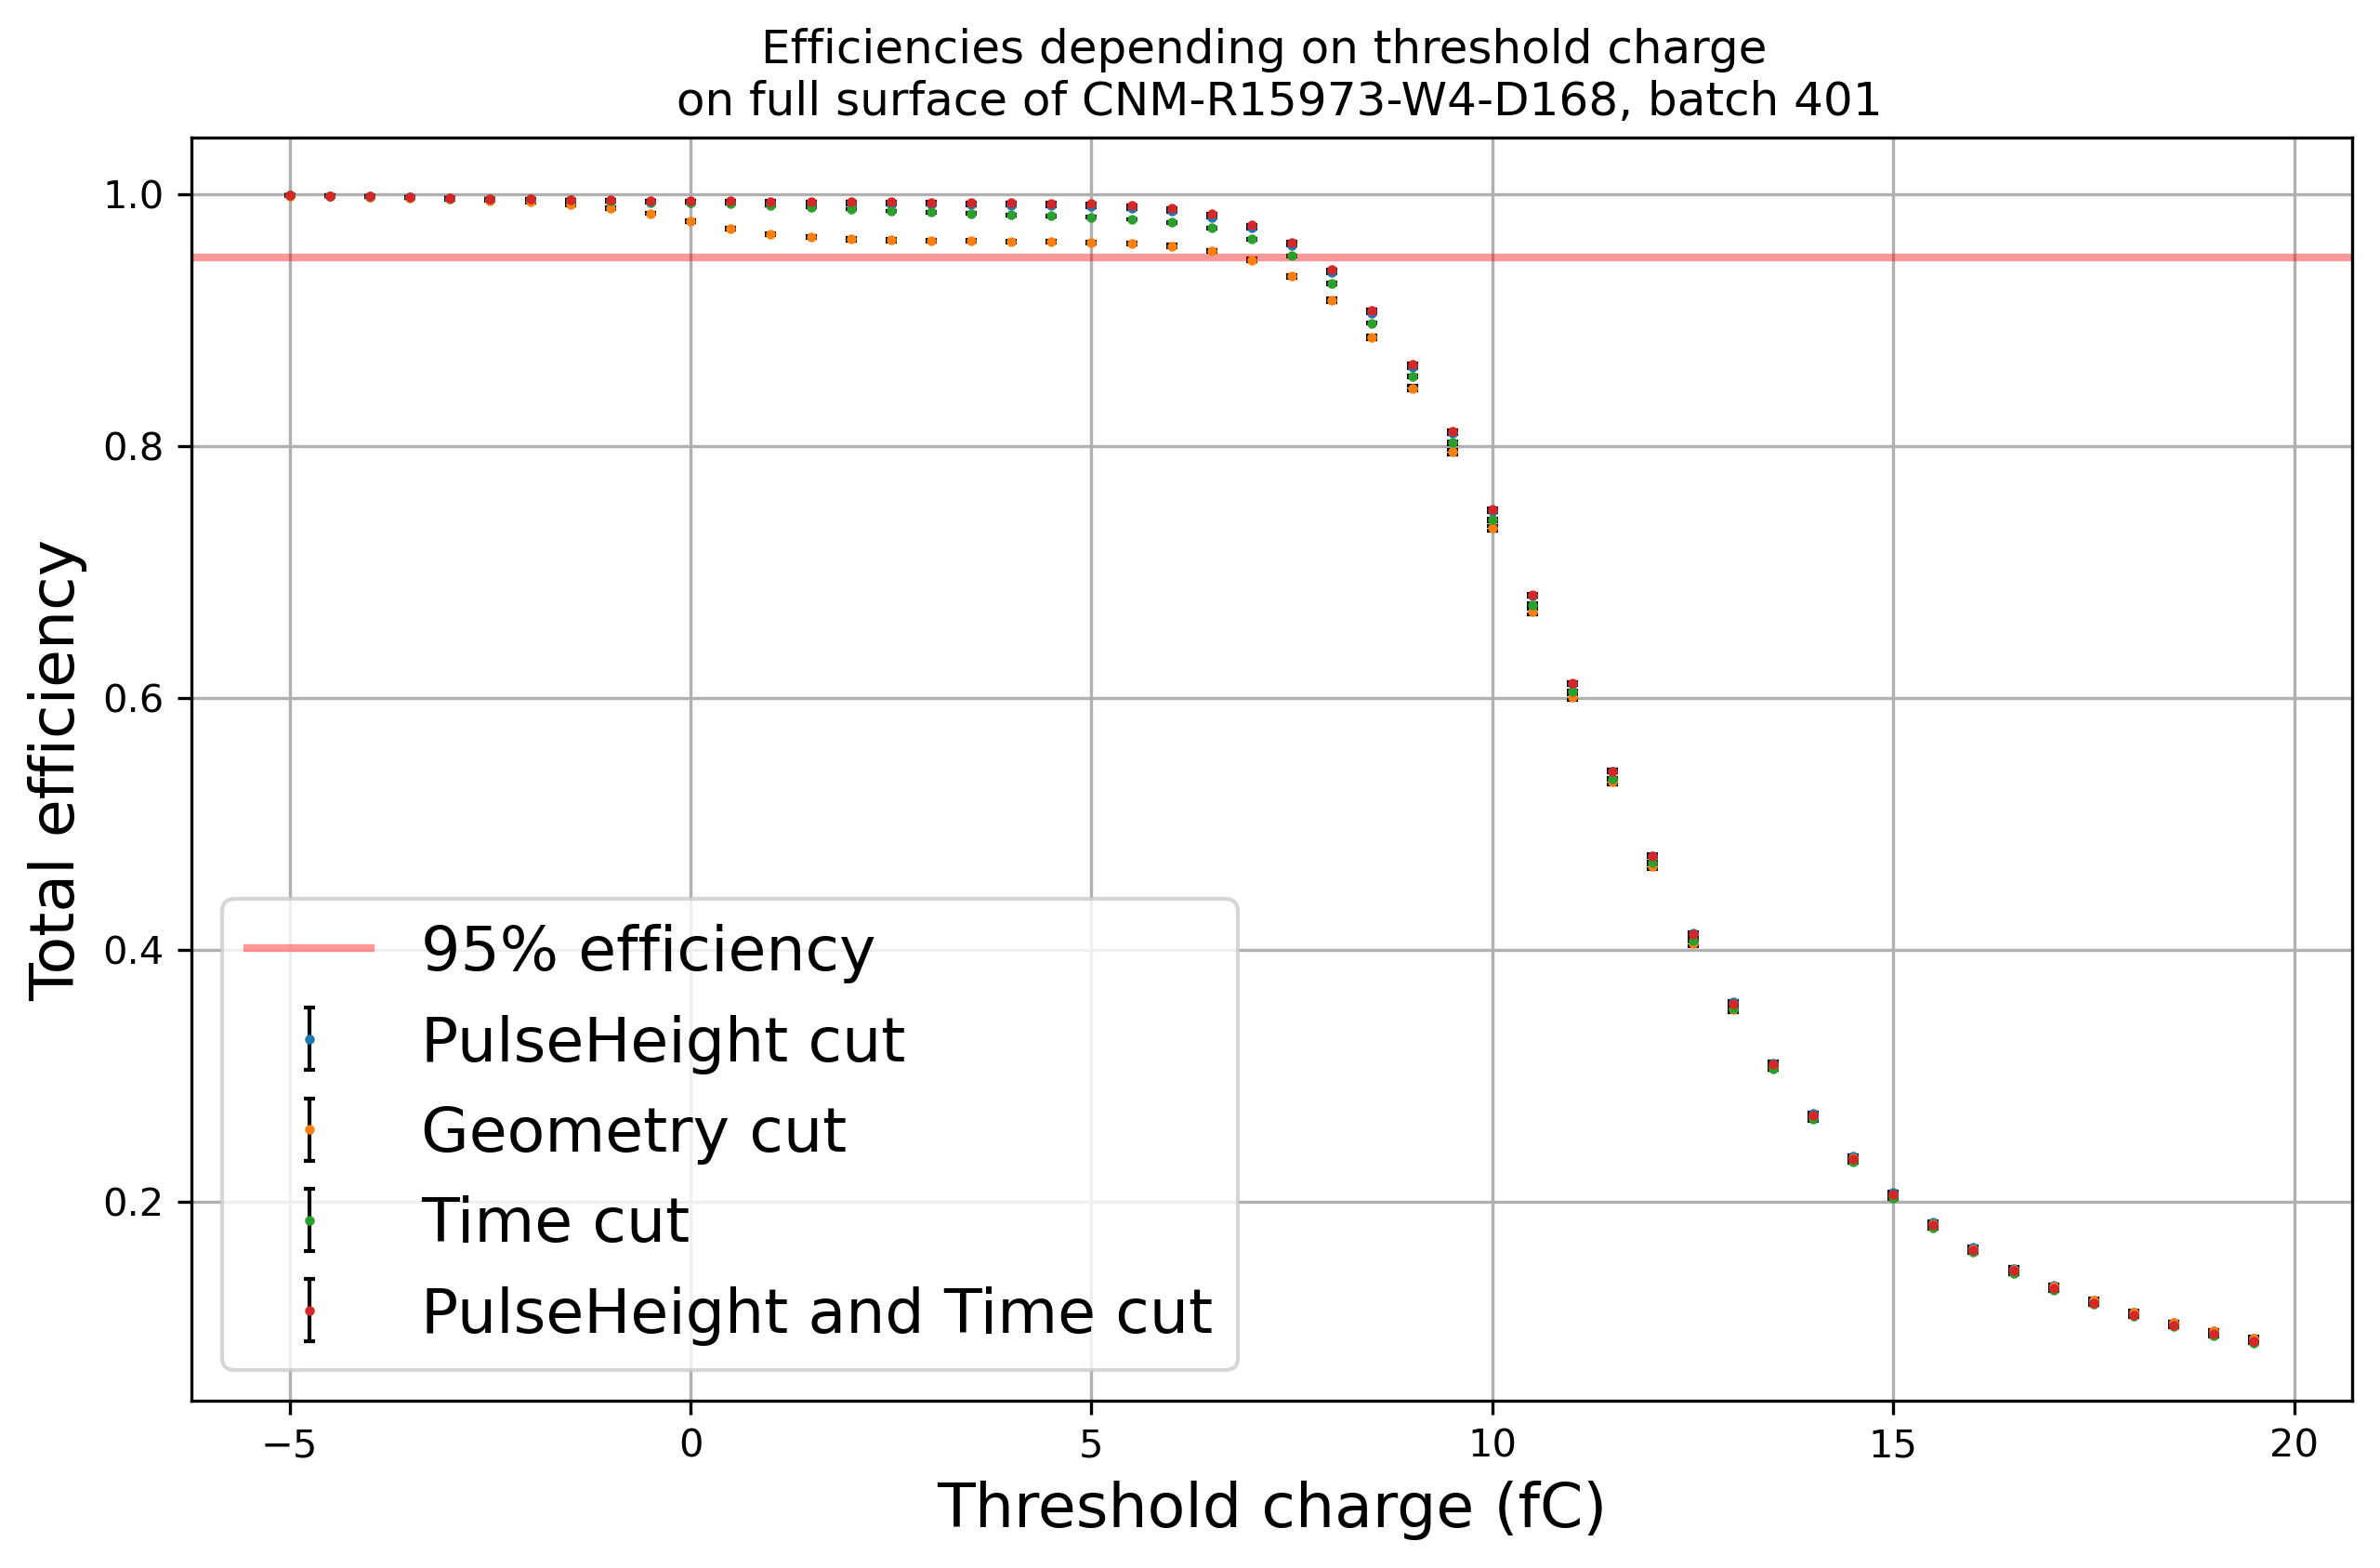

In [16]:
this_scope = "S2"
# transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in (1,2,3)]

dut = 2
threshold_range = np.arange(-5, 20, 0.5)

efficiency_pulse_cut = []
error_pulse_cut = []

efficiency_center = []
error_center = []

efficiency_time_cut = []
error_time_cut = []

efficiency_pulse_time_cut = []
error_pulse_time_cut = []

geometry = geometry_mask(df[this_scope], DUT_number=dut, bins=bins)[0]
geometry_center = geometry_mask(df[this_scope], DUT_number=dut, bins=bins, only_select='center')[0]
pulse_min = mins[this_scope][dut]
pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>pulse_min

for charge in threshold_range:
    ### efficiency with pulseHeight cut
    eff, err = efficiency_error(df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,pulseHeight)]/transimpedance[dut-1], charge)
    efficiency_pulse_cut.append(eff)
    error_pulse_cut.append(err) 
    ### efficiency with geometry cut
    eff, err = efficiency_error(df[this_scope][f"charge_{dut}"].loc[geometry_center]/transimpedance[dut-1], charge)
    efficiency_center.append(eff)
    error_center.append(err) 
    ### efficiency with time cut
    eff, err = efficiency_error(df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,all_time_cut[dut-1])]/transimpedance[dut-1], charge)
    efficiency_time_cut.append(eff)
    error_time_cut.append(err)
    ### efficiency with pulseHeight AND time cuts
    eff, err = efficiency_error(df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,np.logical_and(pulseHeight,all_time_cut[dut-1]))]/transimpedance[dut-1], charge)
    efficiency_pulse_time_cut.append(eff)
    error_pulse_time_cut.append(err)
    
    
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
### pulseHeight cut
ax.errorbar(threshold_range, efficiency_pulse_cut, yerr=error_pulse_cut, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"PulseHeight cut")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")
### central area
ax.errorbar(threshold_range, efficiency_center, yerr=error_center, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"Geometry cut")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")
### time cut
ax.errorbar(threshold_range, efficiency_time_cut, yerr=error_time_cut, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"Time cut")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")

### pulseHeight AND time cuts
ax.errorbar(threshold_range, efficiency_pulse_time_cut, yerr=error_pulse_time_cut, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"PulseHeight and Time cut")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")

ax.set_title(f"Efficiencies depending on threshold charge \n \
on full surface of {dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch{dut+1}'}, batch {this_batch}")
ax.set_xlabel("Threshold charge (fC)",fontsize=16)
ax.set_ylabel("Total efficiency",fontsize=16)
ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
ax.grid('--')
ax.legend(fontsize=16)
# fig.savefig(f"../various plots/Total_efficiencies_change_{this_batch}_{this_scope}_DUT{dut}_different_cuts.svg")

### Efficiency for all sensors

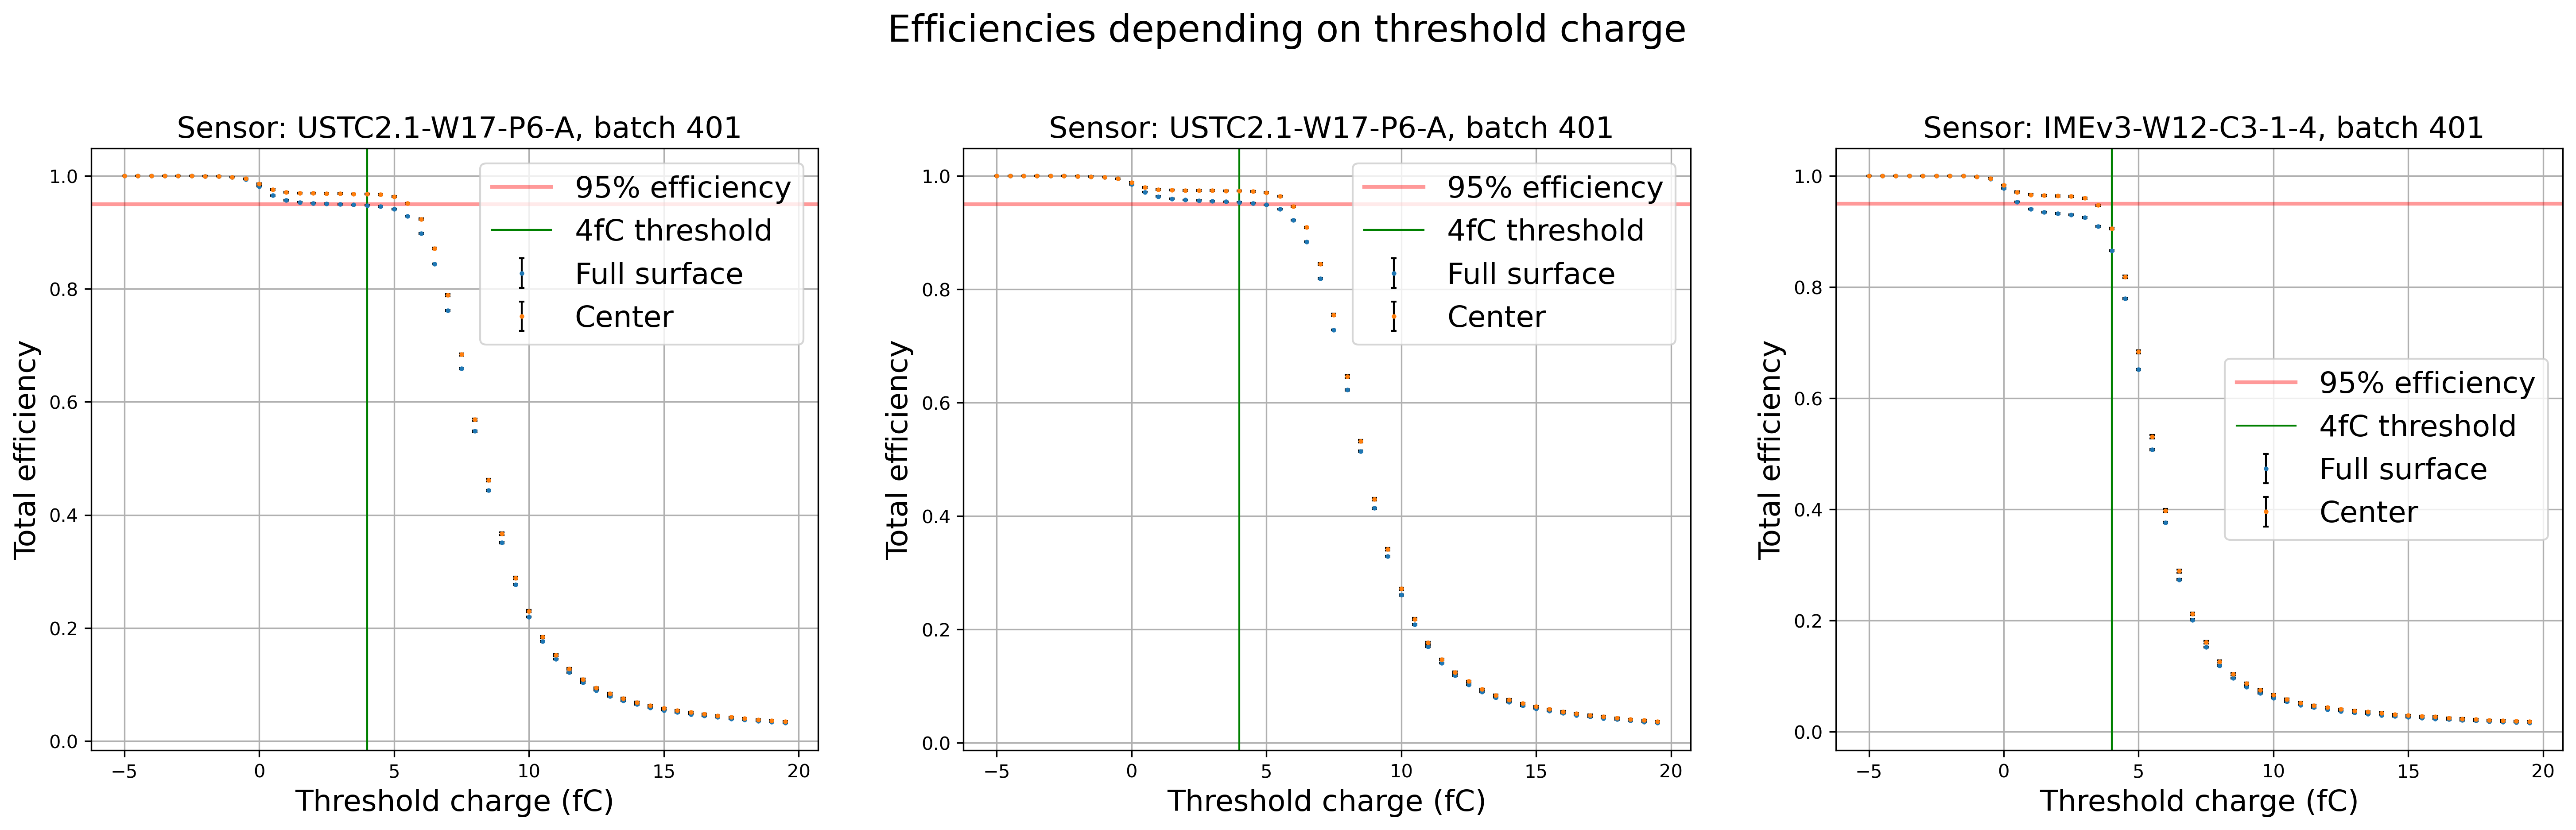

In [29]:
this_scope = "S1"
transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in DUTs]

threshold_range = np.arange(-5, 20, 0.5)
fig, axes = plt.subplots(figsize=(8*len(DUTs),6),ncols=len(DUTs), dpi=300)

for i,dut in enumerate(DUTs):
    efficiency_normal = []
    error_normal = []
    
    efficiency_center = []
    error_center = []

    geometry = geometry_mask(df[this_scope], DUT_number=dut, bins=bins)[0]
    geometry_center = geometry_mask(df[this_scope], DUT_number=dut, bins=bins, only_select='center')[0]

    for charge in threshold_range:
        ### efficiency with geometry cut
        eff, err = efficiency_error(df[this_scope][f"charge_{dut}"].loc[geometry]/transimpedance[dut-1], charge)
        efficiency_normal.append(eff)
        error_normal.append(err)
        ### efficiency with geometry cut (center)
        eff, err = efficiency_error(df[this_scope][f"charge_{dut}"].loc[geometry_center]/transimpedance[dut-1], charge)
        efficiency_center.append(eff)
        error_center.append(err) 
        
    ### geometry cut
    axes[i].errorbar(threshold_range, efficiency_normal, yerr=error_normal, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Full surface")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")
    ### geometry cut (center)
    axes[i].errorbar(threshold_range, efficiency_center, yerr=error_center, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Center")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")

    axes[i].set_title(f" Sensor: {dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch{dut+1}').name}, batch {this_batch}",fontsize=16)
    axes[i].set_xlabel("Threshold charge (fC)",fontsize=16)
    axes[i].set_ylabel("Total efficiency",fontsize=16)
    axes[i].axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
    axes[i].axvline(4, label="4fC threshold", color='g', linewidth=1)
    axes[i].grid('--')
    axes[i].legend(fontsize=16)
fig.suptitle(f"Efficiencies depending on threshold charge",fontsize=20,y=1.05)
fig.savefig(os.path.join(pres_path,f"Efficiencies depending on threshold charge batch {this_batch} {this_scope}.png"), bbox_inches='tight')

NameError: name 'colormap' is not defined

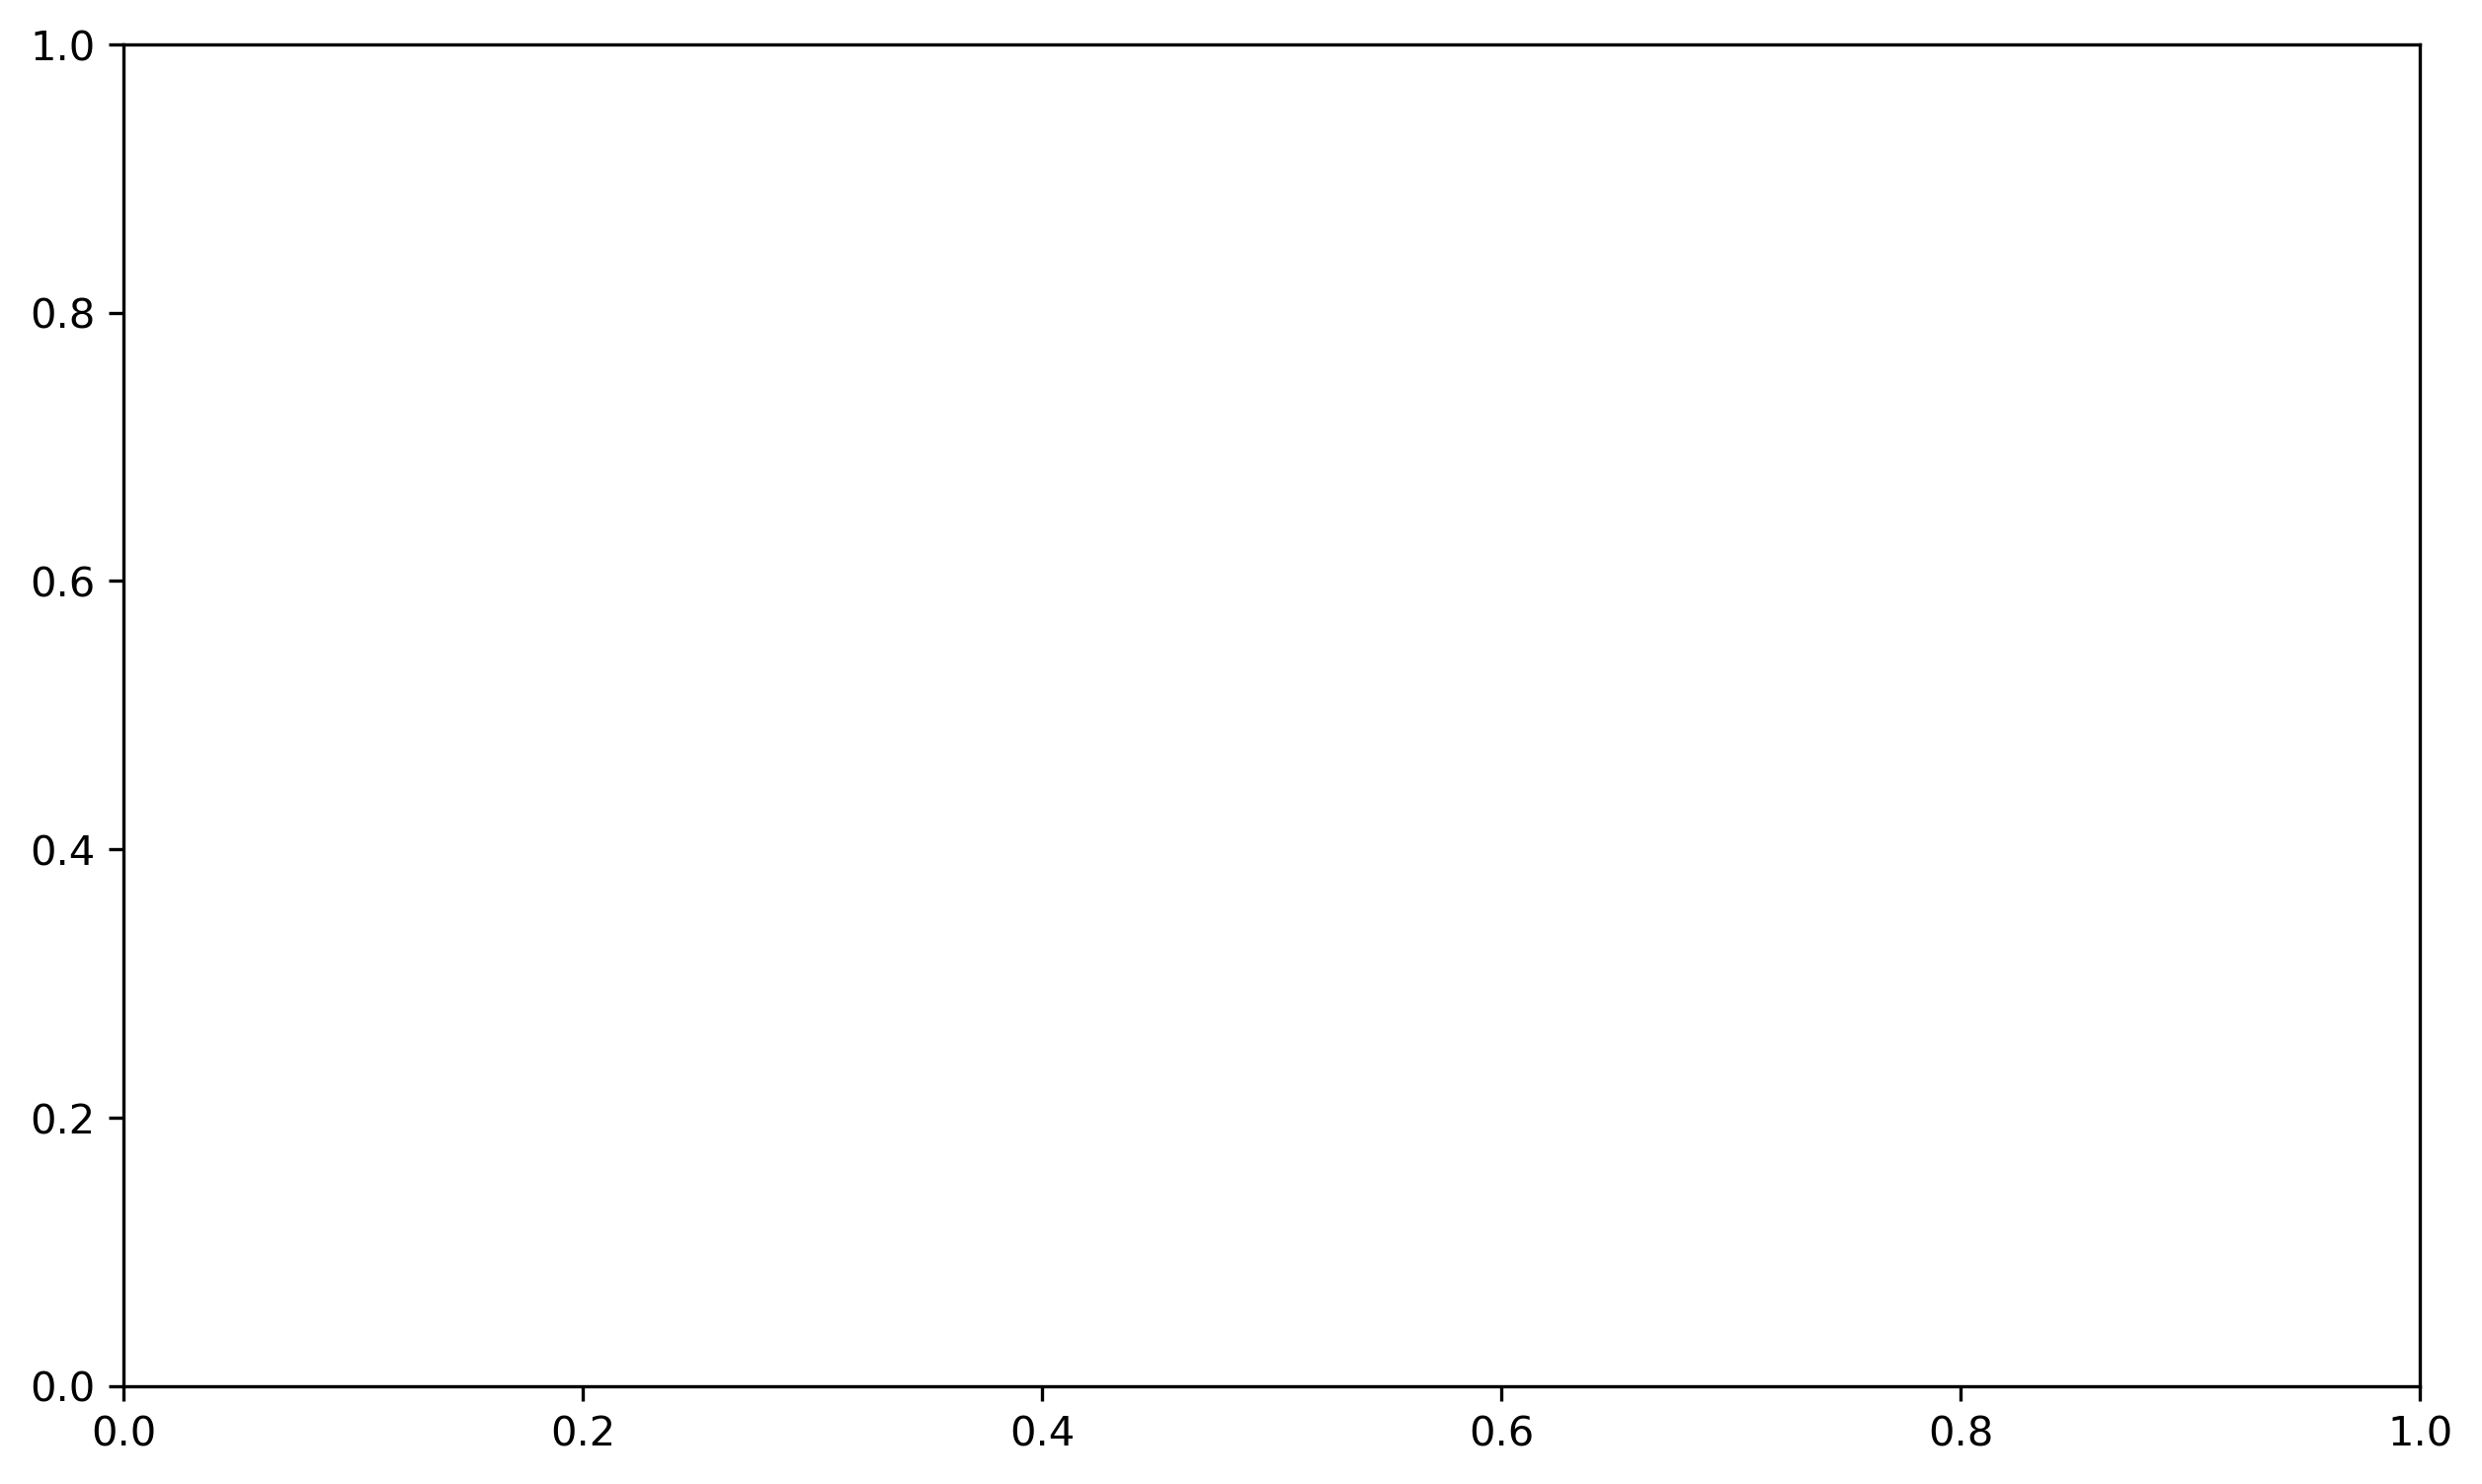

In [17]:
# mins = {"S1":[0,53.8,52.1,65.3], "S2":[0,37.9,51.6,64.3]}
# this_scope = "S2"
this_DUT = 2 ### 1,2,3
# transimpedance = get_transimpedance(this_batch, this_scope)[this_DUT-1]
transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in (1,2,3)]


pulseheight_cut = df[this_scope][f"pulseHeight_{this_DUT}"]>mins[this_scope][this_DUT]
geometry_cut = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=this_DUT)[0]
time_cut = all_time_cut[this_DUT-1]

data_pulse_filter = df[this_scope][f"charge_{this_DUT}"].loc[pulseheight_cut]/transimpedance[this_DUT-1]
# data_pulse_geo_filter = df[this_scope][f"charge_{this_DUT}"].loc[np.logical_and(pulseheight_cut, geometry_cut)]/transimpedance[this_DUT-1]
data_geo_filter = df[this_scope][f"charge_{this_DUT}"].loc[geometry_cut]/transimpedance[this_DUT-1]
data_time_filter = df[this_scope][f"charge_{this_DUT}"].loc[time_cut]/transimpedance[this_DUT-1]

### I need to figure out how to combine colors into nice thing
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
hist, bins_for_all, _,_,_ = plot_histogram(df[this_scope][f"charge_{this_DUT}"]/transimpedance[this_DUT-1], bins='auto', label="no cut", fig_ax=(fig,ax), color=colormap[0], linewidth=1)
plot_histogram(data_pulse_filter, bins=bins_for_all, fig_ax=(fig,ax), label="pulseheight cut", alpha=.5, color=colormap[1], histtype='stepfilled')
# plot_histogram(data_pulse_geo_filter, bins=bins_for_all, fig_ax=(fig,ax), label="pulseheight & geom. cut", alpha=.5, color='#ff0000')
plot_histogram(data_geo_filter, bins=bins_for_all, fig_ax=(fig,ax), label="geometry cut", alpha=.5, color=colormap[2], histtype='stepfilled') # #ffff00
plot_histogram(data_time_filter, bins=bins_for_all, fig_ax=(fig,ax), label="time cut", alpha=.5, color=colormap[3], histtype='stepfilled') # #ffff00

ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.set_title(f"Charge plot various cuts \nbatch:{this_batch}, {this_scope}, DUT:{this_DUT} ({dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch{dut+1}').name})",
             fontsize=24,y=1.05)
ax.grid('--')
ax.set_xlim(-5,20)
ax.semilogy()
ax.legend(fontsize=16)

# fig.savefig(f"../various plots/charge_plot_various_cuts_{this_batch}_{this_scope}_DUT{this_DUT}.svg",bbox_inches='tight')

In [ ]:
plt.hist(df['S1']['charge_1']/get_transimpedance(this_batch,'S1')[1], bins='auto');

In [ ]:
# dut = 1

# fig, axes = plt.subplots(figsize=(15,5),nrows=1,ncols=2, dpi=300)
# for this_scope in ["S1","S2"]:
#     pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
#     hist,my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=10000, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[0])) ### MCP - CERN1
#     plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=my_bins, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[1]));### MCP - CERN1
#     hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut])/1000, bins=my_bins, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1 \n with pulseHeigh cut", fig_ax=(fig,axes[1]))  ### MCP - CERN3
#     time_peak, info_peaks = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10) 
#     axes[0].axvline(my_bins[time_peak],color='r',linewidth=.5)
#     axes[0].axvline(my_bins[info_peaks['left_bases']],color='g')
#     axes[0].axvline(my_bins[info_peaks['right_bases']],color='r')
#     print("peak position:",my_bins[time_peak][0],"ns")
    
    
# axes[0].set_title(f"Time difference")
# axes[0].set_xlabel("Time (ns)")
# axes[0].set_xlim(-8,-2)
# axes[1].set_xlim(-8,-2)
# axes[1].set_xlabel("Time (ns)")
# axes[1].set_title("Time difference (w/ pulseHeight cut))")
# axes[0].legend()
# axes[1].legend()
# fig.suptitle(f"Batch: {this_batch}, Oscilloscope: {this_scope}",y=1.1, fontsize=20)
# # fig.savefig(f"../various plots/time_difference{this_batch}_DUT{dut}_with_pulseHeight_cut.svg",bbox_inches='tight')
# # fig.savefig(f"../various plots/time_difference{this_batch}_S{this_scope}_all_DUTs_with_pulseHeight_cut.svg",bbox_inches='tight')

#### I was trying to plot the FE-I4 mask but it does not quite work

In [ ]:
# ### I was trying to plot the FE-I4 mask but it does not quite work

# ### Create a figure and axis
# fig, ax = plt.subplots()
# ### Define the coordinates, width, and height of multiple rectangles
# rectangles = [#(0,0,210,297), # x,y,width, height
#               (0,297,297,210),
#               (210,0,210,297),
#               (420,0,210,297),
#               (297,297,297,210)]

# ### Loop through the list of rectangles and draw them
# for i, rect in enumerate(rectangles):
#     x, y, width, height = rect
#     ax.add_patch(mpatches.Rectangle((x, y), width, height, fill=True, alpha=0.5, color=colormap[i]))

# ### Set axis limits if needed
# ax.set_xlim(0,700)
# ax.set_ylim(0,500)

# ### Display the plot
# plt.gca().set_aspect('equal', adjustable='box')  # Make sure aspect ratio is equal
# plt.show()

#### I'm experimenting with multidimensional dataframes (?)